# Week - 41

In [2]:
import pandas as pd

mean_tl = pd.read_csv("../../data/processed/Average_Trophic_Size_Height_Gateway_Dataset/mean_tl.csv", low_memory=False)
mean_tl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ecosystem            289 non-null    object 
 1   Ecosystem_type       289 non-null    object 
 2   Mean_Trophic_Level   289 non-null    float64
 3   Num_Species_full     289 non-null    int64  
 4   Num_Species_largest  289 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 11.4+ KB


[warn] 17 rows could not be matched to Mean_Trophic_Level. Check naming in results vs metadata.


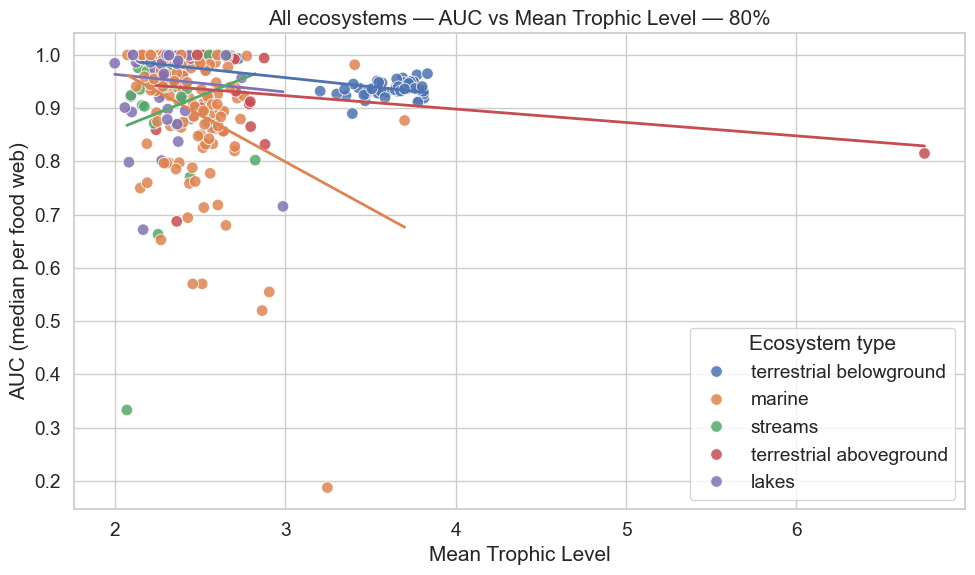

In [4]:
# Imports
import re
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- Paths ---
results_dir     = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file  = "../../data/processed/Average_Trophic_Size_Height_Gateway_Dataset/mean_tl.csv"  # <-- 289-row table with mean TL
ecosystem_type  = "all"   # set to None or "all" to see all types
score           = "AUC"                       # one of "AUC", "Precision", "Recall", "F1Score"
TrainRatio_filter = 80                     # only consider results with this TrainRatio (if present)

sns.set_theme(style="whitegrid", font_scale=1.25)

# --- Helpers ---
def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

def pick_col(df: pd.DataFrame, candidates):
    norm_map = {_normalize(c): c for c in df.columns}
    for k in candidates:
        if k in norm_map:
            return norm_map[k]
    raise RuntimeError(f"Could not find any of: {candidates}")

def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)
# Canonical column names from your file
foodweb_col   = "Ecosystem"
eco_type_col  = "Ecosystem_type"
tl_col        = "Mean_Trophic_Level"

# Slim metadata with canonical name + normalized key
def _normalize(s: str) -> str:
    return str(s).strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

meta_df = (
    df_ecosystem[[foodweb_col, eco_type_col, tl_col]]
    .rename(columns={foodweb_col: "Foodweb"})
    .copy()
)
meta_df["__key__"] = meta_df["Foodweb"].map(_normalize)

# --- Load result CSVs and stack (robust filename → Foodweb) ---

def infer_foodweb_name(path: str) -> str:
    base = os.path.basename(path)
    name = re.sub(r"\.csv$", "", base, flags=re.I)
    # strip from "_results_..." to the end (handles _results_random, _results_random_rare, etc.)
    name = re.sub(r"_results_.*$", "", name, flags=re.I)
    # then strip trailing "_tax_mass" (or minor variants)
    name = re.sub(r"_tax[_-]?mass$", "", name, flags=re.I)
    return name

csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = infer_foodweb_name(file)   # <-- fixed extraction
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check 'results_dir' and filename pattern.")
df_all = pd.concat(dfs, ignore_index=True)
df_all["__key__"] = df_all["Foodweb"].map(_normalize)

# --- Merge on normalized key (robust) ---
base = pd.merge(
    df_all,
    meta_df[["__key__", "Foodweb", eco_type_col, tl_col]].rename(columns={"Foodweb": "Foodweb_meta"}),
    on="__key__", how="left"
)
# prefer canonical name from metadata when present
base["Foodweb"] = base["Foodweb_meta"].fillna(base["Foodweb"])
base.drop(columns=["__key__", "Foodweb_meta"], inplace=True)

# Diagnostics
n_unmatched = base[tl_col].isna().sum()
if n_unmatched:
    print(f"[warn] {n_unmatched} rows could not be matched to Mean_Trophic_Level. "
          f"Check naming in results vs metadata.")

# --- TrainRatio filter (only if present) ---
if "TrainRatio" in base.columns:
    def to_percent(s: pd.Series) -> pd.Series:
        sr = pd.to_numeric(s, errors="coerce")
        if sr.dropna().max() <= 1.000001:
            sr = sr * 100
        return sr
    base["TrainRatio_pct"] = to_percent(base["TrainRatio"])
    base = base[ base["TrainRatio_pct"] == TrainRatio_filter ]
else:
    print(f"[warn] 'TrainRatio' column not found; skipping {TrainRatio_filter}% filter.")

# Aggregate the chosen score per Foodweb
agg = (base
       .dropna(subset=[tl_col, score])
       .groupby(["Foodweb", eco_type_col, tl_col], as_index=False)[score]
       .median()
       .rename(columns={score: f"{score}_median"}))

# --- Filter by ecosystem type (if specified) ---
if ecosystem_type and str(ecosystem_type).lower() != "all":
    plot_df = agg[agg[eco_type_col].str.lower() == ecosystem_type.lower()].copy()
else:
    plot_df = agg.copy()

if plot_df.empty:
    raise RuntimeError("No rows after filtering by ecosystem type. Check 'ecosystem_type' string.")

# --- Plot: color by ecosystem type when 'all', otherwise single-color regplot ---
plt.figure(figsize=(10, 6))

if str(ecosystem_type).lower() == "all":
    # Points colored by ecosystem type
    types_order = plot_df[eco_type_col].dropna().unique().tolist()
    palette = sns.color_palette("deep", n_colors=len(types_order))
    color_map = dict(zip(types_order, palette))

    ax = sns.scatterplot(
        data=plot_df,
        x=tl_col, y=f"{score}_median",
        hue=eco_type_col, hue_order=types_order, palette=color_map,
        s=70, alpha=0.85, edgecolor="white"  # avoid linewidth/linewidths aliasing
    )

    # Optional: per-type regression lines in matching colors
    draw_per_type_trend = True
    if draw_per_type_trend:
        for etype, sub in plot_df.groupby(eco_type_col):
            if len(sub) >= 2:
                sns.regplot(
                    data=sub, x=tl_col, y=f"{score}_median",
                    scatter=False, ci=0, color=color_map.get(etype, "gray"),
                    line_kws=dict(linewidth=2), ax=ax
                )

    # Optional: also draw a global trend in black
    draw_global_trend = False
    if draw_global_trend and len(plot_df) >= 2:
        sns.regplot(
            data=plot_df, x=tl_col, y=f"{score}_median",
            scatter=False, ci=95, color="black",
            line_kws=dict(linewidth=2, alpha=0.7), ax=ax
        )

    # Legend formatting
    ax.legend(title="Ecosystem type", loc="lower right", frameon=True)

    # Spearman (global) annotation
    if len(plot_df) >= 2:
        r, p = spearmanr(plot_df[tl_col], plot_df[f"{score}_median"], nan_policy="omit")

else:
    # Single ecosystem type selected -> standard regplot
    ax = sns.regplot(
        data=plot_df,
        x=tl_col, y=f"{score}_median",
        scatter_kws=dict(s=70, alpha=0.85, edgecolor="white"),
        line_kws=dict(linewidth=2),
        ci=95, lowess=False
    )
    if len(plot_df) >= 2:
        r, p = spearmanr(plot_df[tl_col], plot_df[f"{score}_median"], nan_policy="omit")

# Labels & title
etype_label = "All ecosystems" if str(ecosystem_type).lower() == "all" else ecosystem_type
ax.set_xlabel("Mean Trophic Level")
ax.set_ylabel(f"{score} (median per food web)")
ax.set_title(f"{etype_label} — {score} vs Mean Trophic Level — {TrainRatio_filter}%")

plt.tight_layout()
plt.show()

[warn] 17 rows could not be matched to Mean_Trophic_Level. Check naming in results vs metadata.


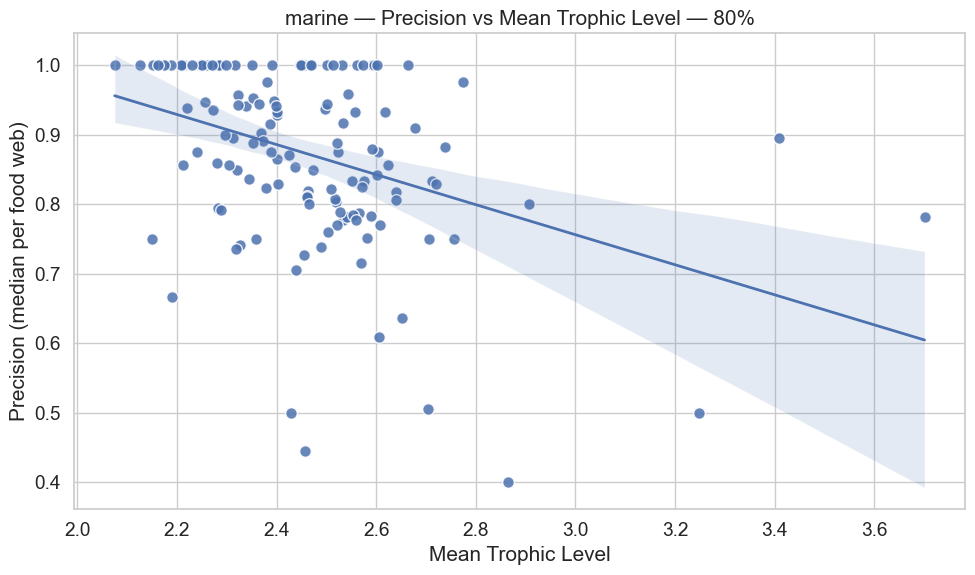

In [2]:
# Imports
import re
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- Paths ---
results_dir     = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file  = "../../data/processed/Average_Trophic_Size_Height_Gateway_Dataset/mean_tl.csv"  # <-- 289-row table with mean TL
ecosystem_type  = "marine"   # set to None or "all" to see all types
score           = "Precision"                       # one of "AUC", "Precision", "Recall", "F1Score"
TrainRatio_filter = 80                     # only consider results with this TrainRatio (if present)

sns.set_theme(style="whitegrid", font_scale=1.25)

# --- Helpers ---
def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

def pick_col(df: pd.DataFrame, candidates):
    norm_map = {_normalize(c): c for c in df.columns}
    for k in candidates:
        if k in norm_map:
            return norm_map[k]
    raise RuntimeError(f"Could not find any of: {candidates}")

def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)
# Canonical column names from your file
foodweb_col   = "Ecosystem"
eco_type_col  = "Ecosystem_type"
tl_col        = "Mean_Trophic_Level"

# Slim metadata with canonical name + normalized key
def _normalize(s: str) -> str:
    return str(s).strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

meta_df = (
    df_ecosystem[[foodweb_col, eco_type_col, tl_col]]
    .rename(columns={foodweb_col: "Foodweb"})
    .copy()
)
meta_df["__key__"] = meta_df["Foodweb"].map(_normalize)

# --- Load result CSVs and stack (robust filename → Foodweb) ---

def infer_foodweb_name(path: str) -> str:
    base = os.path.basename(path)
    name = re.sub(r"\.csv$", "", base, flags=re.I)
    # strip from "_results_..." to the end (handles _results_random, _results_random_rare, etc.)
    name = re.sub(r"_results_.*$", "", name, flags=re.I)
    # then strip trailing "_tax_mass" (or minor variants)
    name = re.sub(r"_tax[_-]?mass$", "", name, flags=re.I)
    return name

csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = infer_foodweb_name(file)   # <-- fixed extraction
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check 'results_dir' and filename pattern.")
df_all = pd.concat(dfs, ignore_index=True)
df_all["__key__"] = df_all["Foodweb"].map(_normalize)

# --- Merge on normalized key (robust) ---
base = pd.merge(
    df_all,
    meta_df[["__key__", "Foodweb", eco_type_col, tl_col]].rename(columns={"Foodweb": "Foodweb_meta"}),
    on="__key__", how="left"
)
# prefer canonical name from metadata when present
base["Foodweb"] = base["Foodweb_meta"].fillna(base["Foodweb"])
base.drop(columns=["__key__", "Foodweb_meta"], inplace=True)

# Diagnostics
n_unmatched = base[tl_col].isna().sum()
if n_unmatched:
    print(f"[warn] {n_unmatched} rows could not be matched to Mean_Trophic_Level. "
          f"Check naming in results vs metadata.")

# --- TrainRatio filter (only if present) ---
if "TrainRatio" in base.columns:
    def to_percent(s: pd.Series) -> pd.Series:
        sr = pd.to_numeric(s, errors="coerce")
        if sr.dropna().max() <= 1.000001:
            sr = sr * 100
        return sr
    base["TrainRatio_pct"] = to_percent(base["TrainRatio"])
    base = base[ base["TrainRatio_pct"] == TrainRatio_filter ]
else:
    print(f"[warn] 'TrainRatio' column not found; skipping {TrainRatio_filter}% filter.")

# Aggregate the chosen score per Foodweb
agg = (base
       .dropna(subset=[tl_col, score])
       .groupby(["Foodweb", eco_type_col, tl_col], as_index=False)[score]
       .median()
       .rename(columns={score: f"{score}_median"}))

# --- Filter by ecosystem type (if specified) ---
if ecosystem_type and str(ecosystem_type).lower() != "all":
    plot_df = agg[agg[eco_type_col].str.lower() == ecosystem_type.lower()].copy()
else:
    plot_df = agg.copy()

if plot_df.empty:
    raise RuntimeError("No rows after filtering by ecosystem type. Check 'ecosystem_type' string.")

# --- Plot: color by ecosystem type when 'all', otherwise single-color regplot ---
plt.figure(figsize=(10, 6))

if str(ecosystem_type).lower() == "all":
    # Points colored by ecosystem type
    types_order = plot_df[eco_type_col].dropna().unique().tolist()
    palette = sns.color_palette("deep", n_colors=len(types_order))
    color_map = dict(zip(types_order, palette))

    ax = sns.scatterplot(
        data=plot_df,
        x=tl_col, y=f"{score}_median",
        hue=eco_type_col, hue_order=types_order, palette=color_map,
        s=70, alpha=0.85, edgecolor="white"  # avoid linewidth/linewidths aliasing
    )

    # Optional: per-type regression lines in matching colors
    draw_per_type_trend = True
    if draw_per_type_trend:
        for etype, sub in plot_df.groupby(eco_type_col):
            if len(sub) >= 2:
                sns.regplot(
                    data=sub, x=tl_col, y=f"{score}_median",
                    scatter=False, ci=0, color=color_map.get(etype, "gray"),
                    line_kws=dict(linewidth=2), ax=ax
                )

    # Optional: also draw a global trend in black
    draw_global_trend = False
    if draw_global_trend and len(plot_df) >= 2:
        sns.regplot(
            data=plot_df, x=tl_col, y=f"{score}_median",
            scatter=False, ci=95, color="black",
            line_kws=dict(linewidth=2, alpha=0.7), ax=ax
        )

    # Legend formatting
    ax.legend(title="Ecosystem type", loc="lower right", frameon=True)

    # Spearman (global) annotation
    if len(plot_df) >= 2:
        r, p = spearmanr(plot_df[tl_col], plot_df[f"{score}_median"], nan_policy="omit")

else:
    # Single ecosystem type selected -> standard regplot
    ax = sns.regplot(
        data=plot_df,
        x=tl_col, y=f"{score}_median",
        scatter_kws=dict(s=70, alpha=0.85, edgecolor="white"),
        line_kws=dict(linewidth=2),
        ci=95, lowess=False
    )
    if len(plot_df) >= 2:
        r, p = spearmanr(plot_df[tl_col], plot_df[f"{score}_median"], nan_policy="omit")

# Labels & title
etype_label = "All ecosystems" if str(ecosystem_type).lower() == "all" else ecosystem_type
ax.set_xlabel("Mean Trophic Level")
ax.set_ylabel(f"{score} (median per food web)")
ax.set_title(f"{etype_label} — {score} vs Mean Trophic Level — {TrainRatio_filter}%")

plt.tight_layout()
plt.show()

[warn] 17 rows could not be matched to Mean_Trophic_Level. Check naming in results vs metadata.


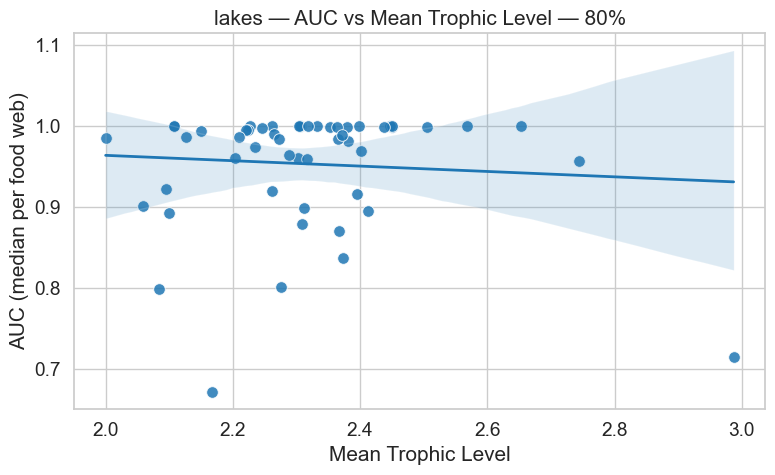

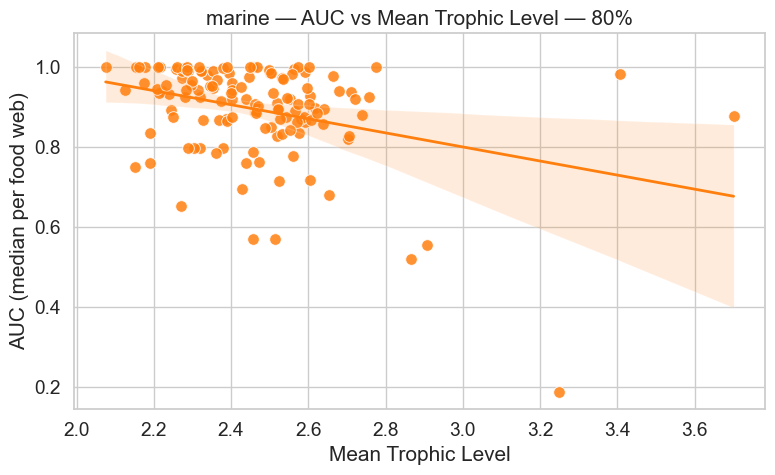

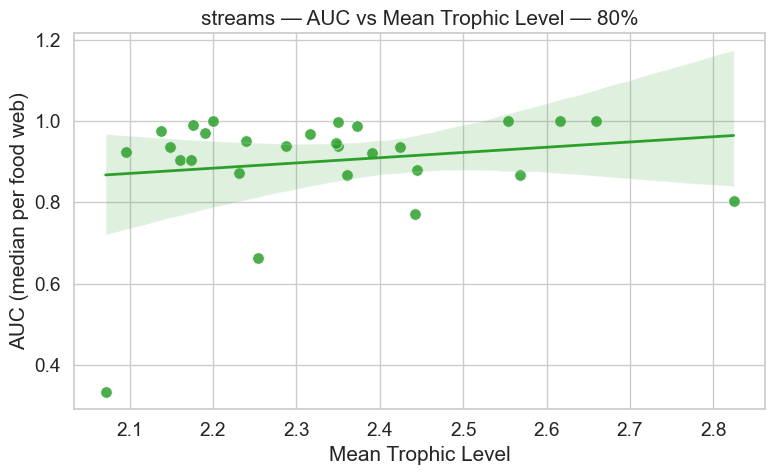

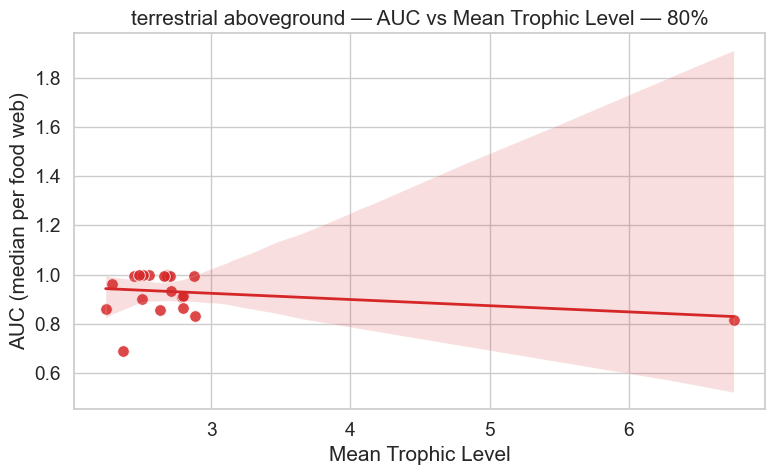

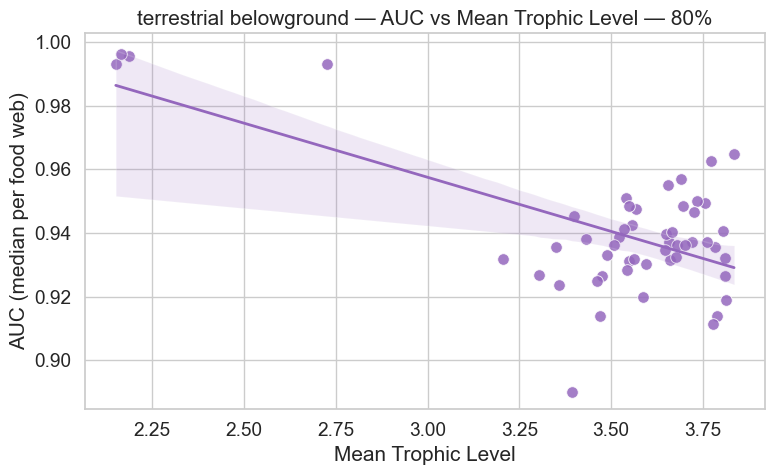

In [1]:
# Imports
import re
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- Paths ---
results_dir     = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file  = "../../data/processed/Average_Trophic_Size_Height_Gateway_Dataset/mean_tl.csv"  # <-- 289-row table with mean TL
ecosystem_type  = "marine"   # set to None or "all" to see all types
score           = "AUC"                       # one of "AUC", "Precision", "Recall", "F1Score"
TrainRatio_filter = 80                     # only consider results with this TrainRatio (if present)

sns.set_theme(style="whitegrid", font_scale=1.25)

# --- Helpers ---
def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

def pick_col(df: pd.DataFrame, candidates):
    norm_map = {_normalize(c): c for c in df.columns}
    for k in candidates:
        if k in norm_map:
            return norm_map[k]
    raise RuntimeError(f"Could not find any of: {candidates}")

def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)
# Canonical column names from your file
foodweb_col   = "Ecosystem"
eco_type_col  = "Ecosystem_type"
tl_col        = "Mean_Trophic_Level"

# Slim metadata with canonical name + normalized key
def _normalize(s: str) -> str:
    return str(s).strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

meta_df = (
    df_ecosystem[[foodweb_col, eco_type_col, tl_col]]
    .rename(columns={foodweb_col: "Foodweb"})
    .copy()
)
meta_df["__key__"] = meta_df["Foodweb"].map(_normalize)

# --- Load result CSVs and stack (robust filename → Foodweb) ---

def infer_foodweb_name(path: str) -> str:
    base = os.path.basename(path)
    name = re.sub(r"\.csv$", "", base, flags=re.I)
    # strip from "_results_..." to the end (handles _results_random, _results_random_rare, etc.)
    name = re.sub(r"_results_.*$", "", name, flags=re.I)
    # then strip trailing "_tax_mass" (or minor variants)
    name = re.sub(r"_tax[_-]?mass$", "", name, flags=re.I)
    return name

csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = infer_foodweb_name(file)   # <-- fixed extraction
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check 'results_dir' and filename pattern.")
df_all = pd.concat(dfs, ignore_index=True)
df_all["__key__"] = df_all["Foodweb"].map(_normalize)

# --- Merge on normalized key (robust) ---
base = pd.merge(
    df_all,
    meta_df[["__key__", "Foodweb", eco_type_col, tl_col]].rename(columns={"Foodweb": "Foodweb_meta"}),
    on="__key__", how="left"
)
# prefer canonical name from metadata when present
base["Foodweb"] = base["Foodweb_meta"].fillna(base["Foodweb"])
base.drop(columns=["__key__", "Foodweb_meta"], inplace=True)

# Diagnostics
n_unmatched = base[tl_col].isna().sum()
if n_unmatched:
    print(f"[warn] {n_unmatched} rows could not be matched to Mean_Trophic_Level. "
          f"Check naming in results vs metadata.")

# --- TrainRatio filter (only if present) ---
if "TrainRatio" in base.columns:
    def to_percent(s: pd.Series) -> pd.Series:
        sr = pd.to_numeric(s, errors="coerce")
        if sr.dropna().max() <= 1.000001:
            sr = sr * 100
        return sr
    base["TrainRatio_pct"] = to_percent(base["TrainRatio"])
    base = base[ base["TrainRatio_pct"] == TrainRatio_filter ]
else:
    print(f"[warn] 'TrainRatio' column not found; skipping {TrainRatio_filter}% filter.")

# Aggregate the chosen score per Foodweb
agg = (base
       .dropna(subset=[tl_col, score])
       .groupby(["Foodweb", eco_type_col, tl_col], as_index=False)[score]
       .median()
       .rename(columns={score: f"{score}_median"}))

# --- Filter by ecosystem type (if specified) ---
if ecosystem_type and str(ecosystem_type).lower() != "all":
    plot_df = agg[agg[eco_type_col].str.lower() == ecosystem_type.lower()].copy()
else:
    plot_df = agg.copy()

if plot_df.empty:
    raise RuntimeError("No rows after filtering by ecosystem type. Check 'ecosystem_type' string.")

# ----- One figure per ecosystem type -----
types_order = sorted(agg[eco_type_col].dropna().unique().tolist())
palette = sns.color_palette("tab10", n_colors=len(types_order))
color_map = dict(zip(types_order, palette))

for etype in types_order:
    sub = agg[agg[eco_type_col] == etype].dropna(subset=[tl_col, f"{score}_median"]).copy()
    if sub.empty:
        print(f"[warn] no rows for ecosystem type: {etype}")
        continue

    plt.figure(figsize=(8, 5))
    ax = sns.scatterplot(
        data=sub, x=tl_col, y=f"{score}_median",
        s=70, alpha=0.85, edgecolor="white",
        color=color_map[etype]
    )

    # overlay regression line in the same color (only if we have enough points)
    if len(sub) >= 2:
        sns.regplot(
            data=sub, x=tl_col, y=f"{score}_median",
            scatter=False, ci=95, color=color_map[etype],
            line_kws=dict(linewidth=2), ax=ax
        )
        # Spearman annotation
        r, p = spearmanr(sub[tl_col], sub[f"{score}_median"], nan_policy="omit")

    ax.set_xlabel("Mean Trophic Level")
    ax.set_ylabel(f"{score} (median per food web)")
    ax.set_title(f"{etype} — {score} vs Mean Trophic Level — {TrainRatio_filter}%")
    plt.tight_layout()
    plt.show()

Elbow (knee) at ≈ 40% with median AUC ≈ 0.864


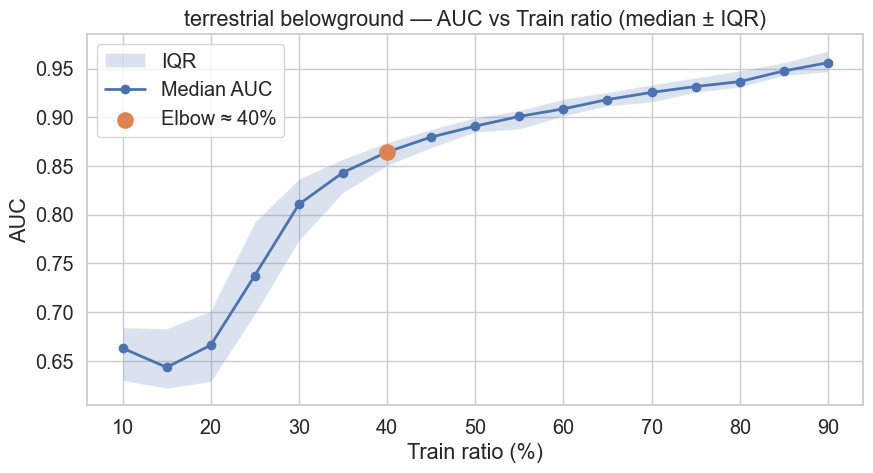

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Paths ---
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"
ecosystem_type = "terrestrial belowground"
score = "AUC"  # one of "AUC", "Precision", "Recall", "F1Score"

sns.set_theme(style="whitegrid", font_scale=1.3)

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

candidates = {
    "n_nodes","num_nodes","nodes","nodecount","n","s",
    "species","numspecies","numberofspecies","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = next((norm_map[k] for k in candidates if k in norm_map), None)
if node_col is None:
    raise RuntimeError("Could not find a node-count column in metadata (e.g. 'S', 'nodes').")

# --- Load result CSVs and stack ---
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# --- Merge results with ecosystem metadata once (no filter yet) ---
meta_cols = ["Foodweb", "ecosystem.type", node_col]
base = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# Helper: normalize TrainRatio to 0–100 scale regardless of how stored
def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# Long format for metrics
df_plot = base.melt(
    id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
    value_vars=["AUC", "Precision", "Recall", "F1Score"],
    var_name="Metric",
    value_name="Value"
)
# Normalize ratio to percent (handles 0–1 or 0–100 inputs)
df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])

ecosystem_score = df_plot[(df_plot["ecosystem.type"] == ecosystem_type) & (df_plot["Metric"] == score)].copy()

# Aggregate per ratio
g = (ecosystem_score.groupby("TrainRatio_pct")["Value"]
        .agg(n="count",
             q25=lambda s: s.quantile(0.25),
             median="median",
             q75=lambda s: s.quantile(0.75))
        .reset_index()
        .dropna(subset=["TrainRatio_pct"])
        .sort_values("TrainRatio_pct"))

if len(g) < 2:
    raise RuntimeError("Need at least two train ratios for an elbow plot.")

# Elbow/knee via max distance to the line connecting first/last point (on [0,1] box)
x = g["TrainRatio_pct"].to_numpy(dtype=float)
y = g["median"].to_numpy(dtype=float)

xn = (x - x.min()) / (x.max() - x.min() + 1e-12)
yn = (y - y.min()) / (y.max() - y.min() + 1e-12)

p0 = np.array([xn[0], yn[0]])
p1 = np.array([xn[-1], yn[-1]])
v = p1 - p0                         # shape (2,)
w = np.c_[xn, yn] - p0              # shape (n,2)

# 2D "cross product" magnitude: |v_x*w_y - v_y*w_x|
cross_mag = np.abs(v[0] * w[:, 1] - v[1] * w[:, 0])
dist = cross_mag / (np.hypot(v[0], v[1]) + 1e-12)

knee_i = int(dist.argmax())
knee_ratio, knee_auc = x[knee_i], y[knee_i]

# Plot
sns.set_theme(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(9, 5))
plt.fill_between(g["TrainRatio_pct"], g["q25"], g["q75"], alpha=0.2, label="IQR")
plt.plot(g["TrainRatio_pct"], g["median"], marker="o", linewidth=2, label=f"Median {score}")
plt.scatter([knee_ratio], [knee_auc], s=120, zorder=5, label=f"Elbow ≈ {knee_ratio:.0f}%")

plt.xlabel("Train ratio (%)")
plt.ylabel(f"{score}")
plt.title(f"{ecosystem_type} — {score} vs Train ratio (median ± IQR)")
plt.legend()
plt.tight_layout()
print(f"Elbow (knee) at ≈ {knee_ratio:.0f}% with median {score} ≈ {knee_auc:.3f}")
plt.show()

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Paths ---
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"
ecosystem_type = "terrestrial belowground"
score = "AUC"  # one of "AUC", "Precision", "Recall", "F1Score"

sns.set_theme(style="whitegrid", font_scale=1.3)

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

candidates = {
    "n_nodes","num_nodes","nodes","nodecount","n","s",
    "species","numspecies","numberofspecies","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = next((norm_map[k] for k in candidates if k in norm_map), None)
if node_col is None:
    raise RuntimeError("Could not find a node-count column in metadata (e.g. 'S', 'nodes').")

# --- Load result CSVs and stack ---
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# --- Merge results with ecosystem metadata once (no filter yet) ---
meta_cols = ["Foodweb", "ecosystem.type", node_col]
base = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# Helper: normalize TrainRatio to 0–100 scale regardless of how stored
def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# Long format for metrics
df_plot = base.melt(
    id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
    value_vars=["AUC", "Precision", "Recall", "F1Score"],
    var_name="Metric",
    value_name="Value"
)
# Normalize ratio to percent (handles 0–1 or 0–100 inputs)
df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])




import numpy as np
import pandas as pd

# Assumes you already built df_plot with columns:
# ["Foodweb", "TrainRatio", "ecosystem.type", "Iteration", "Metric", "Value"]
# and added df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])

# ---- Tunable policy knobs ----
EPS_BY_METRIC = {"AUC": 0.01, "Precision": 0.01, "Recall": 0.01, "F1Score": 0.01}
SLOPE_TAU     = 1e-3   # slope threshold in "score per percentage-point of train ratio"
IQR_KAPPA     = 0.05   # stability threshold (absolute score)

def _quad_fit(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    if len(x) < 2: 
        return None, None, None
    deg = 2 if len(x) >= 3 else 1
    coef = np.polyfit(x, y, deg=deg)
    # Evaluate on a dense grid for smoother slope detection
    xg = np.linspace(x.min(), x.max(), 200)
    yg = np.polyval(coef, xg)
    # Numerical derivative
    dy = np.gradient(yg, xg)
    return xg, yg, dy

def _epsilon_from_peak_rule(gmed, metric):
    # gmed: DataFrame with columns ["TrainRatio_pct","median"]
    eps = EPS_BY_METRIC.get(metric, 0.01)
    r_peak = gmed.loc[gmed["median"].idxmax(), "TrainRatio_pct"]
    peak   = gmed["median"].max()
    mask   = gmed["median"] >= (peak - eps)
    if not mask.any(): 
        return r_peak
    return float(gmed.loc[mask, "TrainRatio_pct"].min())

def _slope_plateau_rule(gmed):
    x = gmed["TrainRatio_pct"].to_numpy(float)
    y = gmed["median"].to_numpy(float)
    out = _quad_fit(x, y)
    if out[0] is None:
        return float(x.min())
    xg, yg, dy = out
    # First x where |slope| < SLOPE_TAU (post initial rise)
    # To avoid picking the left edge, look after the first quartile of xg
    start = int(0.25 * len(xg))
    mask  = np.abs(dy[start:]) < SLOPE_TAU
    if not mask.any():
        return float(x.max())
    return float(xg[start:][np.argmax(mask)])  # first point below tau

def _stability_rule(gstats):
    # gstats: DataFrame with ["TrainRatio_pct","iqr"]
    ok = gstats[gstats["iqr"] <= IQR_KAPPA]
    if ok.empty:
        return float(gstats["TrainRatio_pct"].max())  # never stable; pick the max as conservative
    return float(ok["TrainRatio_pct"].min())

def _summarise_group(df_group, metric):
    # df_group: rows for one ecosystem (or pooled) and one metric
    # Build per-ratio stats
    g = (df_group.groupby("TrainRatio_pct")["Value"]
            .agg(n="count",
                 q25=lambda s: s.quantile(0.25),
                 median="median",
                 q75=lambda s: s.quantile(0.75))
            .reset_index()
            .dropna(subset=["TrainRatio_pct"])
            .sort_values("TrainRatio_pct"))
    if len(g) < 2:
        return None  # insufficient points

    g["iqr"] = g["q75"] - g["q25"]

    r_eps   = _epsilon_from_peak_rule(g[["TrainRatio_pct","median"]], metric)
    r_slope = _slope_plateau_rule(g[["TrainRatio_pct","median"]])
    r_stab  = _stability_rule(g[["TrainRatio_pct","iqr"]])

    r_star  = max(r_eps, r_slope, r_stab)

    # Also report the peak for transparency
    idx_peak  = g["median"].idxmax()
    r_peak    = float(g.loc[idx_peak, "TrainRatio_pct"])
    peak_medi = float(g.loc[idx_peak, "median"])

    return {
        "r_eps":   r_eps,
        "r_slope": r_slope,
        "r_stab":  r_stab,
        "r_star":  r_star,
        "r_peak":  r_peak,
        "peak_median": peak_medi,
        "n_ratios": int(len(g))
    }

def compute_optimal_train_ratios(df_plot):
    rows = []
    for metric, dfm in df_plot.groupby("Metric"):
        # --- Per-ecosystem ---
        for eco, dfe in dfm.groupby("ecosystem.type"):
            res = _summarise_group(dfe, metric)
            if res is None: 
                continue
            rows.append({
                "level": "ecosystem",
                "group": eco,
                "Metric": metric,
                **res
            })
        # --- Pooled (median across ecosystems per ratio) ---
        # Build pooled median curve by ratio
        pooled = (dfm.groupby(["TrainRatio_pct","ecosystem.type"])["Value"].median()
                    .reset_index()
                    .groupby("TrainRatio_pct")["Value"].median()
                    .reset_index()
                    .rename(columns={"Value":"Value_median"}))
        pooled_expanded = pd.DataFrame({
            "TrainRatio_pct": pooled["TrainRatio_pct"],
            "Value": pooled["Value_median"]
        })
        res_pooled = _summarise_group(pooled_expanded.assign(**{"ecosystem.type":"ALL"}), metric)
        if res_pooled is not None:
            rows.append({
                "level": "pooled",
                "group": "ALL",
                "Metric": metric,
                **res_pooled
            })
    return pd.DataFrame(rows)

# === Run and inspect ===
optima = compute_optimal_train_ratios(df_plot)
# Sort: pooled first, then ecosystems, by metric
optima = optima.sort_values(["level","Metric","group"]).reset_index(drop=True)
display(optima)


level                    group     Metric  r_eps    r_slope  r_stab  \
0   ecosystem                    lakes        AUC   85.0  90.000000    85.0   
1   ecosystem                   marine        AUC   90.0  90.000000    90.0   
2   ecosystem                  streams        AUC   80.0  79.145729    90.0   
3   ecosystem  terrestrial aboveground        AUC   85.0  79.949749    90.0   
4   ecosystem  terrestrial belowground        AUC   85.0  71.909548    35.0   
5   ecosystem                    lakes    F1Score   85.0  90.000000    90.0   
6   ecosystem                   marine    F1Score   90.0  90.000000    90.0   
7   ecosystem                  streams    F1Score   90.0  90.000000    90.0   
8   ecosystem  terrestrial aboveground    F1Score   85.0  77.135678    90.0   
9   ecosystem  terrestrial belowground    F1Score   90.0  69.095477    35.0   
10  ecosystem                    lakes  Precision   85.0  90.000000    90.0   
11  ecosystem                   marine  Precision   85.0  90.000000    90.0   
12  ecosystem                  streams  Precision   90.0  70.301508    90.0   
13  ecosystem  terrestrial aboveground  Precision   90.0  90.000000    90.0   
14  ecosystem  terrestrial belowground  Precision   90.0  82.763819    20.0   
15  ecosystem                    lakes     Recall   90.0  90.000000    90.0   
16  ecosystem                   marine     Recall   90.0  90.000000    90.0   
17  ecosystem                  streams     Recall   80.0  90.000000    90.0   
18  ecosystem  terrestrial aboveground     Recall   80.0  90.000000    90.0   
19  ecosystem  terrestrial belowground     Recall   85.0  67.085427    50.0   
20     pooled                      ALL        AUC   85.0  73.115578    10.0   
21     pooled                      ALL    F1Score   90.0  90.000000    10.0   
22     pooled                      ALL  Precision   90.0  90.000000    10.0   
23     pooled                      ALL     Recall   85.0  90.000000    10.0   

    r_star  r_peak  peak_median  n_ratios  
0     90.0    90.0      0.99970        17  
1     90.0    90.0      0.93490        17  
2     90.0    90.0      0.94055        17  
3     90.0    90.0      0.98440        17  
4     85.0    90.0      0.95605        17  
5     90.0    85.0      0.97140        17  
6     90.0    90.0      0.88890        17  
7     90.0    90.0      0.89950        17  
8     90.0    85.0      0.94710        17  
9     90.0    90.0      0.90140        17  
10    90.0    85.0      1.00000        17  
11    90.0    90.0      0.90910        17  
12    90.0    90.0      0.91780        17  
13    90.0    90.0      0.97600        17  
14    90.0    90.0      0.87500        17  
15    90.0    90.0      1.00000        17  
16    90.0    90.0      0.90160        17  
17    90.0    80.0      0.91185        17  
18    90.0    80.0      0.97920        17  
19    85.0    90.0      0.93380        17  
20    85.0    90.0      0.95605        17  
21    90.0    90.0      0.90140        17  
22    90.0    90.0      0.91780        17  
23    90.0    90.0      0.93380        17

Elbow (knee) at ≈ 45% with median AUC ≈ 0.857


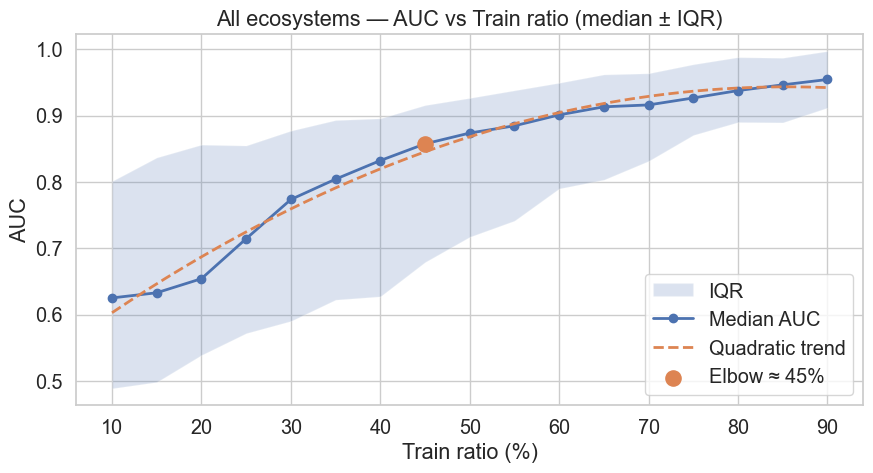

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Paths ---
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"
ecosystem_type = "ALL"  # or "ALL" for all ecosystems
score = "AUC"  # one of "AUC", "Precision", "Recall", "F1Score"

sns.set_theme(style="whitegrid", font_scale=1.3)

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

candidates = {
    "n_nodes","num_nodes","nodes","nodecount","n","s",
    "species","numspecies","numberofspecies","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = next((norm_map[k] for k in candidates if k in norm_map), None)
if node_col is None:
    raise RuntimeError("Could not find a node-count column in metadata (e.g. 'S', 'nodes').")

# --- Load result CSVs and stack ---
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# --- Merge results with ecosystem metadata once (no filter yet) ---
meta_cols = ["Foodweb", "ecosystem.type", node_col]
base = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# Helper: normalize TrainRatio to 0–100 scale regardless of how stored
def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# Long format for metrics
df_plot = base.melt(
    id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
    value_vars=["AUC", "Precision", "Recall", "F1Score"],
    var_name="Metric",
    value_name="Value"
)
# Normalize ratio to percent (handles 0–1 or 0–100 inputs)
df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])

# --- Filter for ecosystem and metric (supports "ALL") ---
if isinstance(ecosystem_type, str) and ecosystem_type.strip().lower() == "all":
    mask = (df_plot["Metric"] == score)
    eco_label = "All ecosystems"
else:
    mask = (df_plot["ecosystem.type"] == ecosystem_type) & (df_plot["Metric"] == score)
    eco_label = ecosystem_type

ecosystem_score = df_plot[mask].copy()

# Aggregate per ratio
g = (ecosystem_score.groupby("TrainRatio_pct")["Value"]
        .agg(n="count",
             q25=lambda s: s.quantile(0.25),
             median="median",
             q75=lambda s: s.quantile(0.75))
        .reset_index()
        .dropna(subset=["TrainRatio_pct"])
        .sort_values("TrainRatio_pct"))

if len(g) < 2:
    raise RuntimeError("Need at least two train ratios for an elbow plot.")

# Elbow/knee via max distance to the line connecting first/last point (on [0,1] box)
x = g["TrainRatio_pct"].to_numpy(dtype=float)
y = g["median"].to_numpy(dtype=float)

xn = (x - x.min()) / (x.max() - x.min() + 1e-12)
yn = (y - y.min()) / (y.max() - y.min() + 1e-12)

p0 = np.array([xn[0], yn[0]])
p1 = np.array([xn[-1], yn[-1]])
v = p1 - p0
w = np.c_[xn, yn] - p0

cross_mag = np.abs(v[0] * w[:, 1] - v[1] * w[:, 0])
dist = cross_mag / (np.hypot(v[0], v[1]) + 1e-12)

knee_i = int(dist.argmax())
knee_ratio, knee_auc = x[knee_i], y[knee_i]

# --- Trend line (LOWESS if available; else polynomial fallback) ---
use_lowess = False
try:
    import statsmodels.api as sm  # optional, for nice smoothing
    use_lowess = True
except Exception:
    use_lowess = False

x_pred = np.linspace(x.min(), x.max(), 200)

if use_lowess:
    # LOWESS smoothing over median-by-ratio curve
    lowess = sm.nonparametric.lowess
    smoothed = lowess(y, x, frac=0.6, it=0, return_sorted=True)
    x_trend = smoothed[:, 0]
    y_trend = smoothed[:, 1]
    trend_label = "LOWESS trend"
else:
    # Polynomial fit fallback (deg 2; deg 1 if few points)
    deg = 2 if len(x) >= 3 else 1
    coeffs = np.polyfit(x, y, deg=deg)
    y_trend = np.polyval(coeffs, x_pred)
    x_trend = x_pred
    trend_label = f"{'Quadratic' if deg==2 else 'Linear'} trend"

# Plot
sns.set_theme(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(9, 5))
plt.fill_between(g["TrainRatio_pct"], g["q25"], g["q75"], alpha=0.2, label="IQR")
plt.plot(g["TrainRatio_pct"], g["median"], marker="o", linewidth=2, label=f"Median {score}")
plt.plot(x_trend, y_trend, linestyle="--", linewidth=2, label=trend_label)
plt.scatter([knee_ratio], [knee_auc], s=120, zorder=5, label=f"Elbow ≈ {knee_ratio:.0f}%")

plt.xlabel("Train ratio (%)")
plt.ylabel(f"{score}")
plt.title(f"{eco_label} — {score} vs Train ratio (median ± IQR)")
plt.legend()
plt.tight_layout()
print(f"Elbow (knee) at ≈ {knee_ratio:.0f}% with median {score} ≈ {knee_auc:.3f}")
plt.show()

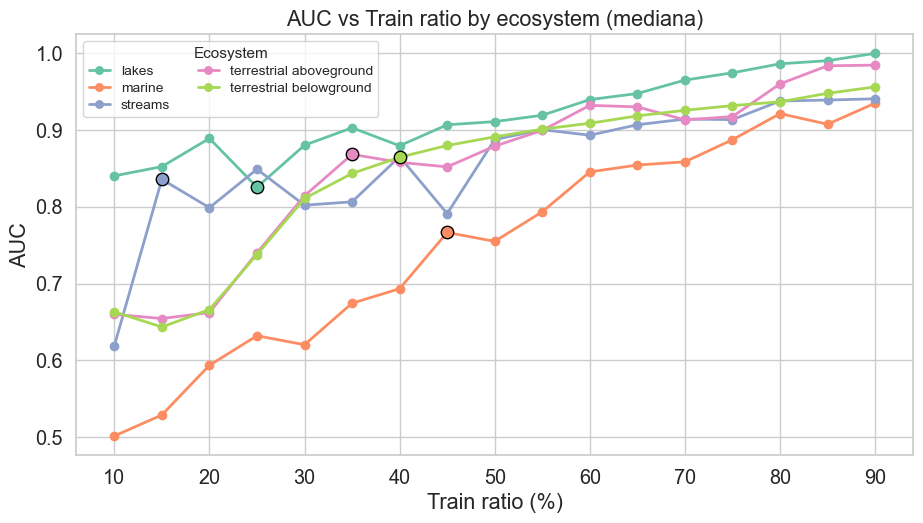

Ecosystem  Elbow train ratio (%)  Elbow median AUC
0                    lakes                   25.0           0.82540
1                   marine                   45.0           0.76645
2                  streams                   15.0           0.83570
3  terrestrial aboveground                   35.0           0.86820
4  terrestrial belowground                   40.0           0.86440

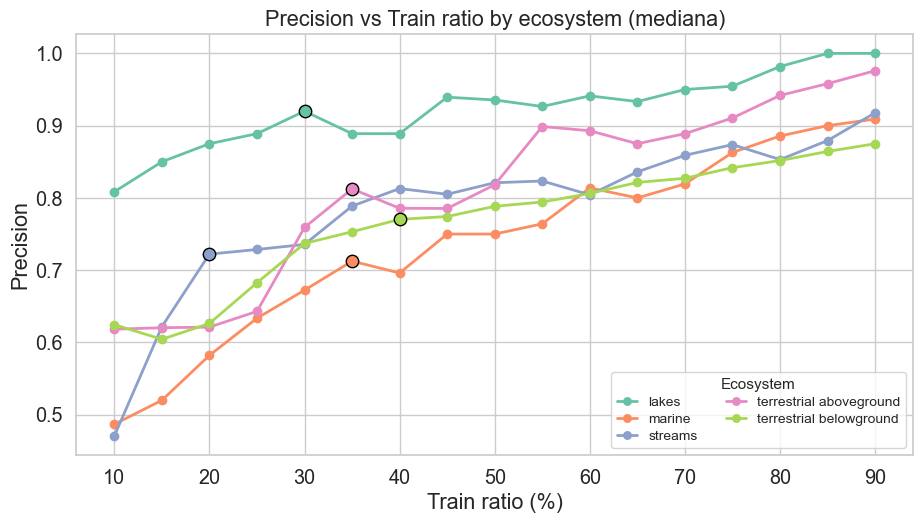

Ecosystem  Elbow train ratio (%)  Elbow median Precision
0                    lakes                   30.0                 0.92000
1                   marine                   35.0                 0.71255
2                  streams                   20.0                 0.72225
3  terrestrial aboveground                   35.0                 0.81250
4  terrestrial belowground                   40.0                 0.77035

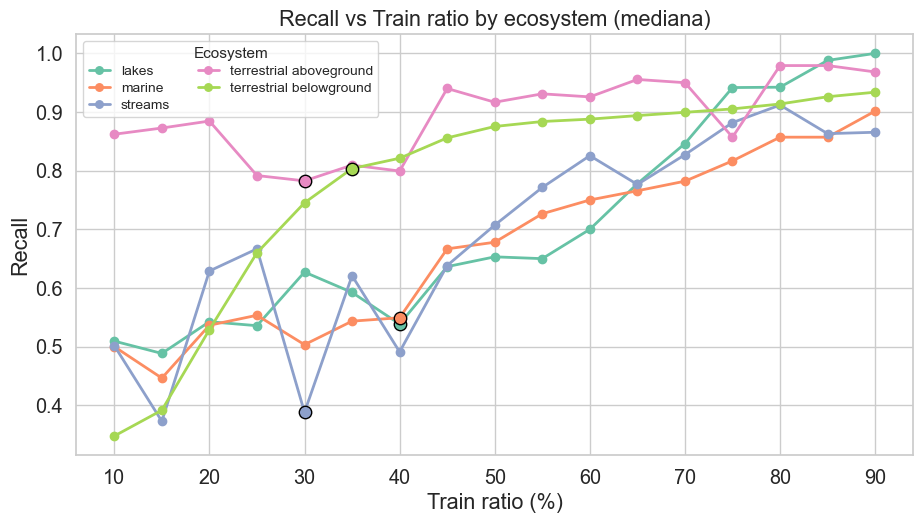

Ecosystem  Elbow train ratio (%)  Elbow median Recall
0                    lakes                   40.0              0.53850
1                   marine                   40.0              0.54925
2                  streams                   30.0              0.38810
3  terrestrial aboveground                   30.0              0.78260
4  terrestrial belowground                   35.0              0.80365

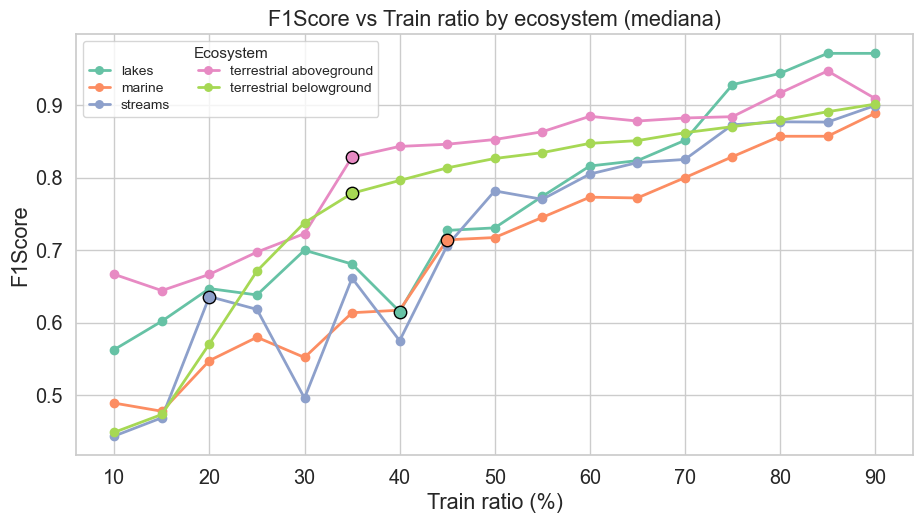

Ecosystem  Elbow train ratio (%)  Elbow median F1Score
0                    lakes                   40.0                0.6154
1                   marine                   45.0                0.7143
2                  streams                   20.0                0.6361
3  terrestrial aboveground                   35.0                0.8285
4  terrestrial belowground                   35.0                0.7785

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set_theme(style="whitegrid", font_scale=1.25)

# --- Paths ---
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"

sns.set_theme(style="whitegrid", font_scale=1.3)

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

candidates = {
    "n_nodes","num_nodes","nodes","nodecount","n","s",
    "species","numspecies","numberofspecies","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = next((norm_map[k] for k in candidates if k in norm_map), None)
if node_col is None:
    raise RuntimeError("Could not find a node-count column in metadata (e.g. 'S', 'nodes').")

# --- Load result CSVs and stack ---
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# --- Merge results with ecosystem metadata once (no filter yet) ---
meta_cols = ["Foodweb", "ecosystem.type", node_col]
base = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# Helper: normalize TrainRatio to 0–100 scale regardless of how stored
def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# Long format for metrics
df_plot = base.melt(
    id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
    value_vars=["AUC", "Precision", "Recall", "F1Score"],
    var_name="Metric",
    value_name="Value"
)
# Normalize ratio to percent (handles 0–1 or 0–100 inputs)
df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])

# Asegurar que TrainRatio_pct sea numérico y estable
dfp = df_plot.copy()
dfp["TrainRatio_pct"] = pd.to_numeric(dfp["TrainRatio_pct"], errors="coerce").round(2)

# Colores fijos por ecosistema
ecosystems = sorted(dfp["ecosystem.type"].dropna().unique().tolist())
palette = sns.color_palette("Set2", n_colors=len(ecosystems))
color_map = dict(zip(ecosystems, palette))

def agg_by_metric(metric: str) -> pd.DataFrame:
    m = dfp[dfp["Metric"] == metric].copy()
    out = (m.groupby(["ecosystem.type", "TrainRatio_pct"])["Value"]
             .median()
             .reset_index()
             .dropna(subset=["TrainRatio_pct"])
             .sort_values(["ecosystem.type", "TrainRatio_pct"]))
    return out

def elbows_for_metric(agg: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for eco, geco in agg.groupby("ecosystem.type"):
        x = geco["TrainRatio_pct"].to_numpy(float)
        y = geco["Value"].to_numpy(float)
        if len(geco) < 2:
            continue
        # “codo” = punto con mayor distancia a la cuerda entre los extremos
        xn = (x - x.min()) / (x.max() - x.min() + 1e-12)
        yn = (y - y.min()) / (y.max() - y.min() + 1e-12)
        p0 = np.array([xn[0], yn[0]])
        p1 = np.array([xn[-1], yn[-1]])
        v  = p1 - p0
        w  = np.c_[xn, yn] - p0
        cross_mag = np.abs(v[0]*w[:,1] - v[1]*w[:,0])
        dist = cross_mag / (np.hypot(v[0], v[1]) + 1e-12)
        k = int(dist.argmax())
        rows.append({"ecosystem.type": eco, "TrainRatio_pct": x[k], "score": y[k]})
    return pd.DataFrame(rows)

for metric in ["AUC", "Precision", "Recall", "F1Score"]:
    agg = agg_by_metric(metric)
    elbows = elbows_for_metric(agg)

    plt.figure(figsize=(9.5, 5.5))
    for eco, geco in agg.groupby("ecosystem.type"):
        plt.plot(geco["TrainRatio_pct"], geco["Value"],
                 marker="o", linewidth=2, color=color_map[eco], label=eco)

    if not elbows.empty:
        for _, r in elbows.iterrows():
            plt.scatter(r["TrainRatio_pct"], r["score"], s=80,
                        color=color_map[r["ecosystem.type"]], edgecolor="black", zorder=5)

    plt.xlabel("Train ratio (%)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Train ratio by ecosystem (mediana)")
    # leyenda compacta por figura
    plt.legend(title="Ecosystem", ncol=2, fontsize=10, title_fontsize=11,
               handlelength=1.5, markerscale=0.9, labelspacing=0.3, frameon=True)
    plt.tight_layout()
    plt.show()

    if not elbows.empty:
        display(elbows.sort_values(["ecosystem.type","TrainRatio_pct"])
                      .rename(columns={"ecosystem.type":"Ecosystem",
                                       "TrainRatio_pct":"Elbow train ratio (%)",
                                       "score":f"Elbow median {metric}"})
                      .reset_index(drop=True))

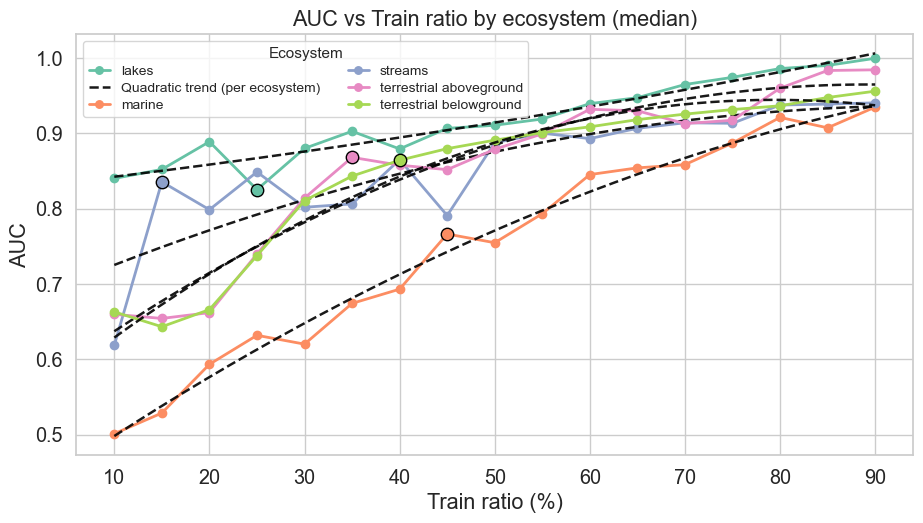

Ecosystem  Elbow train ratio (%)  Elbow median AUC
0                    lakes                   25.0           0.82540
1                   marine                   45.0           0.76645
2                  streams                   15.0           0.83570
3  terrestrial aboveground                   35.0           0.86820
4  terrestrial belowground                   40.0           0.86440

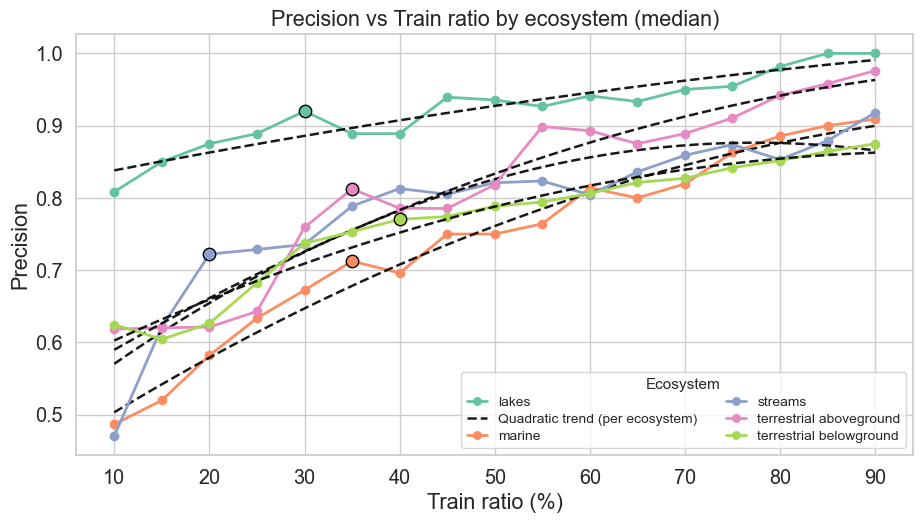

Ecosystem  Elbow train ratio (%)  Elbow median Precision
0                    lakes                   30.0                 0.92000
1                   marine                   35.0                 0.71255
2                  streams                   20.0                 0.72225
3  terrestrial aboveground                   35.0                 0.81250
4  terrestrial belowground                   40.0                 0.77035

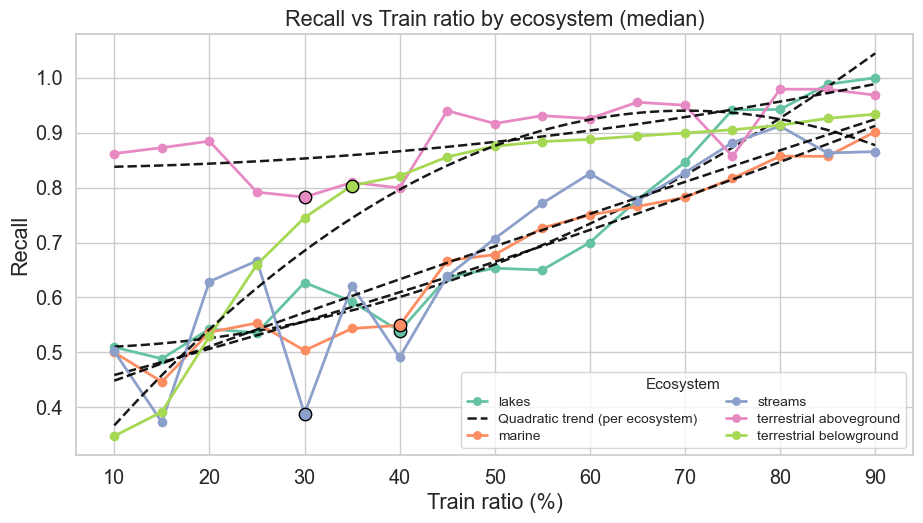

Ecosystem  Elbow train ratio (%)  Elbow median Recall
0                    lakes                   40.0              0.53850
1                   marine                   40.0              0.54925
2                  streams                   30.0              0.38810
3  terrestrial aboveground                   30.0              0.78260
4  terrestrial belowground                   35.0              0.80365

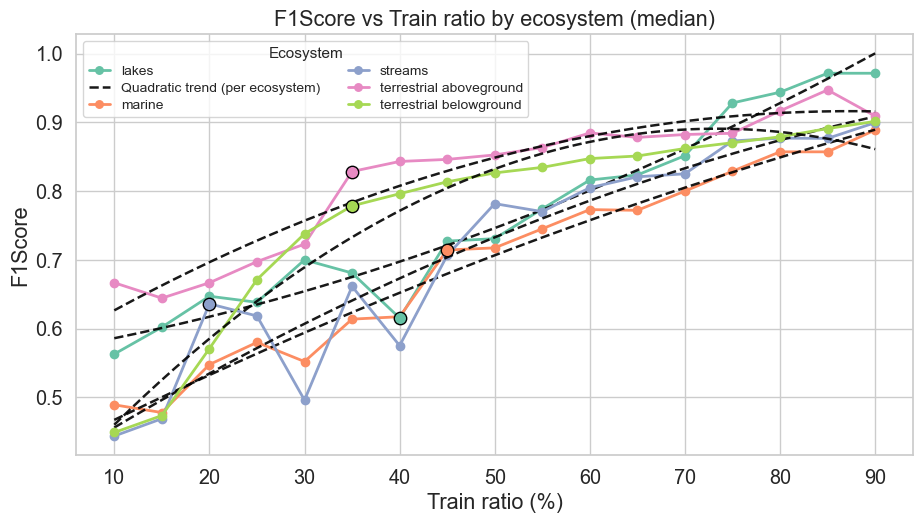

Ecosystem  Elbow train ratio (%)  Elbow median F1Score
0                    lakes                   40.0                0.6154
1                   marine                   45.0                0.7143
2                  streams                   20.0                0.6361
3  terrestrial aboveground                   35.0                0.8285
4  terrestrial belowground                   35.0                0.7785

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.lines import Line2D

sns.set_theme(style="whitegrid", font_scale=1.25)

# --- Paths ---
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"

sns.set_theme(style="whitegrid", font_scale=1.3)

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

candidates = {
    "n_nodes","num_nodes","nodes","nodecount","n","s",
    "species","numspecies","numberofspecies","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = next((norm_map[k] for k in candidates if k in norm_map), None)
if node_col is None:
    raise RuntimeError("Could not find a node-count column in metadata (e.g. 'S', 'nodes').")

# --- Load result CSVs and stack ---
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# --- Merge results with ecosystem metadata once (no filter yet) ---
meta_cols = ["Foodweb", "ecosystem.type", node_col]
base = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# Helper: normalize TrainRatio to 0–100 scale regardless of how stored
def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# Long format for metrics
df_plot = base.melt(
    id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
    value_vars=["AUC", "Precision", "Recall", "F1Score"],
    var_name="Metric",
    value_name="Value"
)
# Normalize ratio to percent (handles 0–1 or 0–100 inputs)
df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])

# Asegurar que TrainRatio_pct sea numérico y estable
dfp = df_plot.copy()
dfp["TrainRatio_pct"] = pd.to_numeric(dfp["TrainRatio_pct"], errors="coerce").round(2)

# Colores fijos por ecosistema
ecosystems = sorted(dfp["ecosystem.type"].dropna().unique().tolist())
palette = sns.color_palette("Set2", n_colors=len(ecosystems))
color_map = dict(zip(ecosystems, palette))

def agg_by_metric(metric: str) -> pd.DataFrame:
    m = dfp[dfp["Metric"] == metric].copy()
    out = (m.groupby(["ecosystem.type", "TrainRatio_pct"])["Value"]
             .median()
             .reset_index()
             .dropna(subset=["TrainRatio_pct"])
             .sort_values(["ecosystem.type", "TrainRatio_pct"]))
    return out

def elbows_for_metric(agg: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for eco, geco in agg.groupby("ecosystem.type"):
        x = geco["TrainRatio_pct"].to_numpy(float)
        y = geco["Value"].to_numpy(float)
        if len(geco) < 2:
            continue
        # “codo” = punto con mayor distancia a la cuerda entre los extremos
        xn = (x - x.min()) / (x.max() - x.min() + 1e-12)
        yn = (y - y.min()) / (y.max() - y.min() + 1e-12)
        p0 = np.array([xn[0], yn[0]])
        p1 = np.array([xn[-1], yn[-1]])
        v  = p1 - p0
        w  = np.c_[xn, yn] - p0
        cross_mag = np.abs(v[0]*w[:,1] - v[1]*w[:,0])
        dist = cross_mag / (np.hypot(v[0], v[1]) + 1e-12)
        k = int(dist.argmax())
        rows.append({"ecosystem.type": eco, "TrainRatio_pct": x[k], "score": y[k]})
    return pd.DataFrame(rows)

# --- Quadratic trend helper (falls back to linear if <3 pts) ---
def quadratic_trend(x: np.ndarray, y: np.ndarray):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) < 2:
        return None, None
    deg = 2 if len(x) >= 3 else 1
    coeffs = np.polyfit(x, y, deg=deg)
    x_pred = np.linspace(x.min(), x.max(), 200)
    y_pred = np.polyval(coeffs, x_pred)
    return x_pred, y_pred

for metric in ["AUC", "Precision", "Recall", "F1Score"]:
    agg = agg_by_metric(metric)
    elbows = elbows_for_metric(agg)

    plt.figure(figsize=(9.5, 5.5))
    trend_label_added = False

    # Curvas por ecosistema + tendencia cuadrática negra punteada
    for eco, geco in agg.groupby("ecosystem.type"):
        # Línea de mediana por ecosistema (color)
        plt.plot(geco["TrainRatio_pct"], geco["Value"],
                 marker="o", linewidth=2, color=color_map[eco], label=eco)

        # Tendencia cuadrática por ecosistema (negra y punteada)
        x = geco["TrainRatio_pct"].to_numpy(float)
        y = geco["Value"].to_numpy(float)
        x_pred, y_pred = quadratic_trend(x, y)
        if x_pred is not None:
            if not trend_label_added:
                plt.plot(x_pred, y_pred, linestyle="--", color="black", linewidth=1.8, alpha=0.9,
                         label="Quadratic trend (per ecosystem)")
                trend_label_added = True
            else:
                plt.plot(x_pred, y_pred, linestyle="--", color="black", linewidth=1.8, alpha=0.9)

    # Puntos de “codo”
    if not elbows.empty:
        for _, r in elbows.iterrows():
            plt.scatter(r["TrainRatio_pct"], r["score"], s=80,
                        color=color_map[r["ecosystem.type"]], edgecolor="black", zorder=5)

    plt.xlabel("Train ratio (%)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Train ratio by ecosystem (median)")

    # Leyenda compacta por figura con entrada única para la tendencia
    handles, labels = plt.gca().get_legend_handles_labels()
    # Asegurar una entrada genérica para la línea de tendencia si no fue añadida por falta de datos
    if not trend_label_added:
        handles.append(Line2D([0], [0], linestyle="--", color="black", linewidth=1.8))
        labels.append("Quadratic trend (per ecosystem)")

    plt.legend(handles, labels, title="Ecosystem", ncol=2, fontsize=10, title_fontsize=11,
               handlelength=1.5, markerscale=0.9, labelspacing=0.3, frameon=True)
    plt.tight_layout()
    plt.show()

    if not elbows.empty:
        display(elbows.sort_values(["ecosystem.type","TrainRatio_pct"])
                      .rename(columns={"ecosystem.type":"Ecosystem",
                                       "TrainRatio_pct":"Elbow train ratio (%)",
                                       "score":f"Elbow median {metric}"})
                      .reset_index(drop=True))

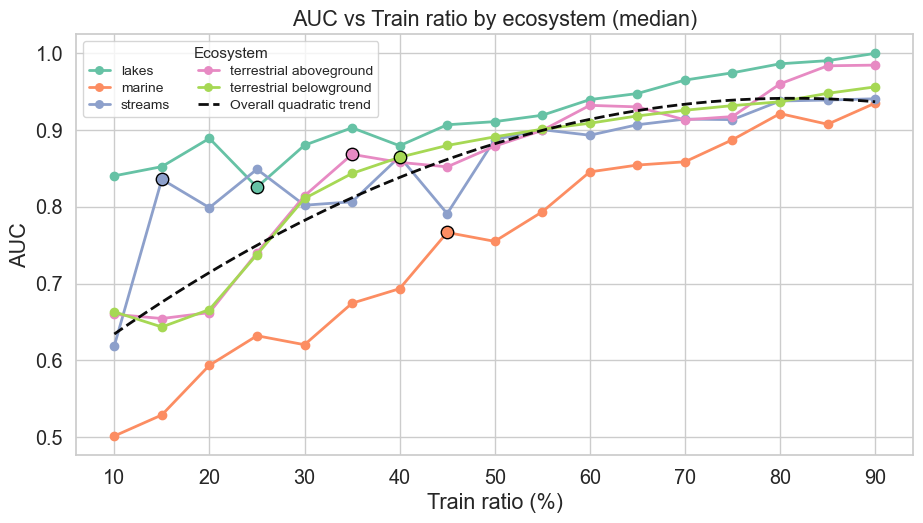

Ecosystem  Elbow train ratio (%)  Elbow median AUC
0                    lakes                   25.0           0.82540
1                   marine                   45.0           0.76645
2                  streams                   15.0           0.83570
3  terrestrial aboveground                   35.0           0.86820
4  terrestrial belowground                   40.0           0.86440

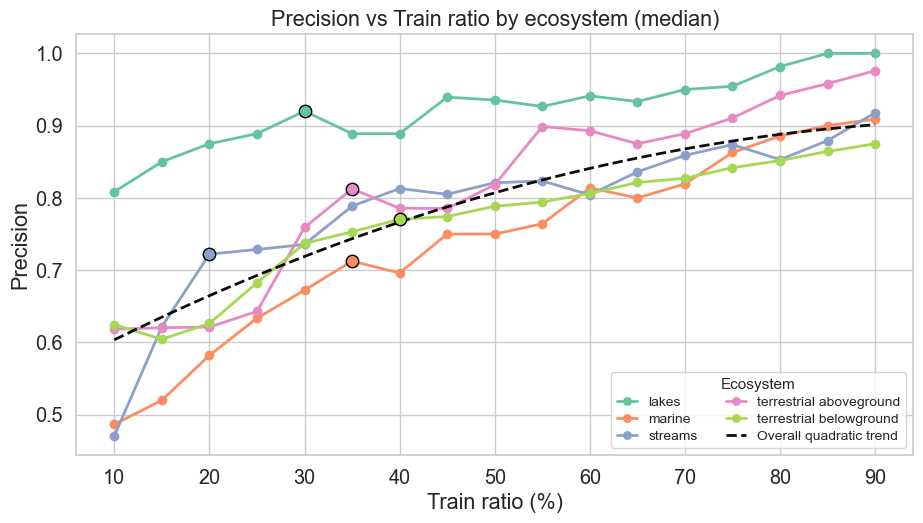

Ecosystem  Elbow train ratio (%)  Elbow median Precision
0                    lakes                   30.0                 0.92000
1                   marine                   35.0                 0.71255
2                  streams                   20.0                 0.72225
3  terrestrial aboveground                   35.0                 0.81250
4  terrestrial belowground                   40.0                 0.77035

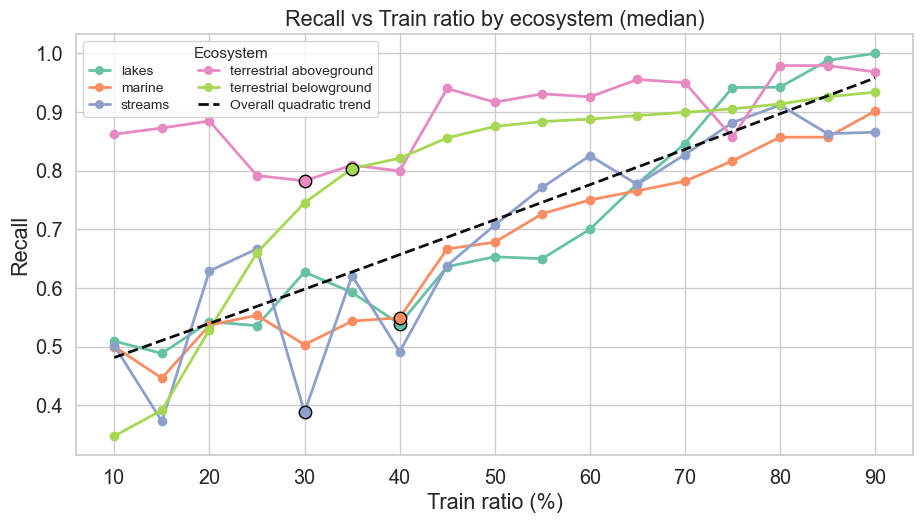

Ecosystem  Elbow train ratio (%)  Elbow median Recall
0                    lakes                   40.0              0.53850
1                   marine                   40.0              0.54925
2                  streams                   30.0              0.38810
3  terrestrial aboveground                   30.0              0.78260
4  terrestrial belowground                   35.0              0.80365

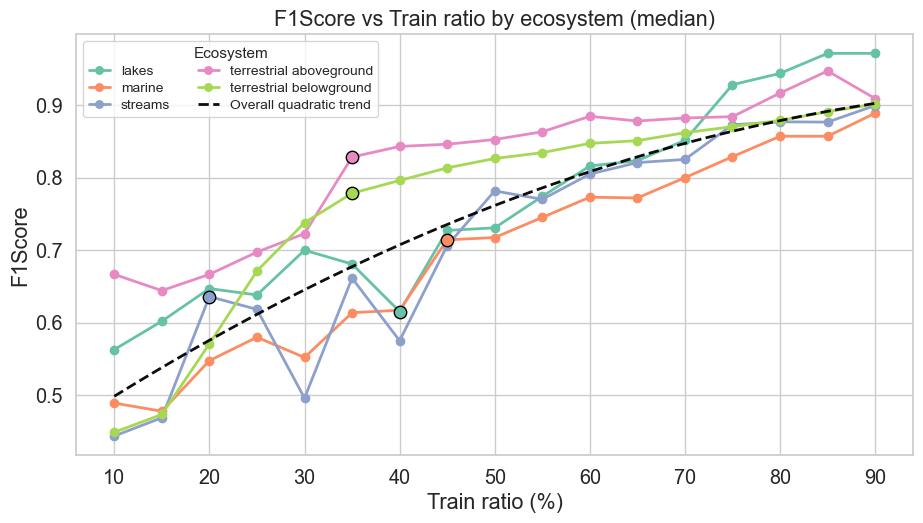

Ecosystem  Elbow train ratio (%)  Elbow median F1Score
0                    lakes                   40.0                0.6154
1                   marine                   45.0                0.7143
2                  streams                   20.0                0.6361
3  terrestrial aboveground                   35.0                0.8285
4  terrestrial belowground                   35.0                0.7785

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.lines import Line2D

sns.set_theme(style="whitegrid", font_scale=1.25)

# --- Paths ---
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"

sns.set_theme(style="whitegrid", font_scale=1.3)

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

candidates = {
    "n_nodes","num_nodes","nodes","nodecount","n","s",
    "species","numspecies","numberofspecies","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = next((norm_map[k] for k in candidates if k in norm_map), None)
if node_col is None:
    raise RuntimeError("Could not find a node-count column in metadata (e.g. 'S', 'nodes').")

# --- Load result CSVs and stack ---
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# --- Merge results with ecosystem metadata once (no filter yet) ---
meta_cols = ["Foodweb", "ecosystem.type", node_col]
base = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# Helper: normalize TrainRatio to 0–100 scale regardless of how stored
def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# Long format for metrics
df_plot = base.melt(
    id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
    value_vars=["AUC", "Precision", "Recall", "F1Score"],
    var_name="Metric",
    value_name="Value"
)
# Normalize ratio to percent (handles 0–1 or 0–100 inputs)
df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])

# Asegurar que TrainRatio_pct sea numérico y estable
dfp = df_plot.copy()
dfp["TrainRatio_pct"] = pd.to_numeric(dfp["TrainRatio_pct"], errors="coerce").round(2)

# Colores fijos por ecosistema
ecosystems = sorted(dfp["ecosystem.type"].dropna().unique().tolist())
palette = sns.color_palette("Set2", n_colors=len(ecosystems))
color_map = dict(zip(ecosystems, palette))

def agg_by_metric(metric: str) -> pd.DataFrame:
    m = dfp[dfp["Metric"] == metric].copy()
    out = (m.groupby(["ecosystem.type", "TrainRatio_pct"])["Value"]
             .median()
             .reset_index()
             .dropna(subset=["TrainRatio_pct"])
             .sort_values(["ecosystem.type", "TrainRatio_pct"]))
    return out

def elbows_for_metric(agg: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for eco, geco in agg.groupby("ecosystem.type"):
        x = geco["TrainRatio_pct"].to_numpy(float)
        y = geco["Value"].to_numpy(float)
        if len(geco) < 2:
            continue
        # “codo” = punto con mayor distancia a la cuerda entre los extremos
        xn = (x - x.min()) / (x.max() - x.min() + 1e-12)
        yn = (y - y.min()) / (y.max() - y.min() + 1e-12)
        p0 = np.array([xn[0], yn[0]])
        p1 = np.array([xn[-1], yn[-1]])
        v  = p1 - p0
        w  = np.c_[xn, yn] - p0
        cross_mag = np.abs(v[0]*w[:,1] - v[1]*w[:,0])
        dist = cross_mag / (np.hypot(v[0], v[1]) + 1e-12)
        k = int(dist.argmax())
        rows.append({"ecosystem.type": eco, "TrainRatio_pct": x[k], "score": y[k]})
    return pd.DataFrame(rows)

# --- Quadratic trend helper (falls back to linear if <3 pts) ---
def quadratic_trend(x: np.ndarray, y: np.ndarray):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) < 2:
        return None, None
    deg = 2 if len(x) >= 3 else 1
    coeffs = np.polyfit(x, y, deg=deg)
    x_pred = np.linspace(x.min(), x.max(), 200)
    y_pred = np.polyval(coeffs, x_pred)
    return x_pred, y_pred

for metric in ["AUC", "Precision", "Recall", "F1Score"]:
    agg = agg_by_metric(metric)
    elbows = elbows_for_metric(agg)

    plt.figure(figsize=(9.5, 5.5))

    # Curvas por ecosistema (medianas coloreadas)
    for eco, geco in agg.groupby("ecosystem.type"):
        plt.plot(geco["TrainRatio_pct"], geco["Value"],
                 marker="o", linewidth=2, color=color_map[eco], label=eco)

    # === ÚNICA tendencia global (negra, punteada) ===
    # Igualamos el peso por ecosistema: primero ya tomamos la mediana por ecosistema y ratio (agg),
    # ahora promediamos/medianeamos entre ecosistemas por cada ratio.
    pooled = (agg.groupby("TrainRatio_pct")["Value"]
                 .median()  # robust across ecosystems
                 .reset_index()
                 .sort_values("TrainRatio_pct"))

    x_all = pooled["TrainRatio_pct"].to_numpy(float)
    y_all = pooled["Value"].to_numpy(float)
    x_pred_all, y_pred_all = quadratic_trend(x_all, y_all)
    if x_pred_all is not None:
        plt.plot(x_pred_all, y_pred_all, linestyle="--", color="black",
                 linewidth=2.0, alpha=0.95, label="Overall quadratic trend")

    # Puntos de “codo” por ecosistema
    if not elbows.empty:
        for _, r in elbows.iterrows():
            plt.scatter(r["TrainRatio_pct"], r["score"], s=80,
                        color=color_map[r["ecosystem.type"]], edgecolor="black", zorder=5)

    plt.xlabel("Train ratio (%)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Train ratio by ecosystem (median)")

    # Leyenda compacta
    plt.legend(title="Ecosystem", ncol=2, fontsize=10, title_fontsize=11,
               handlelength=1.5, markerscale=0.9, labelspacing=0.3, frameon=True)
    plt.tight_layout()
    plt.show()

    if not elbows.empty:
        display(elbows.sort_values(["ecosystem.type","TrainRatio_pct"])
                      .rename(columns={"ecosystem.type":"Ecosystem",
                                       "TrainRatio_pct":"Elbow train ratio (%)",
                                       "score":f"Elbow median {metric}"})
                      .reset_index(drop=True))

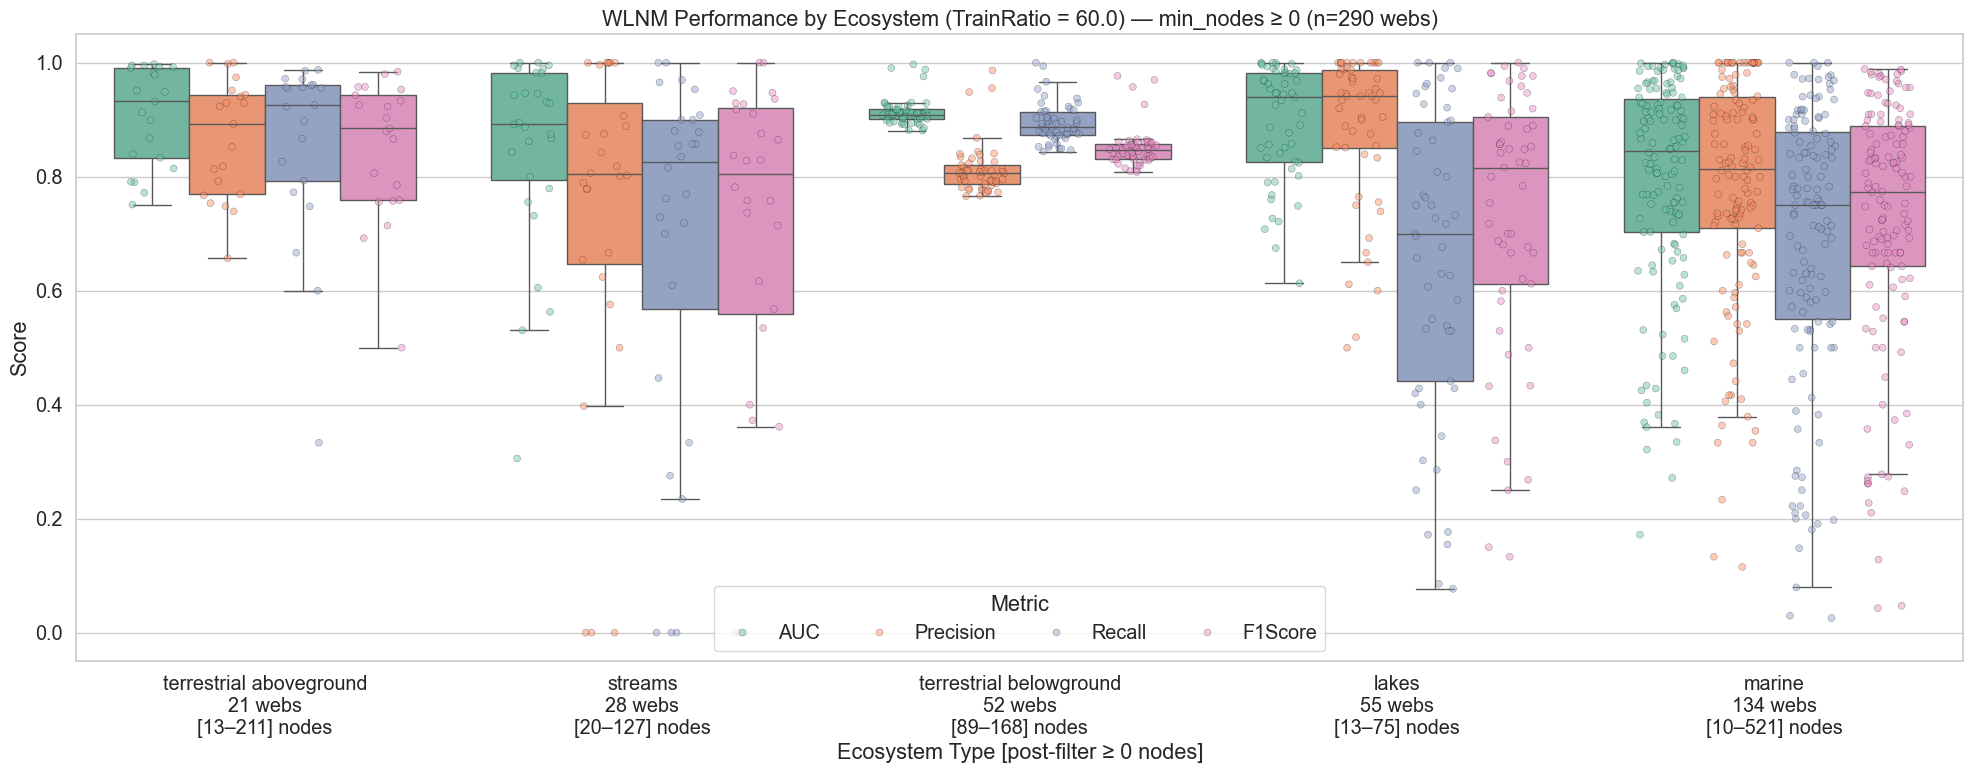

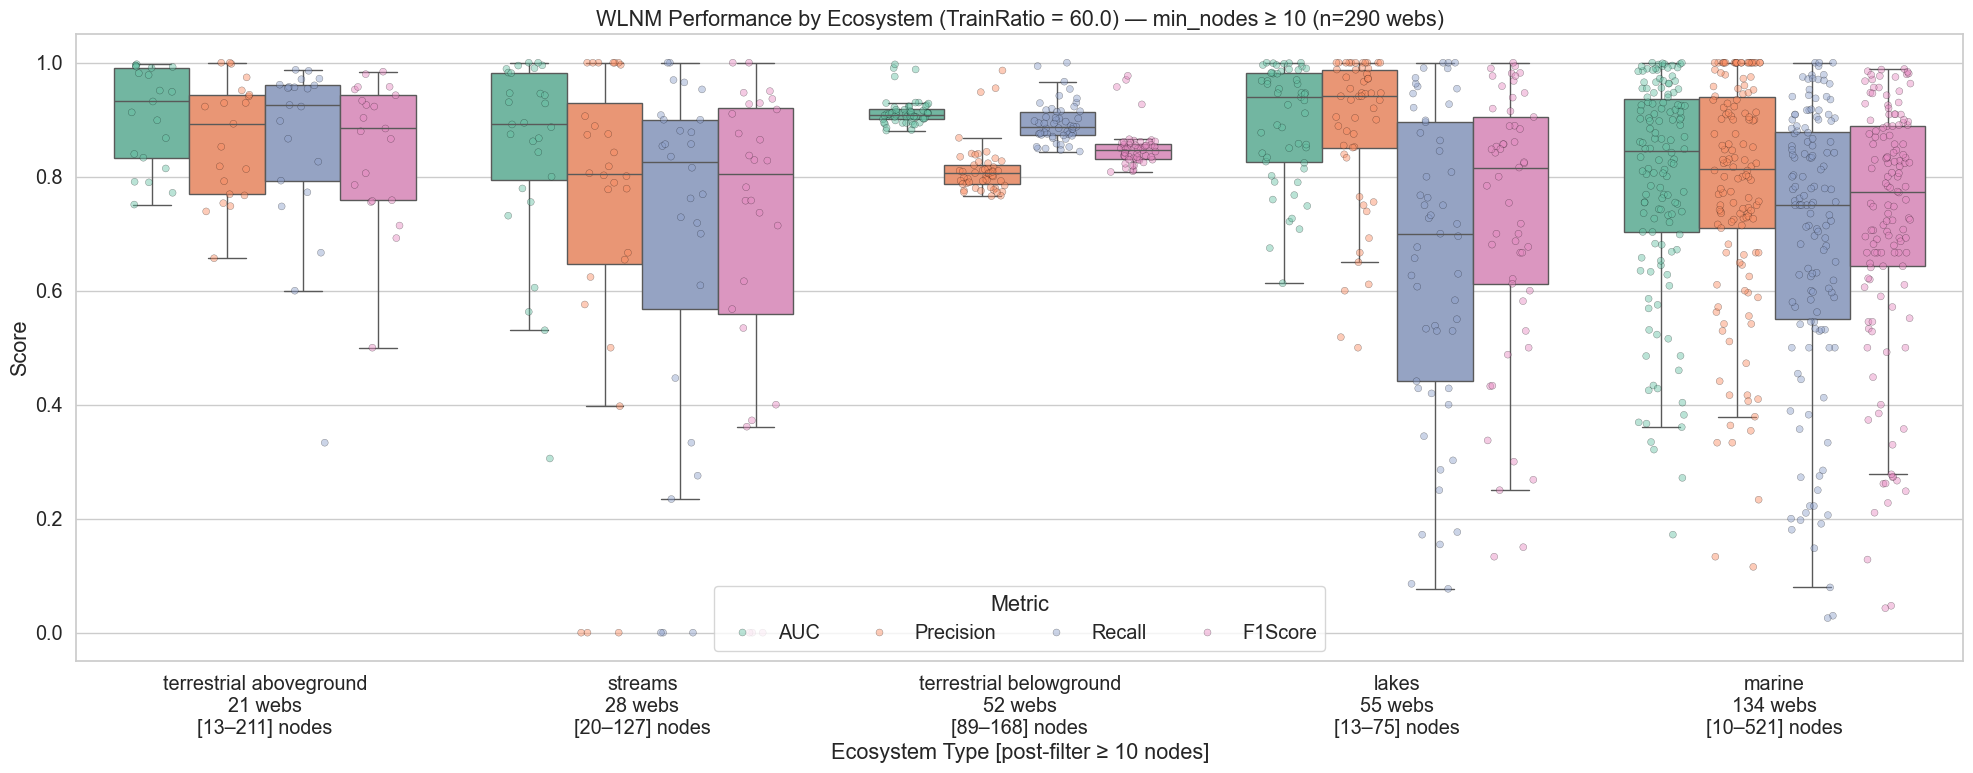

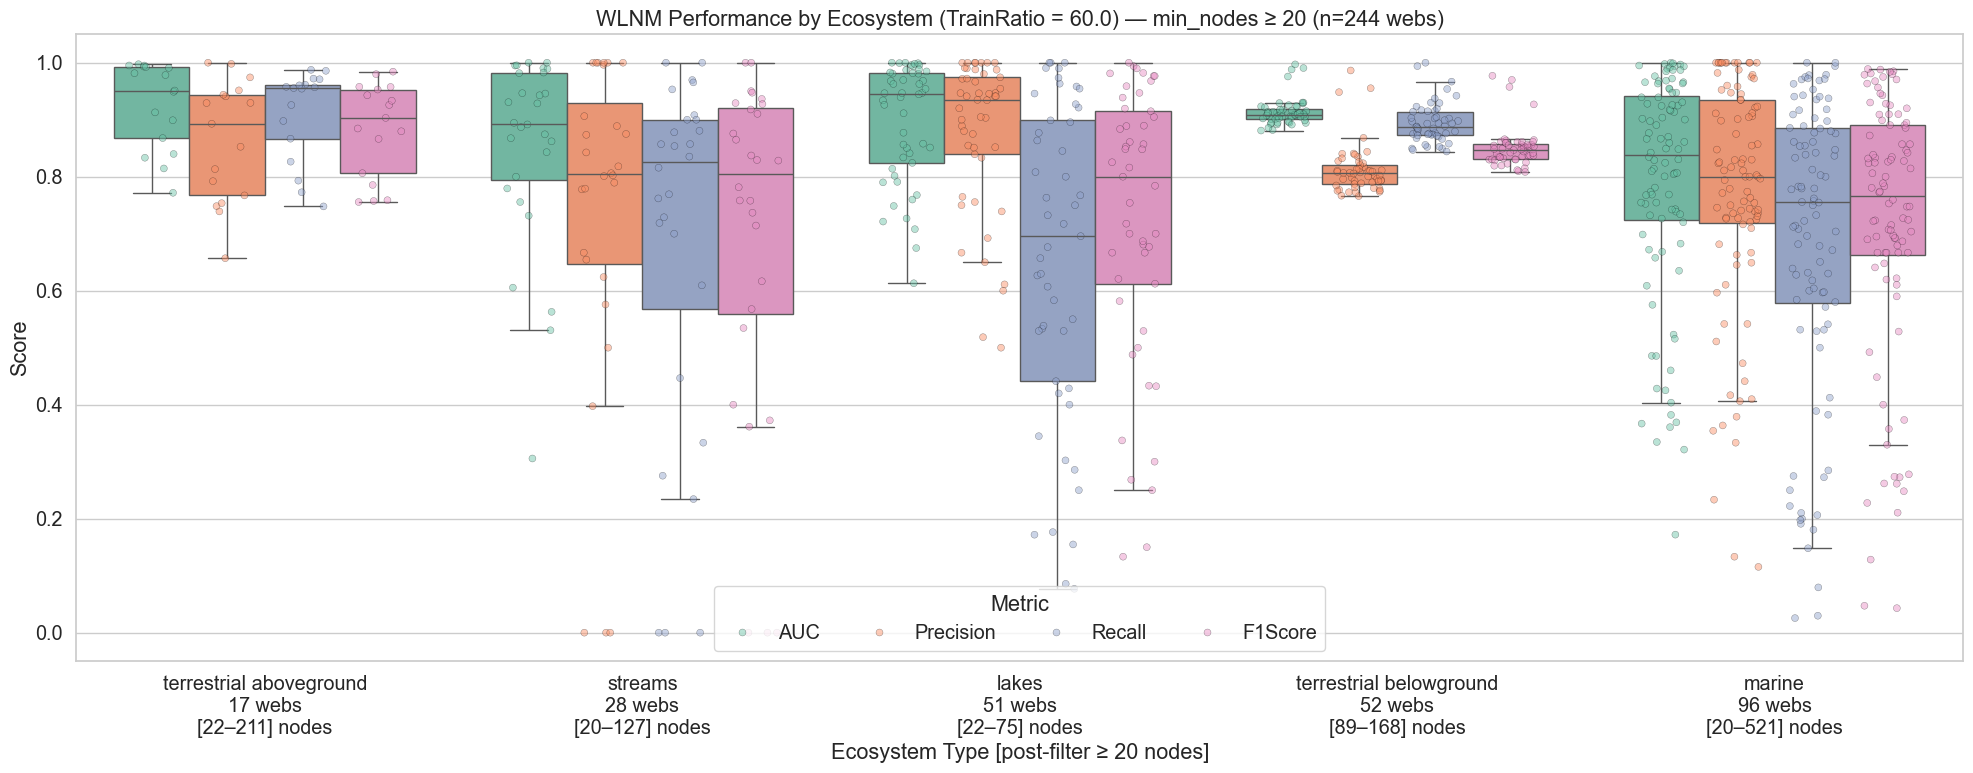

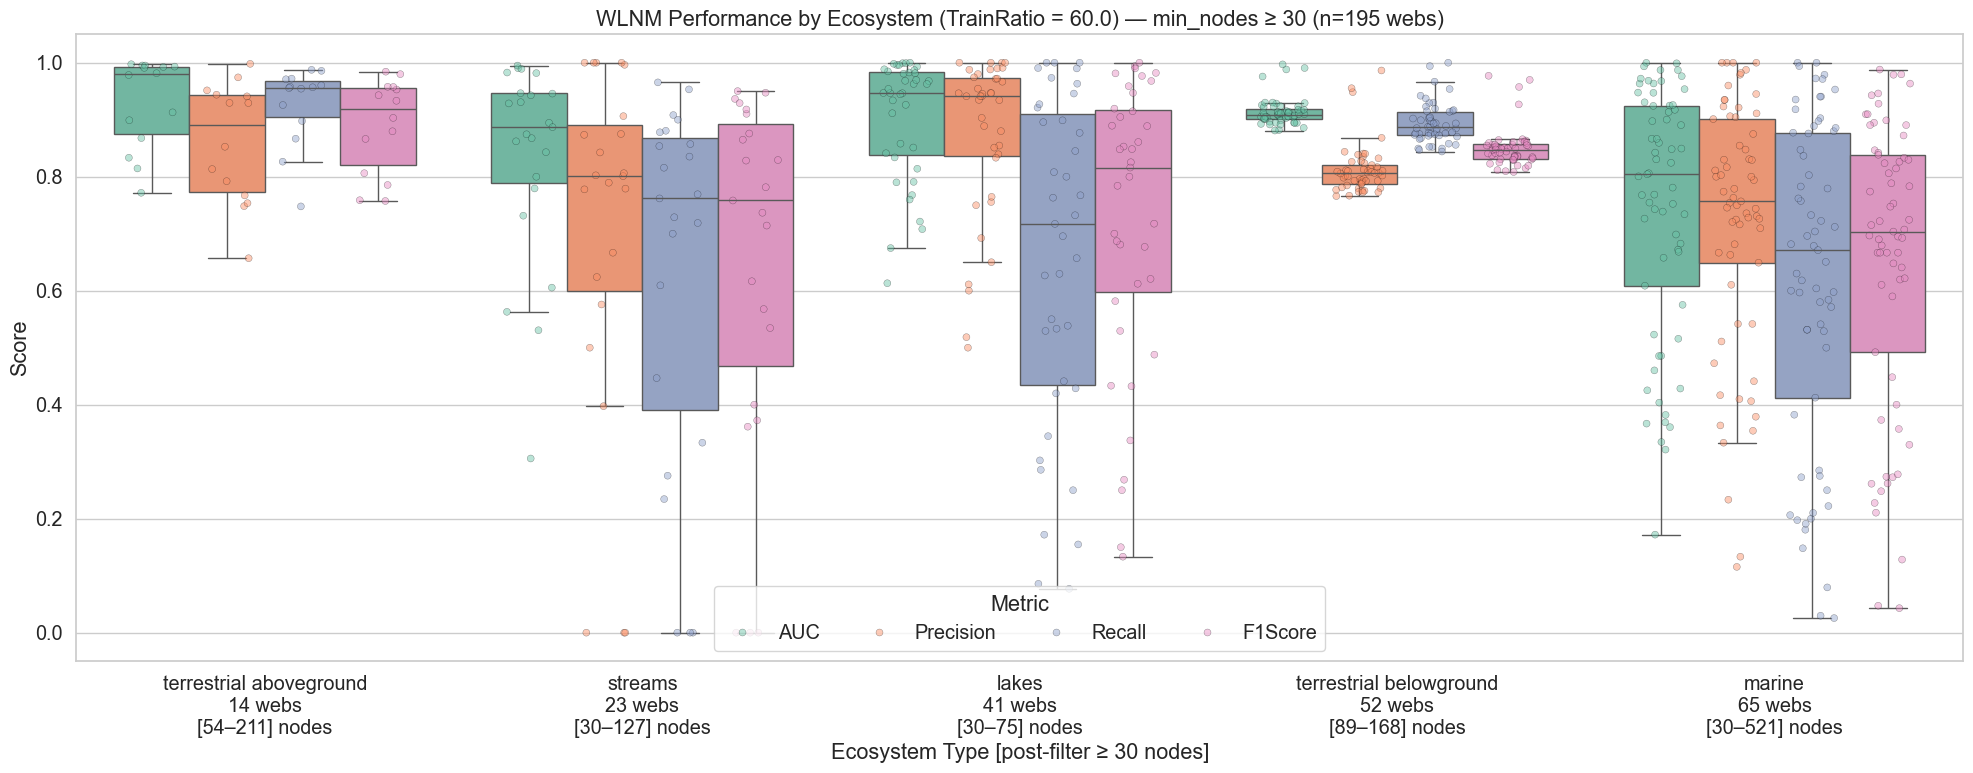

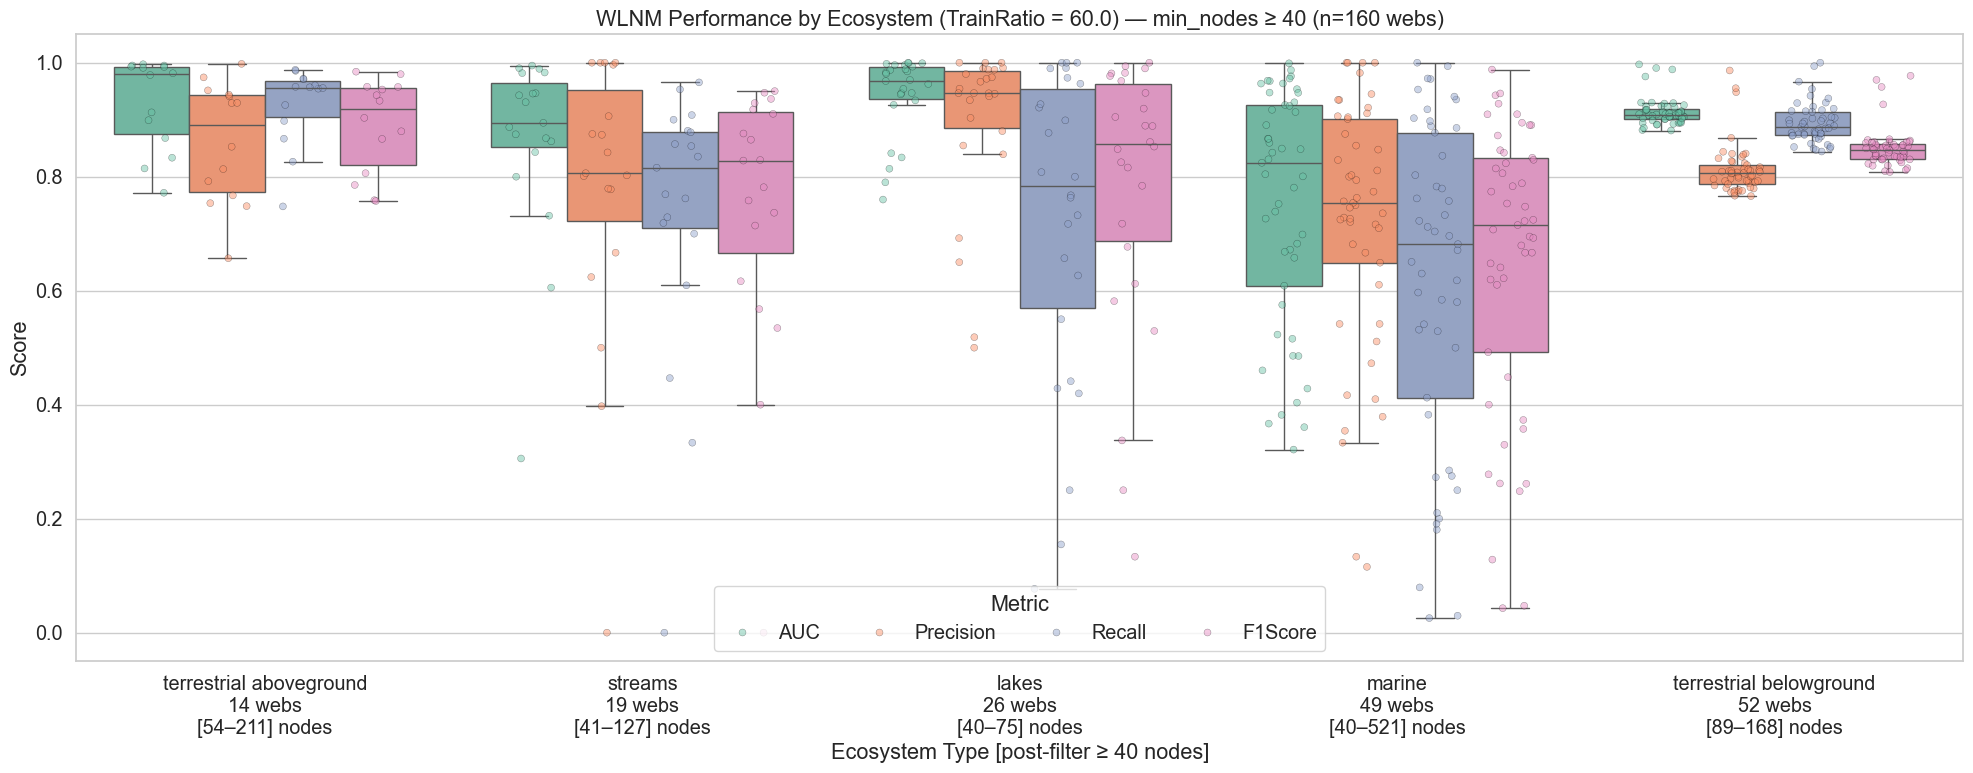

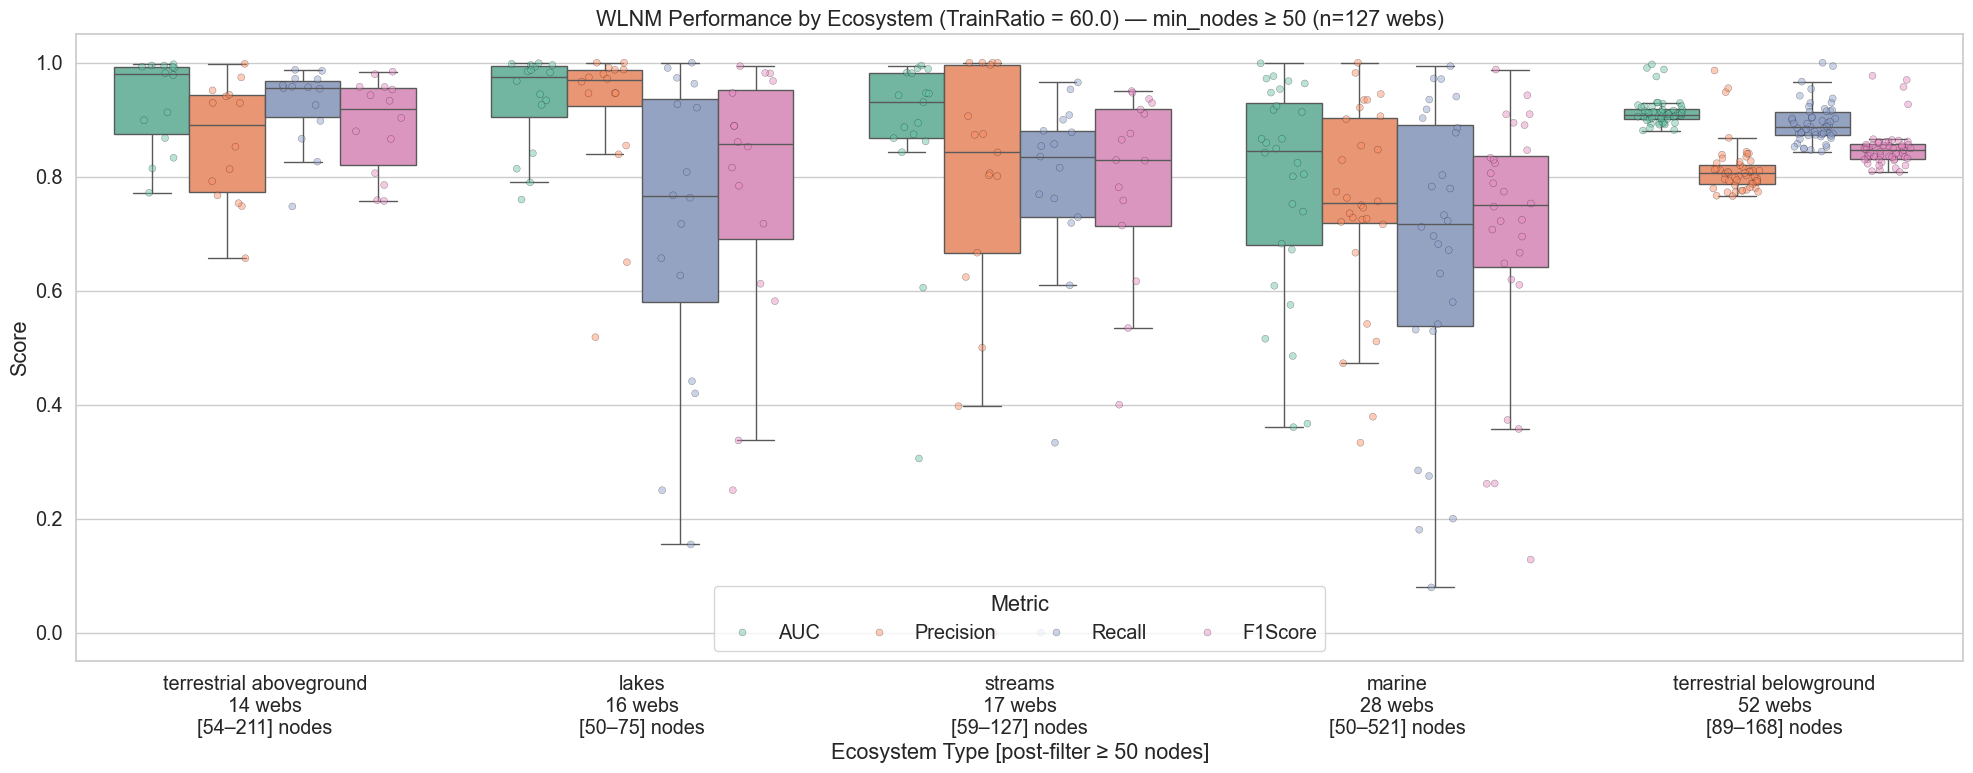

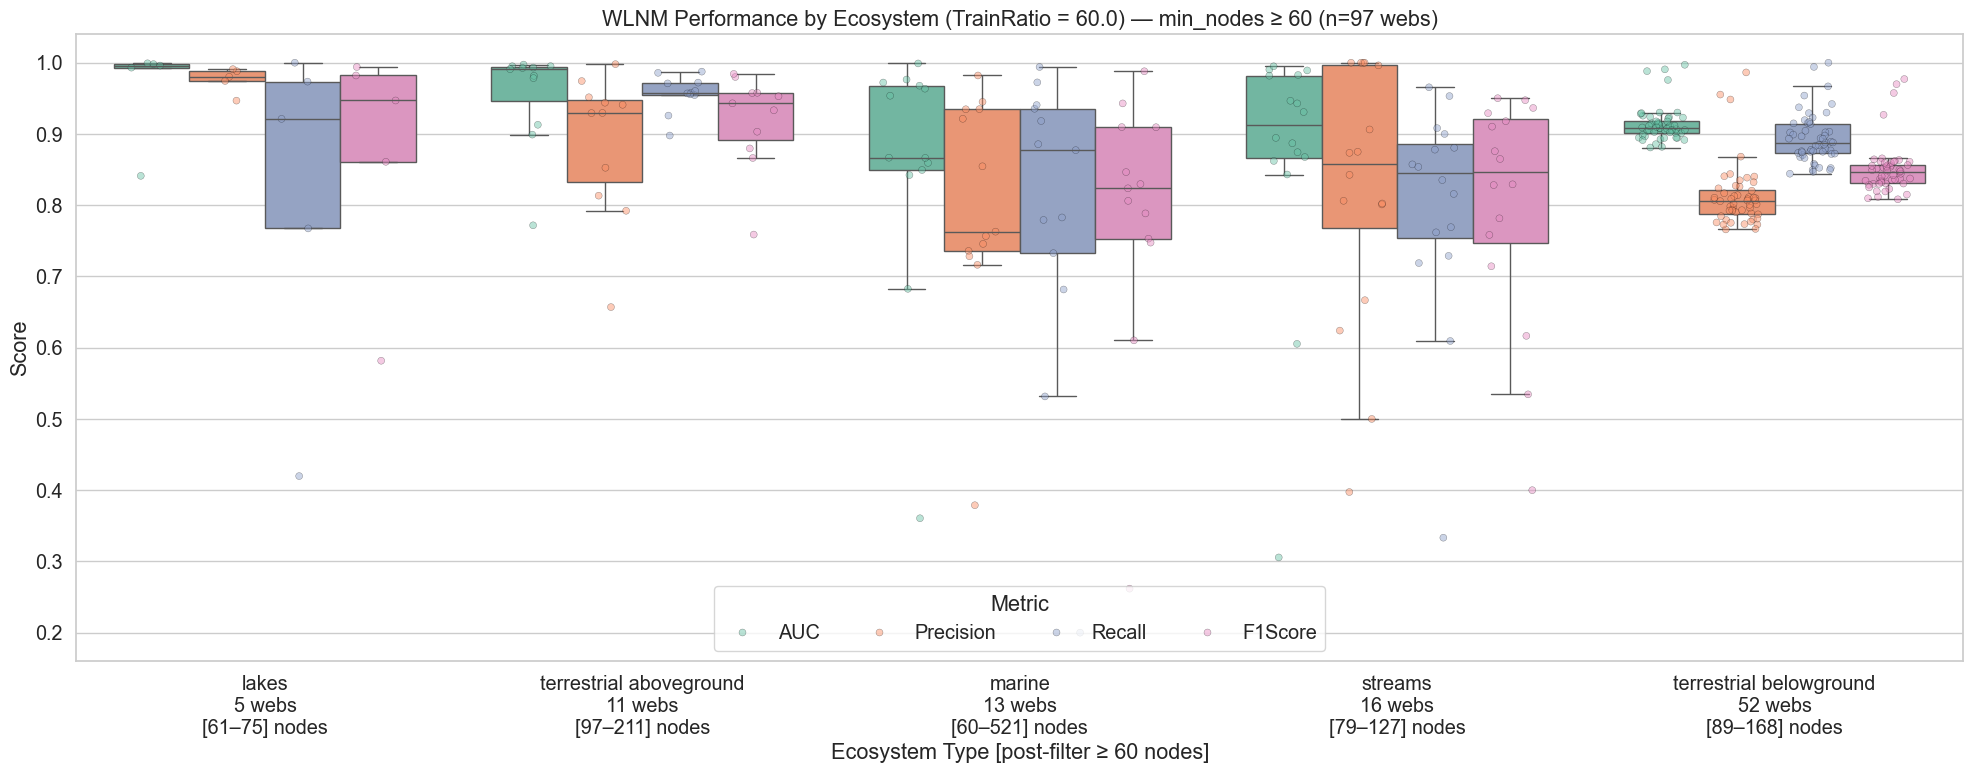

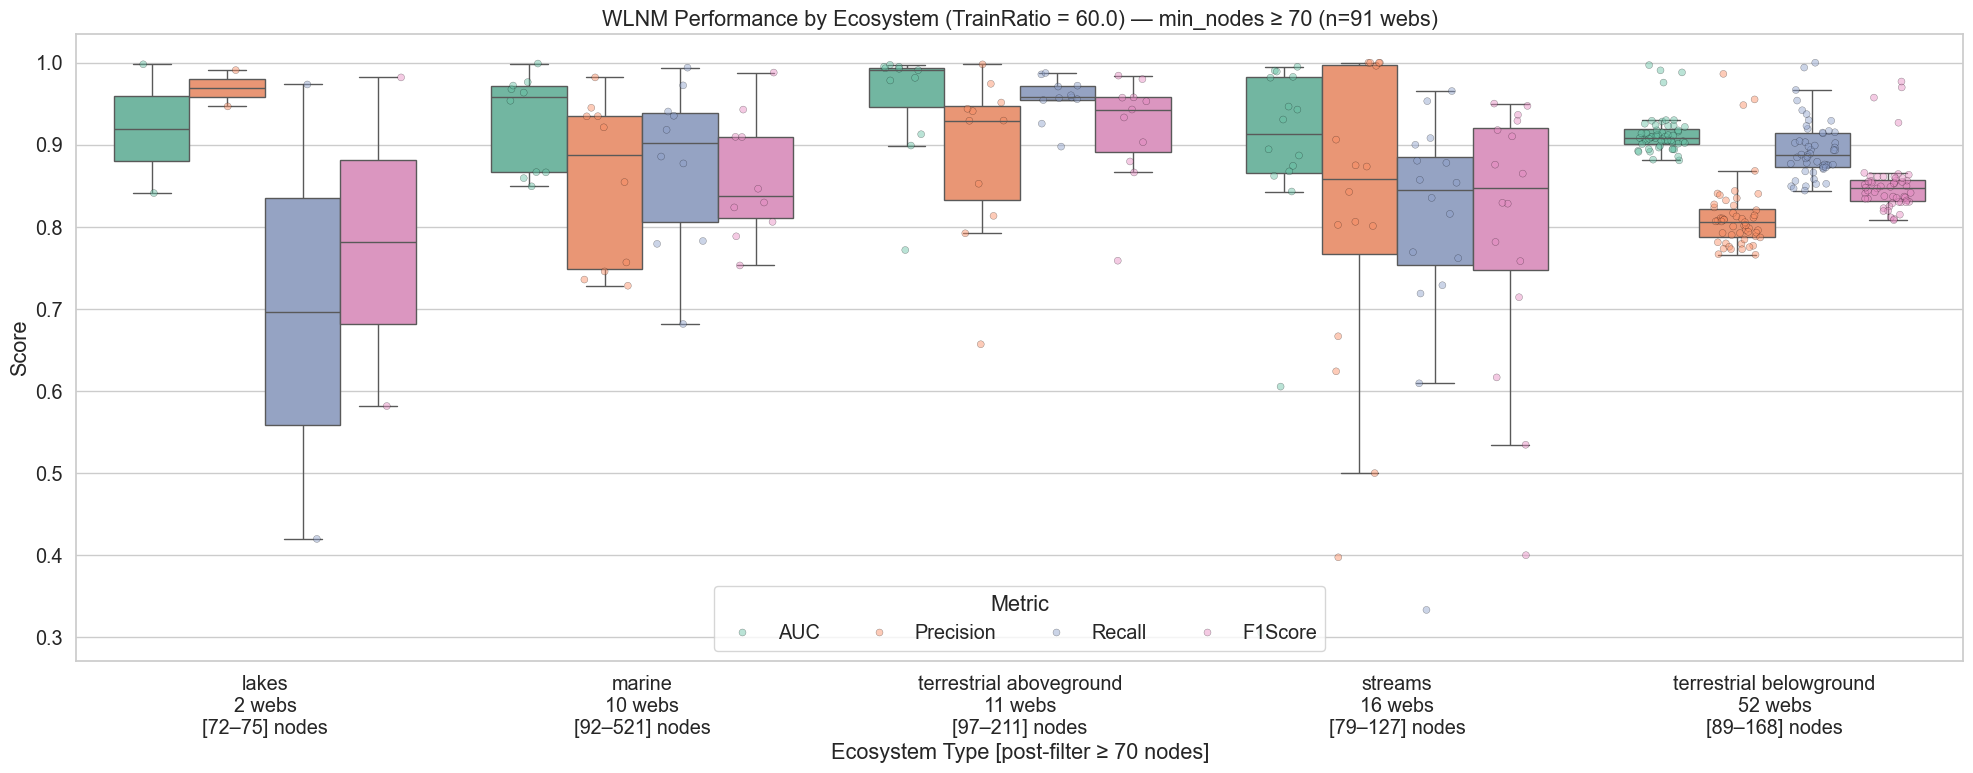

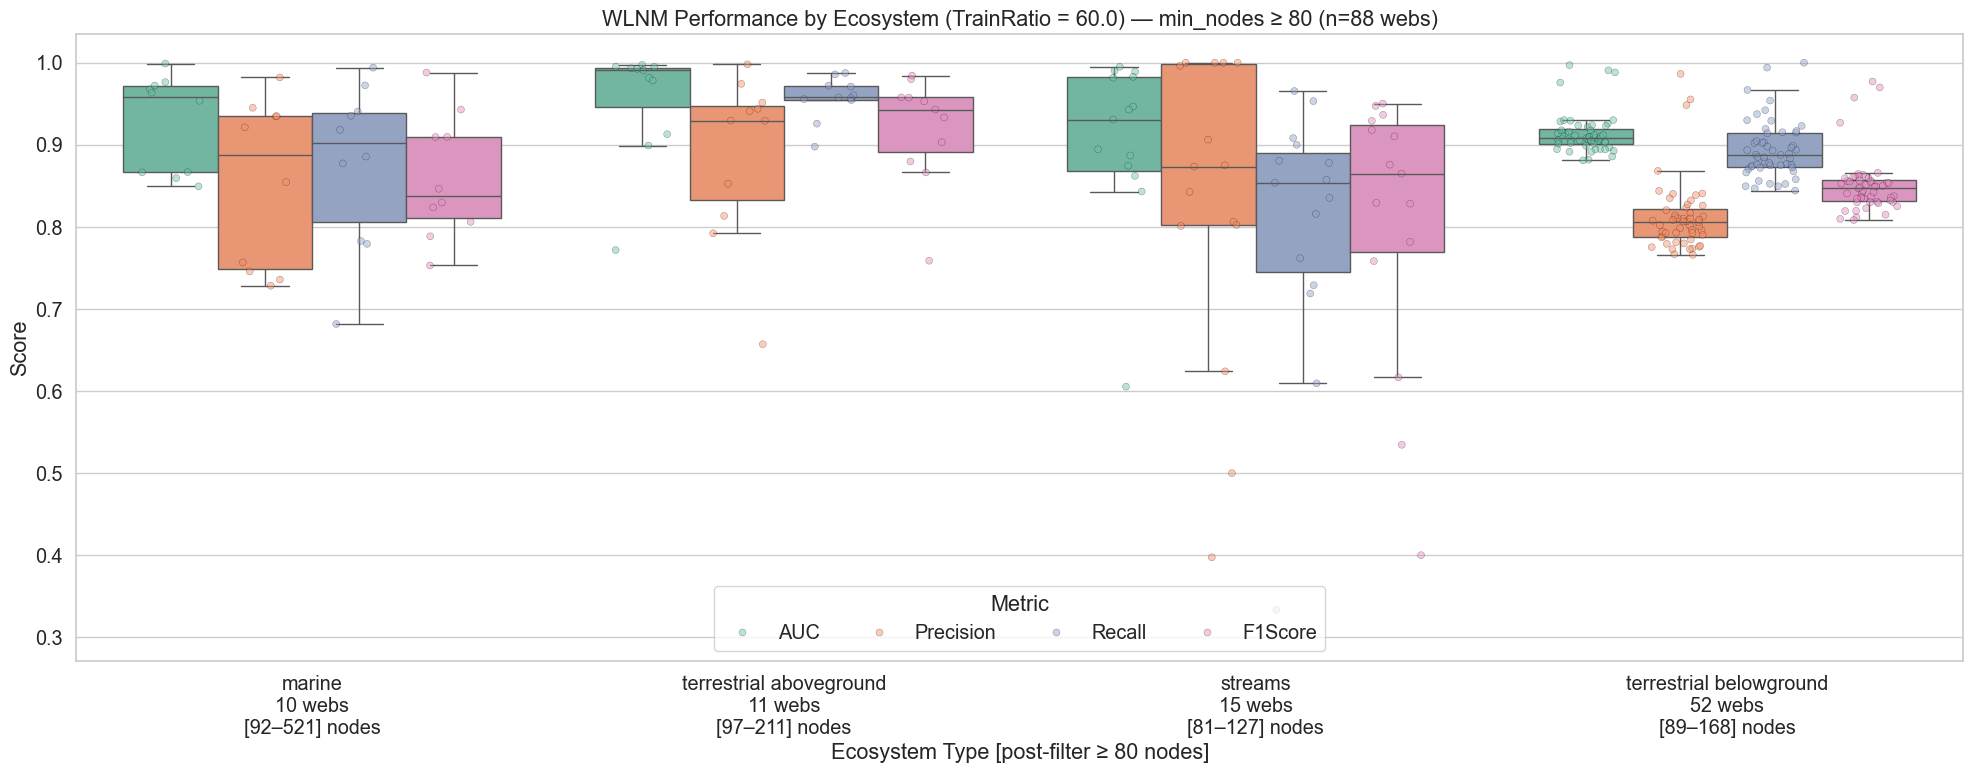

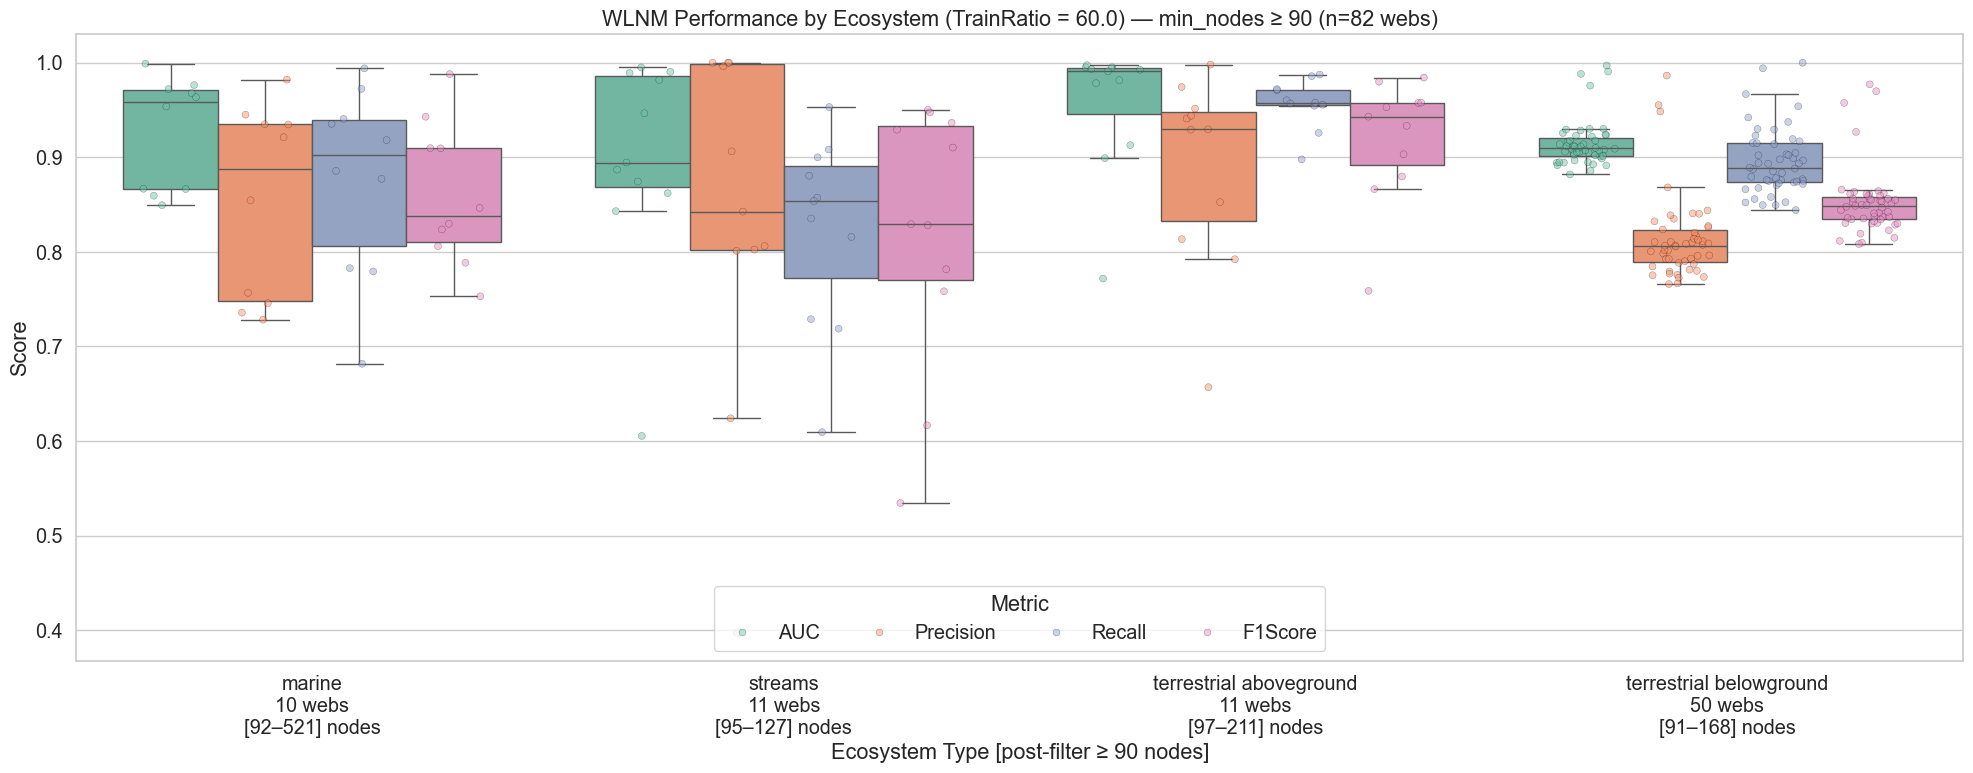

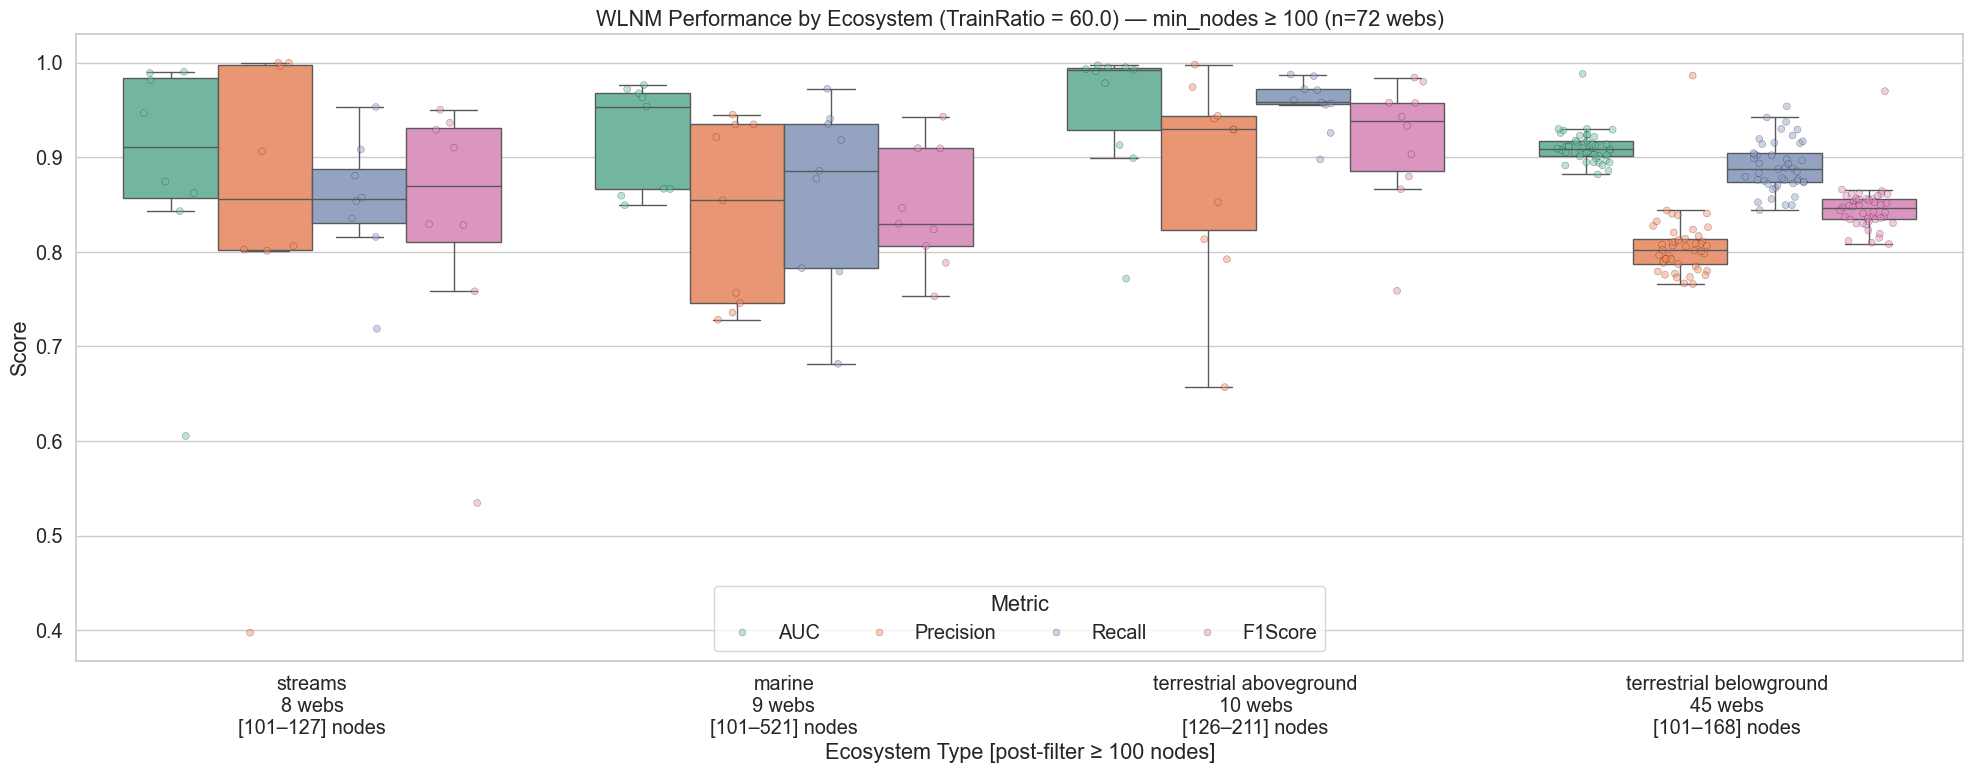

In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Paths ---
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"
train_ratio = 60.0

sns.set_theme(style="whitegrid", font_scale=1.3)

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

candidates = {
    "n_nodes","num_nodes","nodes","nodecount","n","s",
    "species","numspecies","numberofspecies","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = next((norm_map[k] for k in candidates if k in norm_map), None)
if node_col is None:
    raise RuntimeError("Could not find a node-count column in metadata (e.g. 'S', 'nodes').")

# --- Load result CSVs and stack ---
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# --- Merge results with ecosystem metadata once (no filter yet) ---
meta_cols = ["Foodweb", "ecosystem.type", node_col]
base = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# Helper: normalize TrainRatio to 0–100 scale regardless of how stored
def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# --- Sweep thresholds 10,20,...,100 ---
for min_nodes in range(0, 101, 10):
    dfm = base[base[node_col] >= min_nodes].copy()
    n_webs = dfm["Foodweb"].nunique()
    if dfm.empty or n_webs == 0:
        print(f"[min_nodes={min_nodes}] No food webs remain after filtering. Skipping.")
        continue

    # Prepare data for plotting
    df_plot = dfm.melt(
        id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
        value_vars=["AUC", "Precision", "Recall", "F1Score"],
        var_name="Metric",
        value_name="Value"
    )
    df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])

    # Subset to TrainRatio = 80%
    subset = df_plot[df_plot["TrainRatio_pct"].round(3) == train_ratio].copy()
    if subset.empty:
        print(f"[min_nodes={min_nodes}] No rows for TrainRatio=80%. Skipping.")
        continue

    # Order ecosystems (after filtering)
    ecosystem_order = (
        dfm[["Foodweb", "ecosystem.type"]]
        .drop_duplicates()
        .groupby("ecosystem.type")
        .size()
        .sort_values()
        .index
        .tolist()
    )

    # Build dynamic x-axis labels (counts + node range, after filtering)
    def make_label(group: pd.DataFrame) -> str:
        n_webs_g = group["Foodweb"].nunique()
        node_min = int(group[node_col].min())
        node_max = int(group[node_col].max())
        name = group.name
        return f"{name}\n{n_webs_g} webs\n[{node_min}–{node_max}] nodes"

    labels_map = {}
    for eco in ecosystem_order:
        grp = dfm[dfm["ecosystem.type"] == eco]
        grp.name = eco
        labels_map[eco] = make_label(grp)
    custom_labels = [labels_map[e] for e in ecosystem_order]

    # --- Plot: boxplot + points (per-threshold figure) ---
    plt.figure(figsize=(20, 8))
    ax = sns.boxplot(
        data=subset,
        x="ecosystem.type",
        y="Value",
        hue="Metric",            # <- hue used, so palette is safe
        hue_order=["AUC","Precision","Recall","F1Score"],
        palette="Set2",
        showfliers=False,
        order=ecosystem_order,
        dodge=True
    )

    sns.stripplot(
        data=subset,
        x="ecosystem.type",
        y="Value",
        hue="Metric",
        hue_order=["AUC","Precision","Recall","F1Score"],
        palette="Set2",
        dodge=True,
        jitter=0.25,
        alpha=0.45,
        linewidth=0.3,
        edgecolor="black",
        order=ecosystem_order,
        zorder=2
    )

    # De-duplicate legend (boxplot + stripplot each add entries)
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), title="Metric", frameon=True, loc="lower center", ncol=4)

    ax.set_title(f"WLNM Performance by Ecosystem (TrainRatio = {train_ratio}) — min_nodes ≥ {min_nodes} (n={n_webs} webs)")
    ax.set_ylabel("Score")
    ax.set_xlabel(f"Ecosystem Type [post-filter ≥ {min_nodes} nodes]")
    ax.set_xticks(range(len(custom_labels)))
    ax.set_xticklabels(custom_labels)

    plt.tight_layout()
    plt.show()

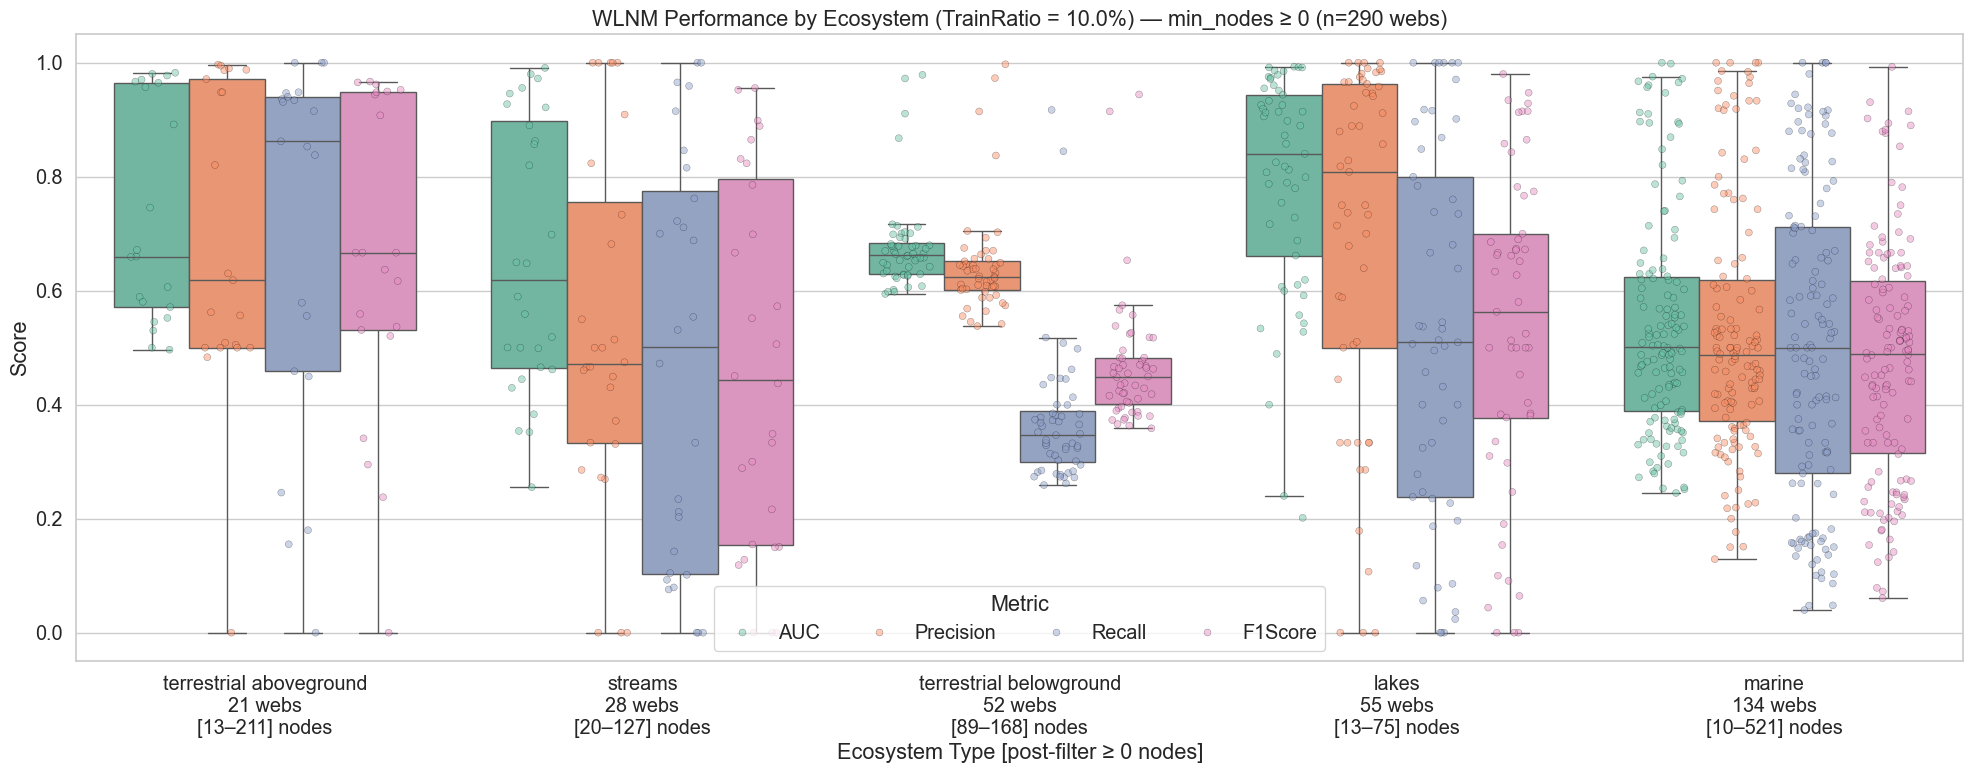

[min_nodes=0] No food webs were filtered out (with TrainRatio=10.0%).


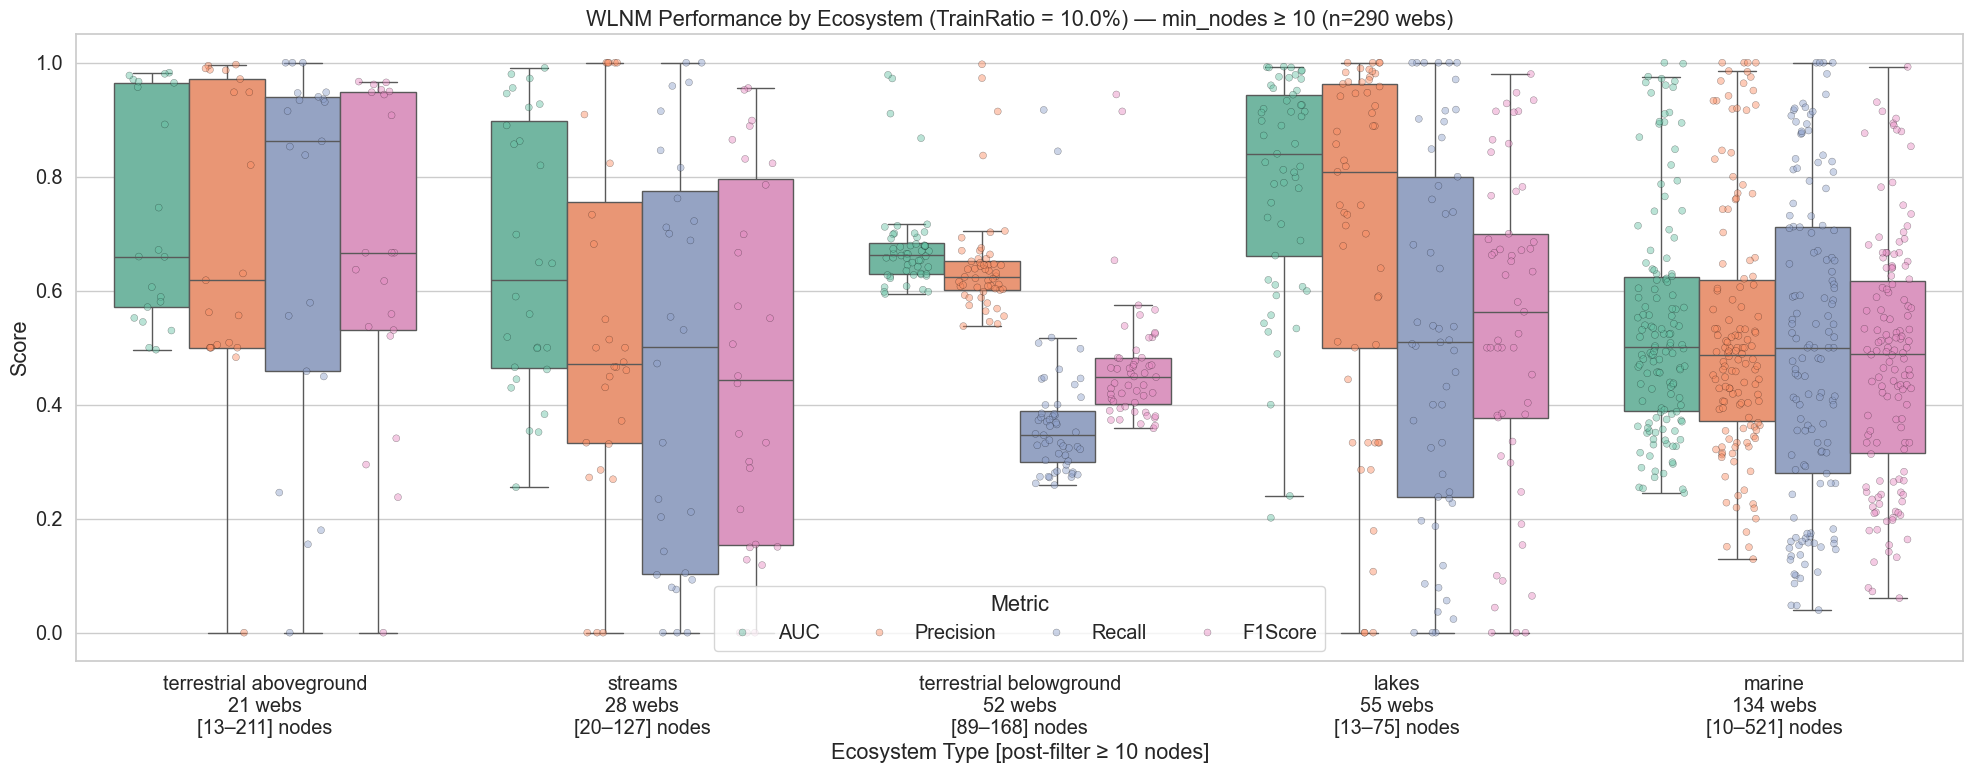

[min_nodes=10] No food webs were filtered out (with TrainRatio=10.0%).


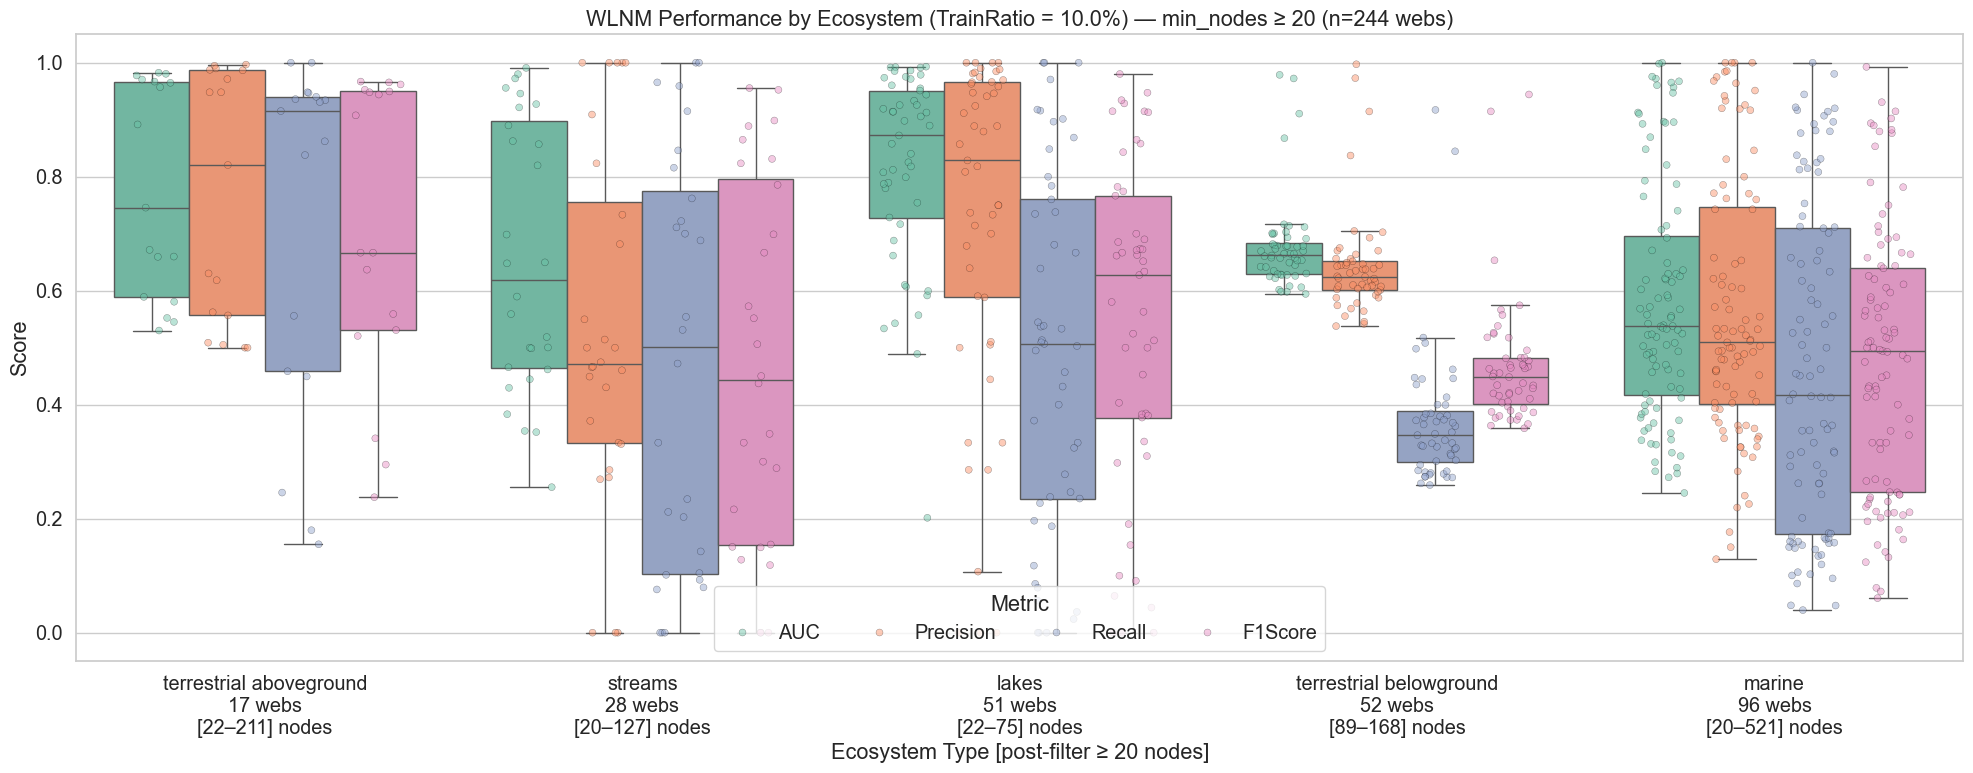

[min_nodes=20] Filtered-out food webs (had TrainRatio=10.0% data): 46


Foodweb                Ecosystem  Nodes     AUC  \
0     Twin Lake East_tax_mass                    lakes     13  0.4000   
1   Brook trout lake_tax_mass                    lakes     15  0.5278   
2    Gull lake north_tax_mass                    lakes     16  0.6190   
3          Deep lake_tax_mass                    lakes     19  0.2400   
4              SF1M2_tax_mass                   marine     10  0.4643   
5              PP1I3_tax_mass                   marine     11  0.5000   
6                SP1_tax_mass                   marine     11  0.4985   
7                AP4_tax_mass                   marine     12  0.4363   
8              PC2P5_tax_mass                   marine     12  0.3620   
9              SF1M1_tax_mass                   marine     12  0.4375   
10               AP1_tax_mass                   marine     13  0.5242   
11             PP1I2_tax_mass                   marine     14  0.4560   
12             SF2I4_tax_mass                   marine     14  0.7394   
13             SF2M1_tax_mass                   marine     14  0.3868   
14             SF1I1_tax_mass                   marine     15  0.2960   
15             SF1M3_tax_mass                   marine     15  0.3269   
16             SF1M4_tax_mass                   marine     15  0.3702   
17             SF2I3_tax_mass                   marine     15  0.4874   
18             SF2M2_tax_mass                   marine     15  0.2531   
19              RMP4_tax_mass                   marine     16  0.4352   
20             SF2I1_tax_mass                   marine     16  0.2516   
21             PC1P4_tax_mass                   marine     17  0.5035   
22             PC2P4_tax_mass                   marine     17  0.6569   
23            PGSBP1_tax_mass                   marine     17  0.5571   
24              RMP3_tax_mass                   marine     17  0.6379   
25             SF2M4_tax_mass                   marine     17  0.3511   
26               AP2_tax_mass                   marine     18  0.3270   
27               AP3_tax_mass                   marine     18  0.4756   
28               BP2_tax_mass                   marine     18  0.3392   
29              CGP1_tax_mass                   marine     18  0.6043   
30              CGP2_tax_mass                   marine     18  0.3567   
31             PC2P3_tax_mass                   marine     18  0.4902   
32            PGUBP1_tax_mass                   marine     18  0.3741   
33            PGUBP4_tax_mass                   marine     18  0.4662   
34             PP1I4_tax_mass                   marine     18  0.3536   
35             PP2M1_tax_mass                   marine     18  0.5705   
36             PP2M4_tax_mass                   marine     18  0.4569   
37              MBP2_tax_mass                   marine     19  0.4871   
38             PC2P1_tax_mass                   marine     19  0.4792   
39             PP2M2_tax_mass                   marine     19  0.3908   
40             PP2M3_tax_mass                   marine     19  0.2549   
41             SF2I2_tax_mass                   marine     19  0.4390   
42          Svalbard_tax_mass  terrestrial aboveground     13  0.5000   
43             Alert_tax_mass  terrestrial aboveground     16  0.5712   
44             Bylot_tax_mass  terrestrial aboveground     16  0.6064   
45        Zackenberg_tax_mass  terrestrial aboveground     17  0.4965   

    Precision  Recall  F1Score  
0      0.3333  1.0000   0.5000  
1      0.3333  1.0000   0.5000  
2      0.3333  1.0000   0.5000  
3      0.1786  0.4000   0.2469  
4      0.3125  0.7143   0.4348  
5      0.5263  0.5000   0.5128  
6      0.5000  0.6111   0.5500  
7      0.4211  0.4211   0.4211  
8      0.4062  0.5417   0.4643  
9      0.4483  0.5417   0.4906  
10     0.3611  0.9286   0.5200  
11     0.4444  0.4800   0.4615  
12     0.9333  0.5185   0.6667  
13     0.4062  0.4815   0.4407  
14     0.2000  0.4000   0.2667  
15     0.2281  0.5000   0.3133  
16     0.2500  0.5000   0.333

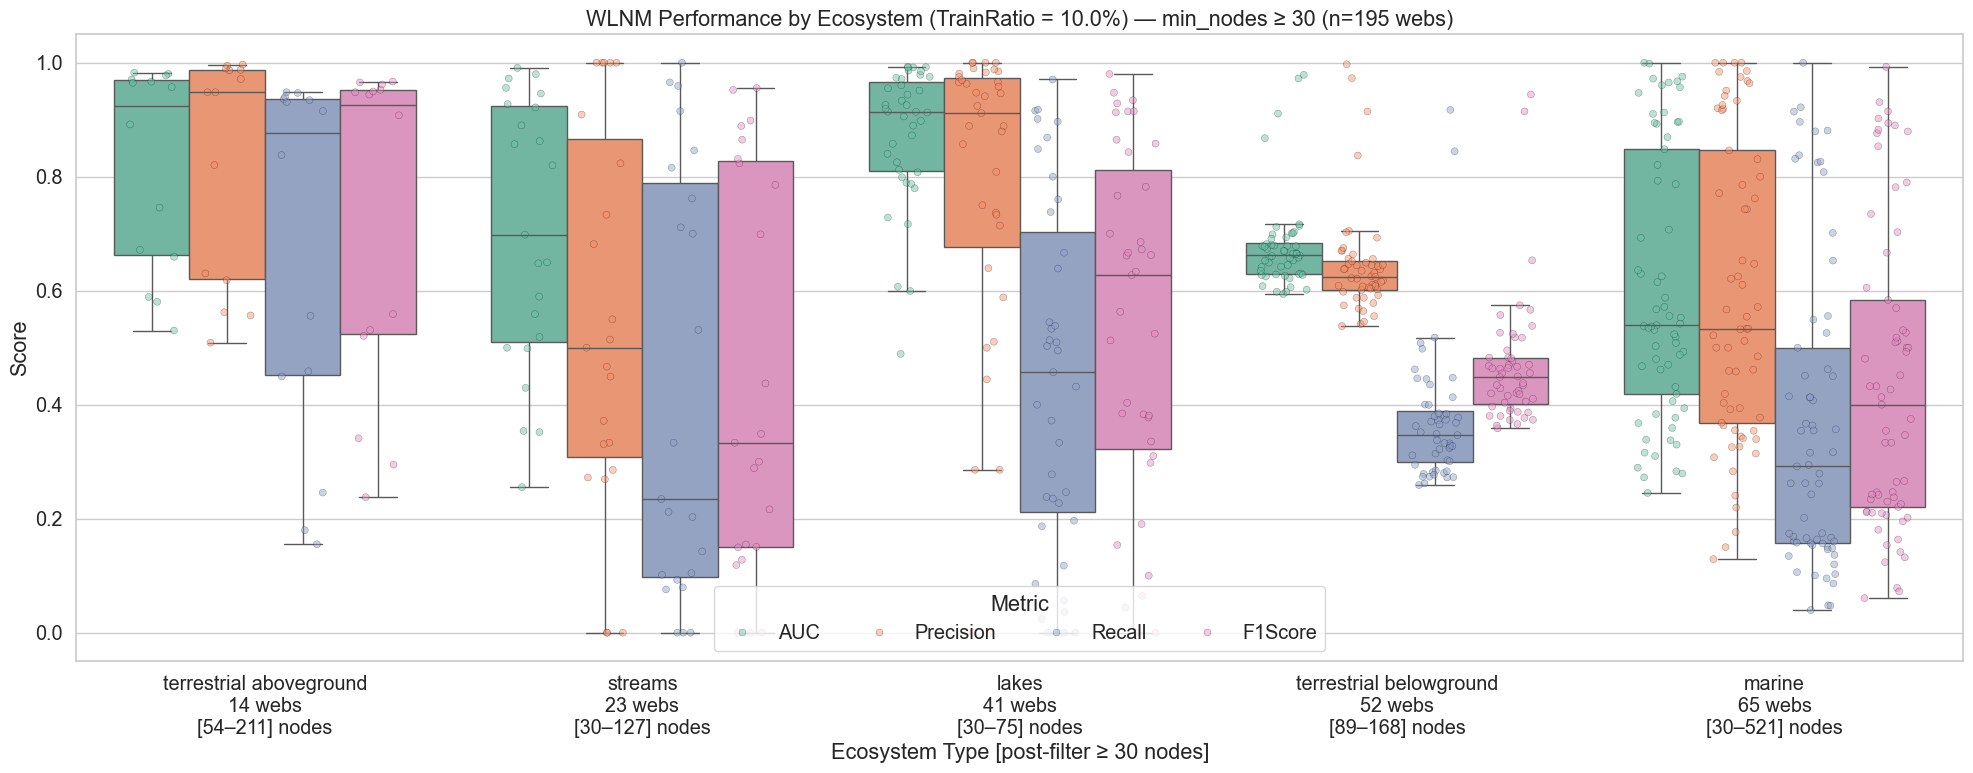

[min_nodes=30] Filtered-out food webs (had TrainRatio=10.0% data): 95


Foodweb                Ecosystem  Nodes     AUC  \
0     Twin Lake East_tax_mass                    lakes     13  0.4000   
1   Brook trout lake_tax_mass                    lakes     15  0.5278   
2    Gull lake north_tax_mass                    lakes     16  0.6190   
3          Deep lake_tax_mass                    lakes     19  0.2400   
4       Emerald lake_tax_mass                    lakes     22  0.8180   
..                        ...                      ...    ...     ...   
90             Bylot_tax_mass  terrestrial aboveground     16  0.6064   
91        Zackenberg_tax_mass  terrestrial aboveground     17  0.4965   
92             Yamal_tax_mass  terrestrial aboveground     22  0.6599   
93          Herschel_tax_mass  terrestrial aboveground     23  0.5452   
94          Nenetsky_tax_mass  terrestrial aboveground     24  0.5522   

    Precision  Recall  F1Score  
0      0.3333  1.0000   0.5000  
1      0.3333  1.0000   0.5000  
2      0.3333  1.0000   0.5000  
3      0.1786  0.4000   0.2469  
4      0.8182  0.7347   0.7742  
..        ...     ...      ...  
90     0.0000  0.0000   0.0000  
91     0.4833  0.8529   0.6170  
92     0.5051  0.8621   0.6369  
93     0.5000  1.0000   0.6667  
94     0.5000  1.0000   0.6667  

[95 rows x 7 columns]

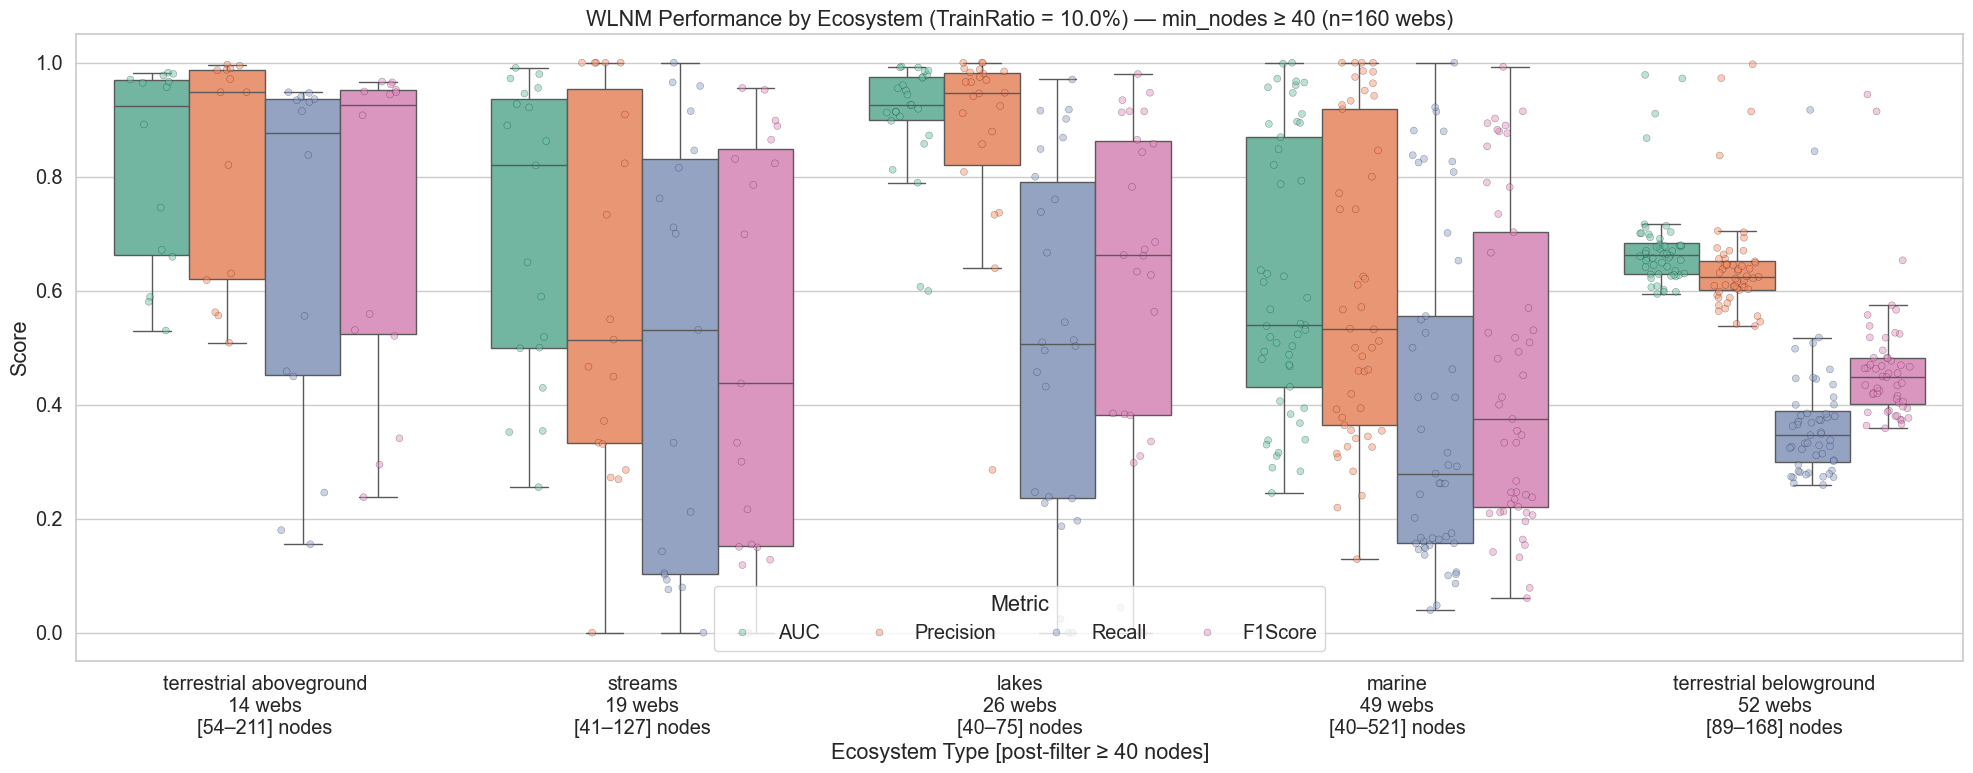

[min_nodes=40] Filtered-out food webs (had TrainRatio=10.0% data): 130


Foodweb                Ecosystem  Nodes     AUC  \
0      Twin Lake East_tax_mass                    lakes     13  0.4000   
1    Brook trout lake_tax_mass                    lakes     15  0.5278   
2     Gull lake north_tax_mass                    lakes     16  0.6190   
3           Deep lake_tax_mass                    lakes     19  0.2400   
4        Emerald lake_tax_mass                    lakes     22  0.8180   
..                         ...                      ...    ...     ...   
125             Bylot_tax_mass  terrestrial aboveground     16  0.6064   
126        Zackenberg_tax_mass  terrestrial aboveground     17  0.4965   
127             Yamal_tax_mass  terrestrial aboveground     22  0.6599   
128          Herschel_tax_mass  terrestrial aboveground     23  0.5452   
129          Nenetsky_tax_mass  terrestrial aboveground     24  0.5522   

     Precision  Recall  F1Score  
0       0.3333  1.0000   0.5000  
1       0.3333  1.0000   0.5000  
2       0.3333  1.0000   0.5000  
3       0.1786  0.4000   0.2469  
4       0.8182  0.7347   0.7742  
..         ...     ...      ...  
125     0.0000  0.0000   0.0000  
126     0.4833  0.8529   0.6170  
127     0.5051  0.8621   0.6369  
128     0.5000  1.0000   0.6667  
129     0.5000  1.0000   0.6667  

[130 rows x 7 columns]

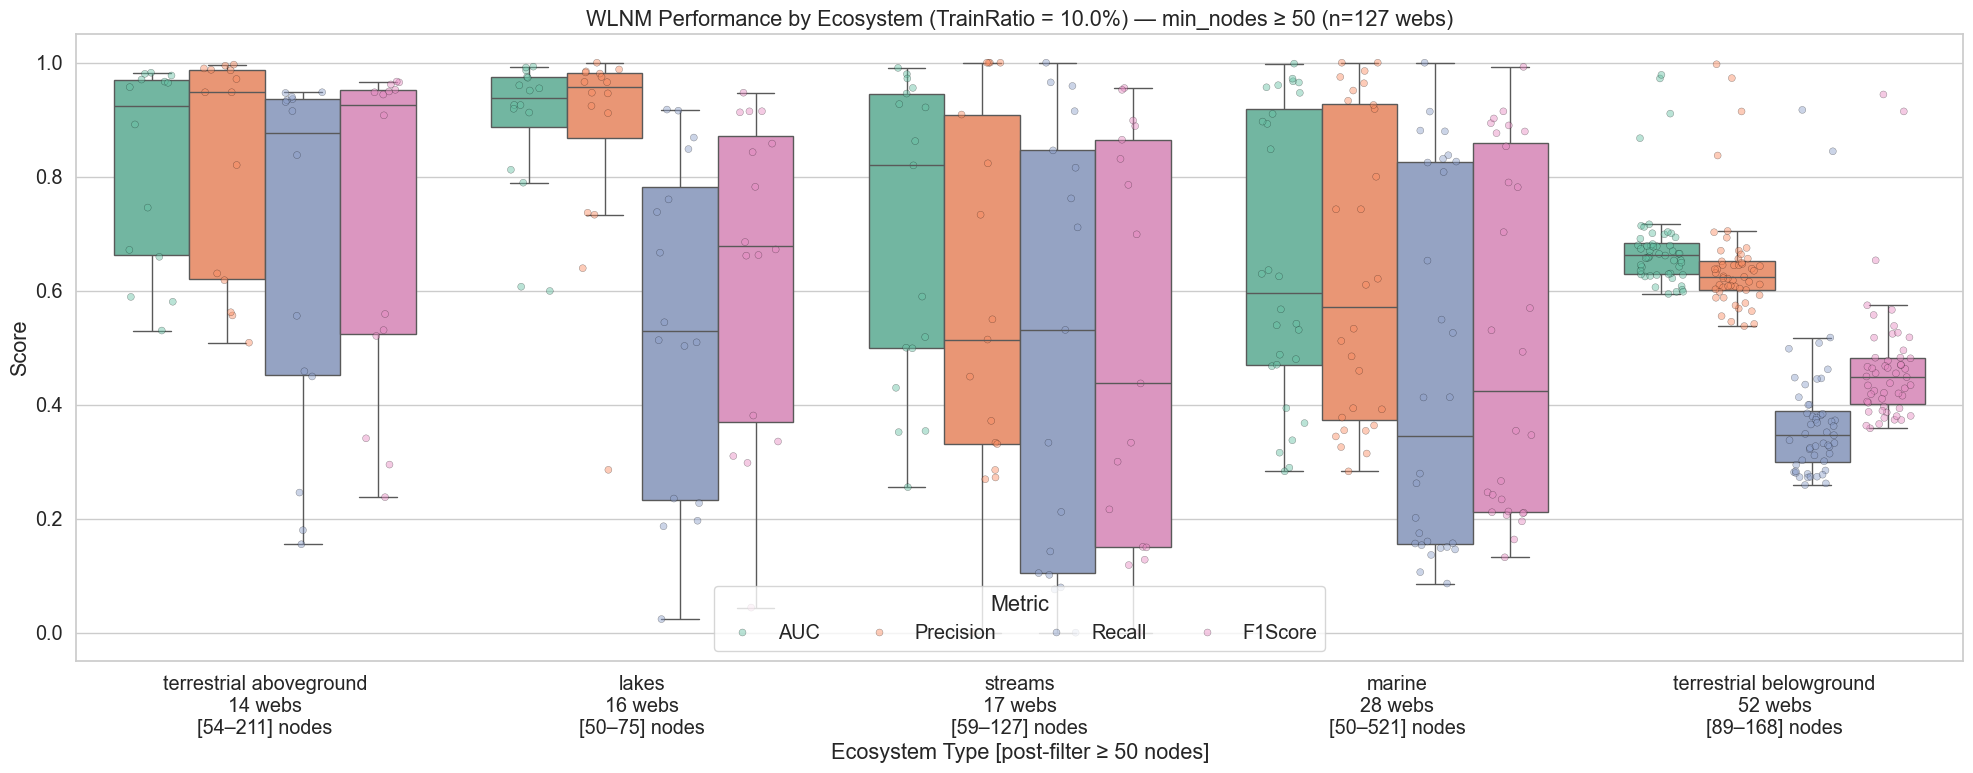

[min_nodes=50] Filtered-out food webs (had TrainRatio=10.0% data): 163


Foodweb                Ecosystem  Nodes     AUC  \
0      Twin Lake East_tax_mass                    lakes     13  0.4000   
1    Brook trout lake_tax_mass                    lakes     15  0.5278   
2     Gull lake north_tax_mass                    lakes     16  0.6190   
3           Deep lake_tax_mass                    lakes     19  0.2400   
4        Emerald lake_tax_mass                    lakes     22  0.8180   
..                         ...                      ...    ...     ...   
158             Bylot_tax_mass  terrestrial aboveground     16  0.6064   
159        Zackenberg_tax_mass  terrestrial aboveground     17  0.4965   
160             Yamal_tax_mass  terrestrial aboveground     22  0.6599   
161          Herschel_tax_mass  terrestrial aboveground     23  0.5452   
162          Nenetsky_tax_mass  terrestrial aboveground     24  0.5522   

     Precision  Recall  F1Score  
0       0.3333  1.0000   0.5000  
1       0.3333  1.0000   0.5000  
2       0.3333  1.0000   0.5000  
3       0.1786  0.4000   0.2469  
4       0.8182  0.7347   0.7742  
..         ...     ...      ...  
158     0.0000  0.0000   0.0000  
159     0.4833  0.8529   0.6170  
160     0.5051  0.8621   0.6369  
161     0.5000  1.0000   0.6667  
162     0.5000  1.0000   0.6667  

[163 rows x 7 columns]

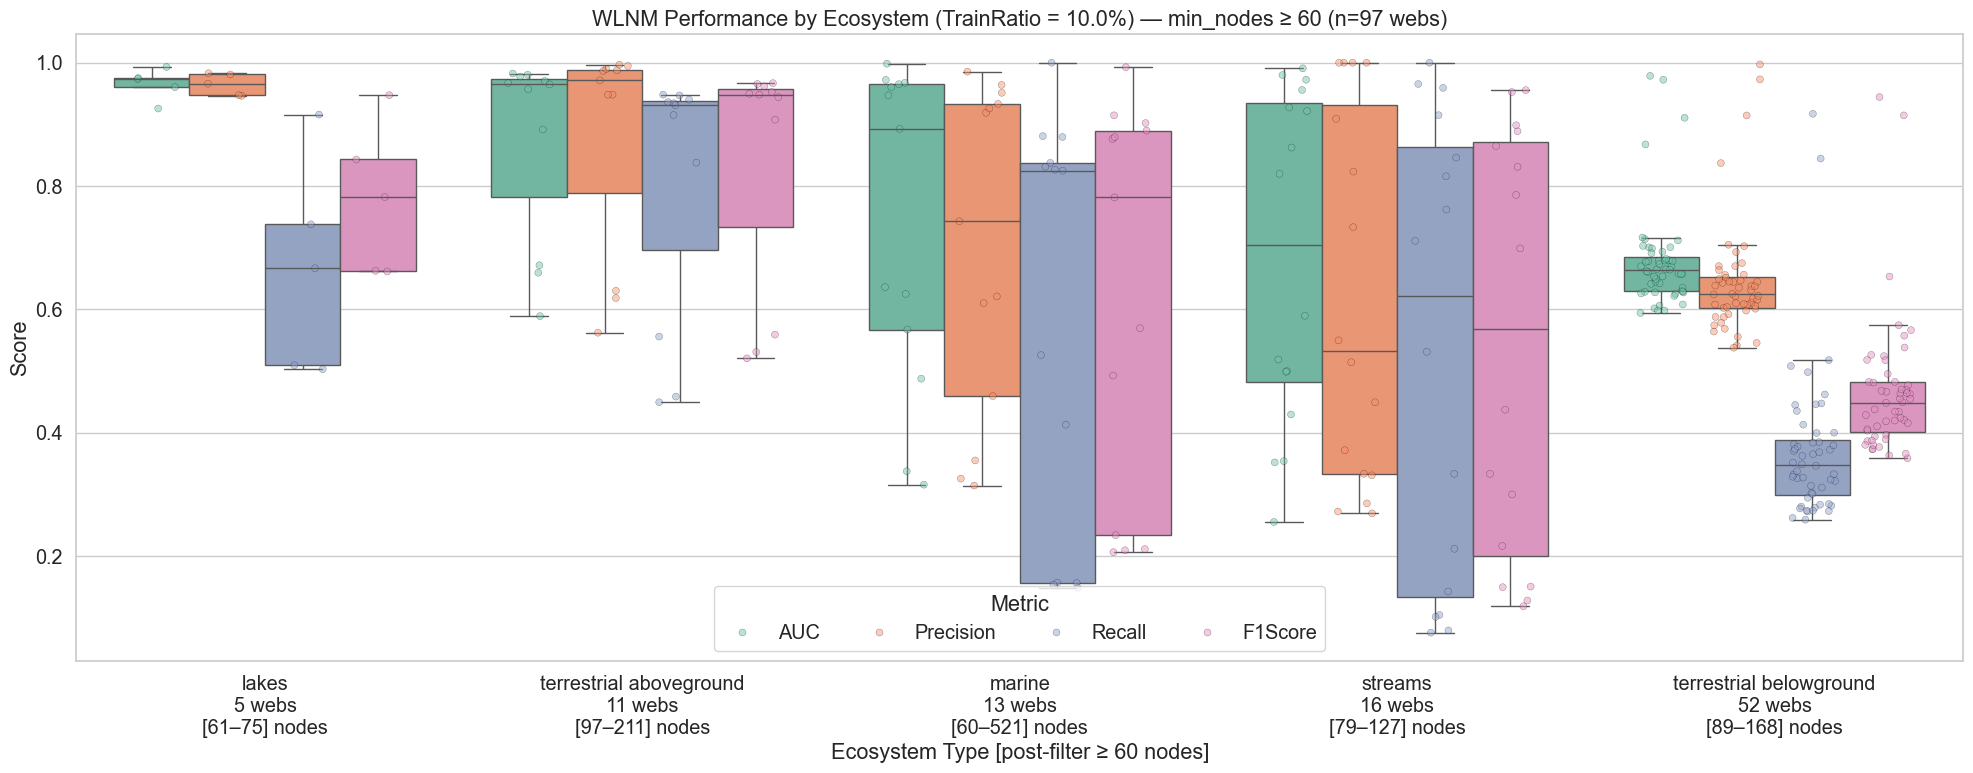

[min_nodes=60] Filtered-out food webs (had TrainRatio=10.0% data): 193


Foodweb                Ecosystem  Nodes     AUC  \
0      Twin Lake East_tax_mass                    lakes     13  0.4000   
1    Brook trout lake_tax_mass                    lakes     15  0.5278   
2     Gull lake north_tax_mass                    lakes     16  0.6190   
3           Deep lake_tax_mass                    lakes     19  0.2400   
4        Emerald lake_tax_mass                    lakes     22  0.8180   
..                         ...                      ...    ...     ...   
188          Herschel_tax_mass  terrestrial aboveground     23  0.5452   
189          Nenetsky_tax_mass  terrestrial aboveground     24  0.5522   
190   FloridaIslandE7_tax_mass  terrestrial aboveground     54  0.5806   
191   FloridaIslandE9_tax_mass  terrestrial aboveground     56  0.5301   
192   FloridaIslandE2_tax_mass  terrestrial aboveground     59  0.7458   

     Precision  Recall  F1Score  
0       0.3333  1.0000   0.5000  
1       0.3333  1.0000   0.5000  
2       0.3333  1.0000   0.5000  
3       0.1786  0.4000   0.2469  
4       0.8182  0.7347   0.7742  
..         ...     ...      ...  
188     0.5000  1.0000   0.6667  
189     0.5000  1.0000   0.6667  
190     0.5088  0.1551   0.2377  
191     0.5566  0.2458   0.3410  
192     0.8205  0.1798   0.2949  

[193 rows x 7 columns]

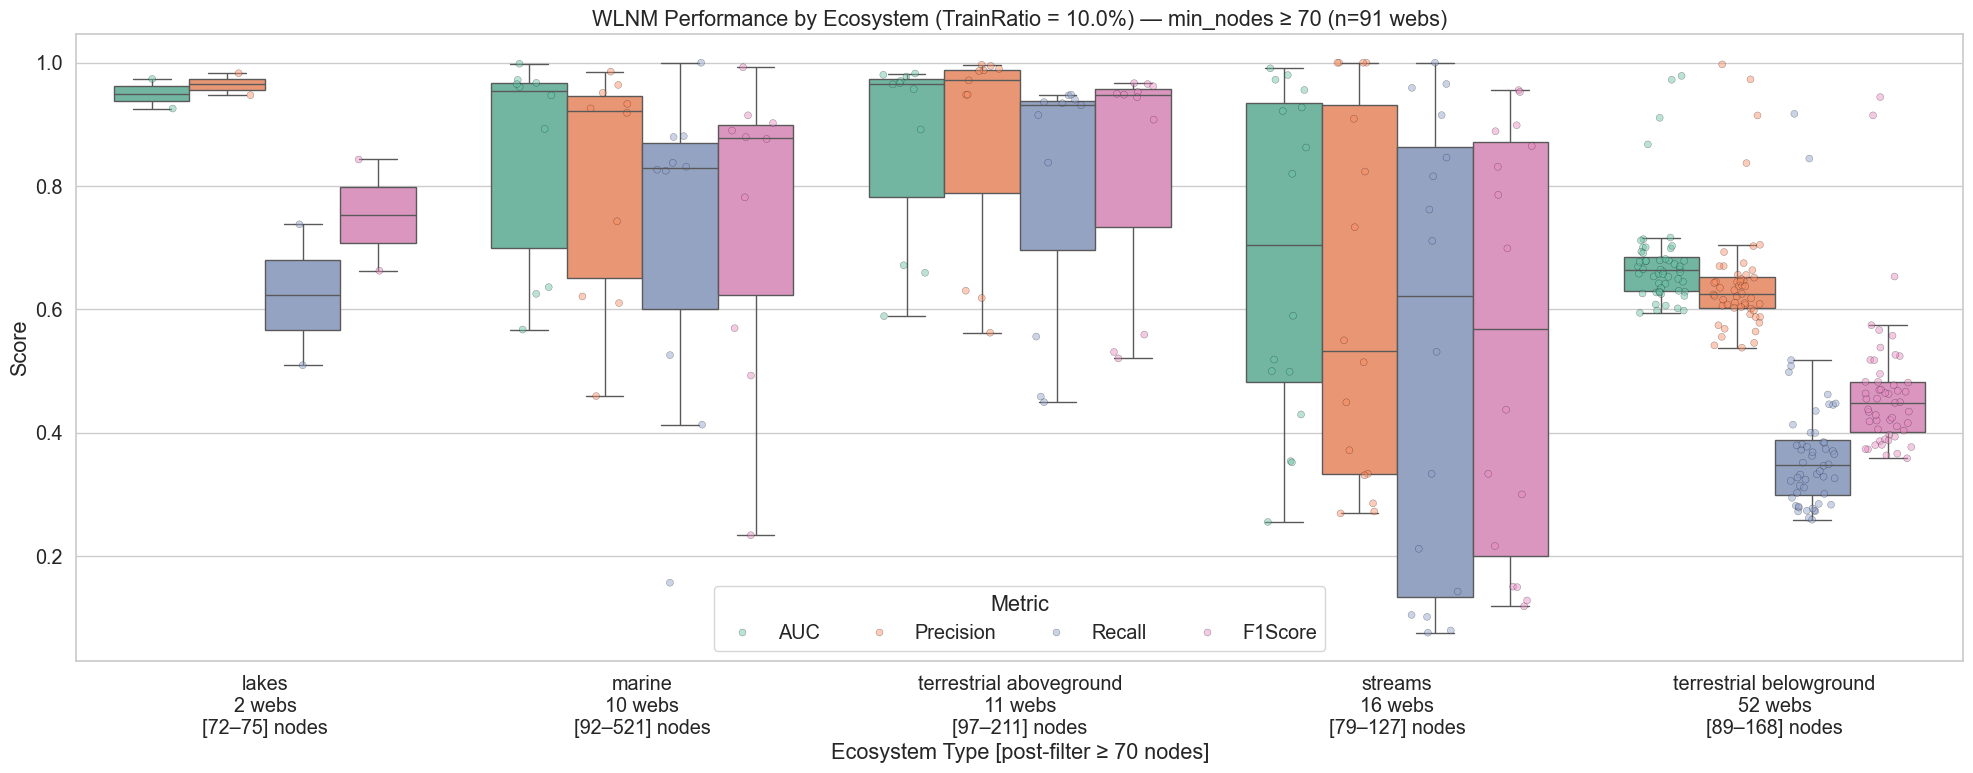

[min_nodes=70] Filtered-out food webs (had TrainRatio=10.0% data): 199


Foodweb                Ecosystem  Nodes     AUC  \
0      Twin Lake East_tax_mass                    lakes     13  0.4000   
1    Brook trout lake_tax_mass                    lakes     15  0.5278   
2     Gull lake north_tax_mass                    lakes     16  0.6190   
3           Deep lake_tax_mass                    lakes     19  0.2400   
4        Emerald lake_tax_mass                    lakes     22  0.8180   
..                         ...                      ...    ...     ...   
194          Herschel_tax_mass  terrestrial aboveground     23  0.5452   
195          Nenetsky_tax_mass  terrestrial aboveground     24  0.5522   
196   FloridaIslandE7_tax_mass  terrestrial aboveground     54  0.5806   
197   FloridaIslandE9_tax_mass  terrestrial aboveground     56  0.5301   
198   FloridaIslandE2_tax_mass  terrestrial aboveground     59  0.7458   

     Precision  Recall  F1Score  
0       0.3333  1.0000   0.5000  
1       0.3333  1.0000   0.5000  
2       0.3333  1.0000   0.5000  
3       0.1786  0.4000   0.2469  
4       0.8182  0.7347   0.7742  
..         ...     ...      ...  
194     0.5000  1.0000   0.6667  
195     0.5000  1.0000   0.6667  
196     0.5088  0.1551   0.2377  
197     0.5566  0.2458   0.3410  
198     0.8205  0.1798   0.2949  

[199 rows x 7 columns]

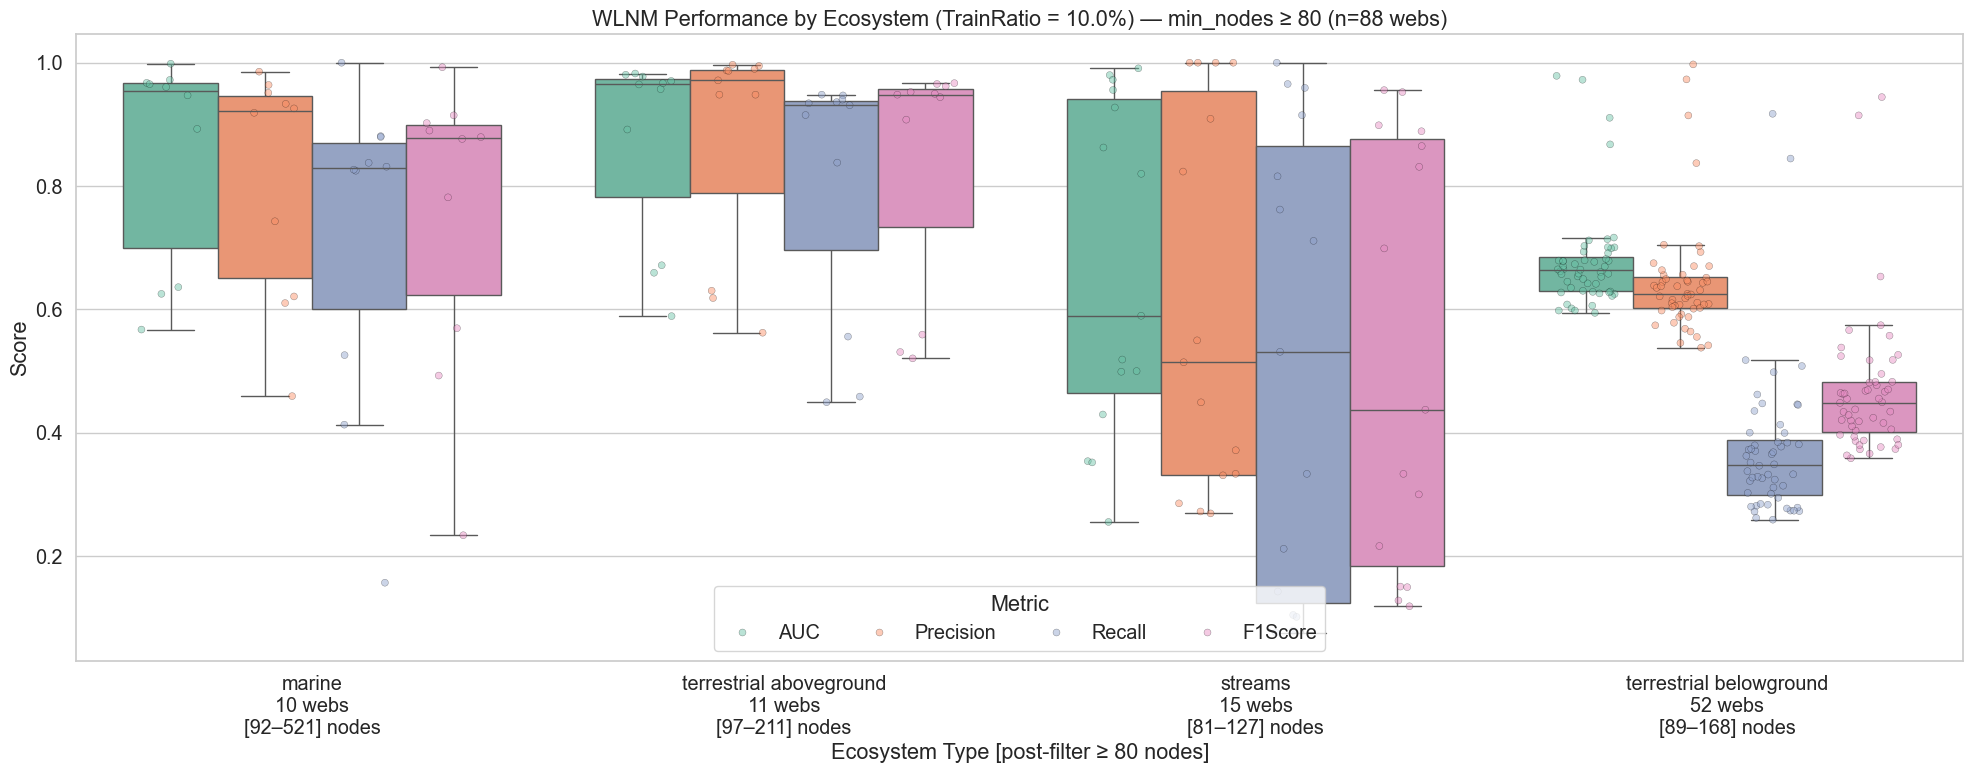

[min_nodes=80] Filtered-out food webs (had TrainRatio=10.0% data): 202


Foodweb                Ecosystem  Nodes     AUC  \
0      Twin Lake East_tax_mass                    lakes     13  0.4000   
1    Brook trout lake_tax_mass                    lakes     15  0.5278   
2     Gull lake north_tax_mass                    lakes     16  0.6190   
3           Deep lake_tax_mass                    lakes     19  0.2400   
4        Emerald lake_tax_mass                    lakes     22  0.8180   
..                         ...                      ...    ...     ...   
197          Herschel_tax_mass  terrestrial aboveground     23  0.5452   
198          Nenetsky_tax_mass  terrestrial aboveground     24  0.5522   
199   FloridaIslandE7_tax_mass  terrestrial aboveground     54  0.5806   
200   FloridaIslandE9_tax_mass  terrestrial aboveground     56  0.5301   
201   FloridaIslandE2_tax_mass  terrestrial aboveground     59  0.7458   

     Precision  Recall  F1Score  
0       0.3333  1.0000   0.5000  
1       0.3333  1.0000   0.5000  
2       0.3333  1.0000   0.5000  
3       0.1786  0.4000   0.2469  
4       0.8182  0.7347   0.7742  
..         ...     ...      ...  
197     0.5000  1.0000   0.6667  
198     0.5000  1.0000   0.6667  
199     0.5088  0.1551   0.2377  
200     0.5566  0.2458   0.3410  
201     0.8205  0.1798   0.2949  

[202 rows x 7 columns]

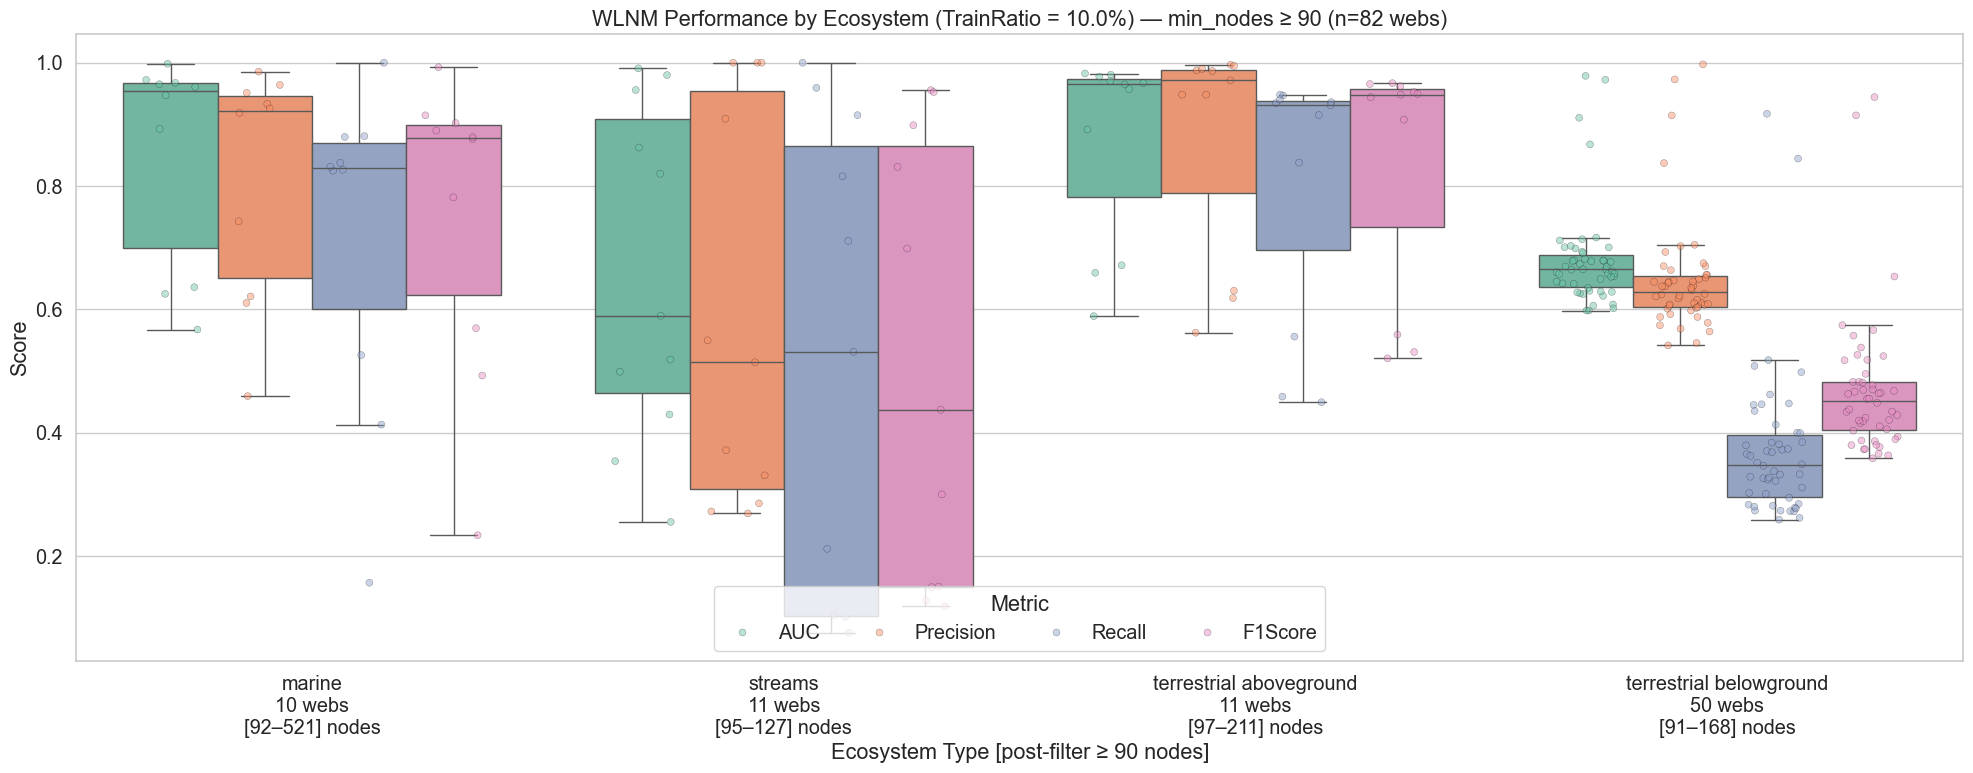

[min_nodes=90] Filtered-out food webs (had TrainRatio=10.0% data): 208


Foodweb                Ecosystem  Nodes     AUC  \
0      Twin Lake East_tax_mass                    lakes     13  0.4000   
1    Brook trout lake_tax_mass                    lakes     15  0.5278   
2     Gull lake north_tax_mass                    lakes     16  0.6190   
3           Deep lake_tax_mass                    lakes     19  0.2400   
4        Emerald lake_tax_mass                    lakes     22  0.8180   
..                         ...                      ...    ...     ...   
203   FloridaIslandE7_tax_mass  terrestrial aboveground     54  0.5806   
204   FloridaIslandE9_tax_mass  terrestrial aboveground     56  0.5301   
205   FloridaIslandE2_tax_mass  terrestrial aboveground     59  0.7458   
206             SEW09_tax_mass  terrestrial belowground     89  0.6274   
207             SEW36_tax_mass  terrestrial belowground     89  0.5943   

     Precision  Recall  F1Score  
0       0.3333  1.0000   0.5000  
1       0.3333  1.0000   0.5000  
2       0.3333  1.0000   0.5000  
3       0.1786  0.4000   0.2469  
4       0.8182  0.7347   0.7742  
..         ...     ...      ...  
203     0.5088  0.1551   0.2377  
204     0.5566  0.2458   0.3410  
205     0.8205  0.1798   0.2949  
206     0.5554  0.3775   0.4495  
207     0.5379  0.3141   0.3966  

[208 rows x 7 columns]

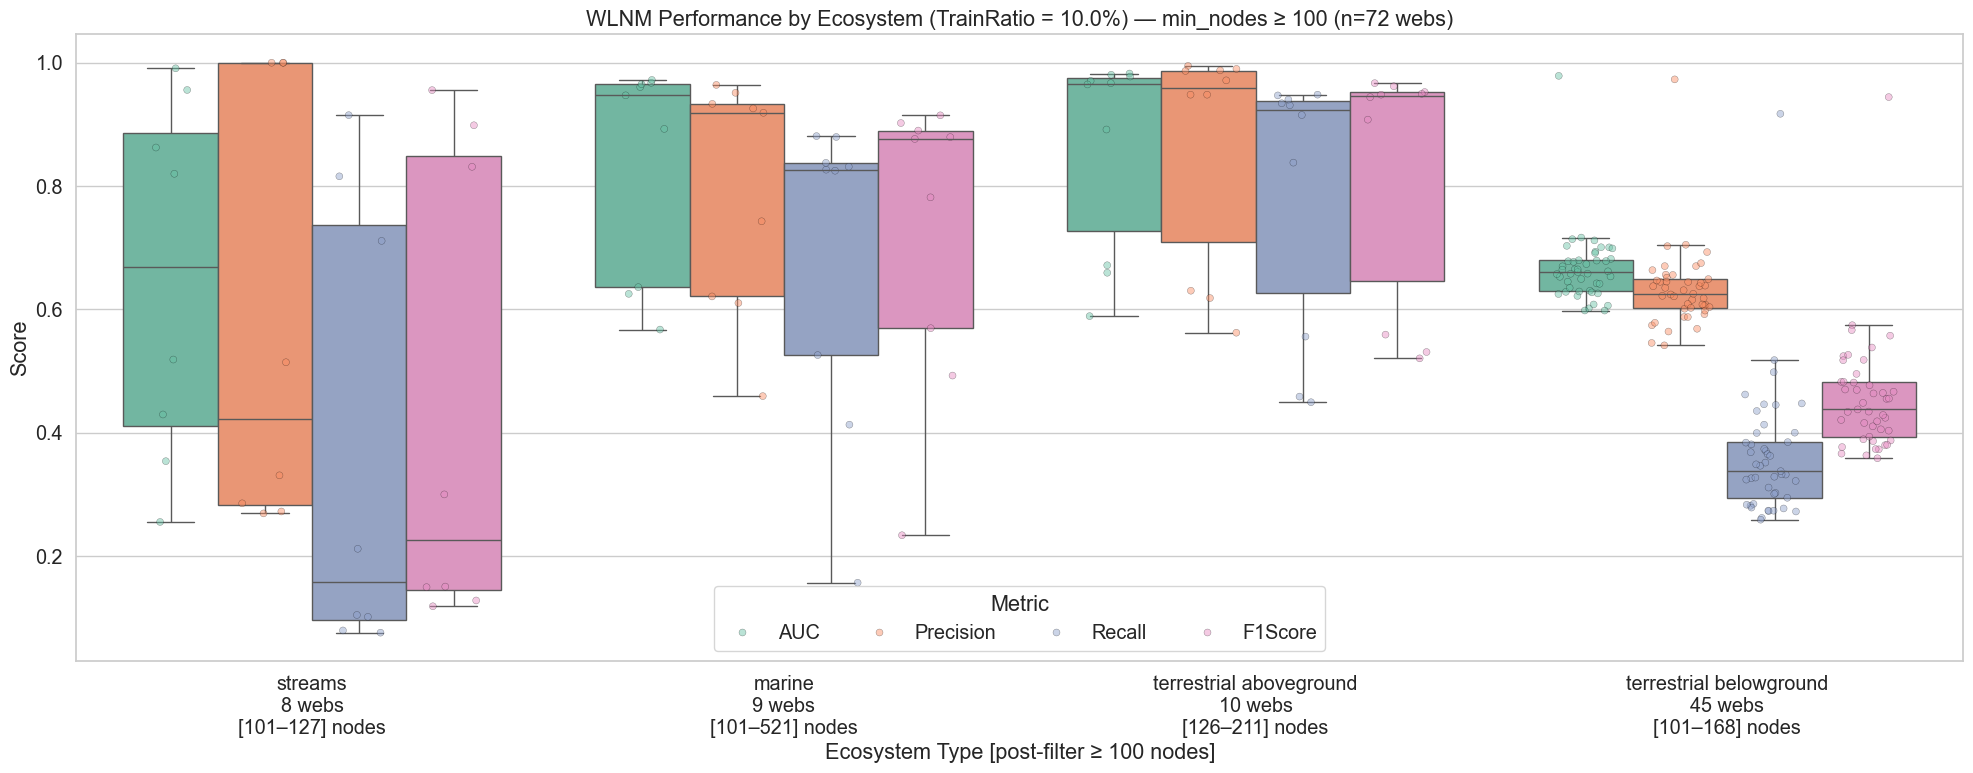

[min_nodes=100] Filtered-out food webs (had TrainRatio=10.0% data): 218


Foodweb                Ecosystem  Nodes  \
0                     Twin Lake East_tax_mass                    lakes     13   
1                   Brook trout lake_tax_mass                    lakes     15   
2                    Gull lake north_tax_mass                    lakes     16   
3                          Deep lake_tax_mass                    lakes     19   
4                       Emerald lake_tax_mass                    lakes     22   
..                                        ...                      ...    ...   
213                            HEW10_tax_mass  terrestrial belowground     91   
214                            SEW02_tax_mass  terrestrial belowground     93   
215  Dutch Microfauna food web PlotA_tax_mass  terrestrial belowground     94   
216  Dutch Microfauna food web PlotB_tax_mass  terrestrial belowground     95   
217  Dutch Microfauna food web PlotC_tax_mass  terrestrial belowground     99   

        AUC  Precision  Recall  F1Score  
0    0.4000     0.3333  1.0000   0.5000  
1    0.5278     0.3333  1.0000   0.5000  
2    0.6190     0.3333  1.0000   0.5000  
3    0.2400     0.1786  0.4000   0.2469  
4    0.8180     0.8182  0.7347   0.7742  
..      ...        ...     ...      ...  
213  0.6787     0.6100  0.3795   0.4679  
214  0.6695     0.6109  0.3725   0.4629  
215  0.9724     0.9973  0.8446   0.9146  
216  0.9107     0.8372  0.2802   0.4198  
217  0.8676     0.9145  0.5082   0.6533  

[218 rows x 7 columns]

In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display  # for nice DataFrame rendering

# --- Paths ---
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"
train_ratio = 10.0  # percentage

sns.set_theme(style="whitegrid", font_scale=1.3)

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

candidates = {
    "n_nodes","num_nodes","nodes","nodecount","n","s",
    "species","numspecies","numberofspecies","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = next((norm_map[k] for k in candidates if k in norm_map), None)
if node_col is None:
    raise RuntimeError("Could not find a node-count column in metadata (e.g. 'S', 'nodes').")

# --- Load result CSVs and stack ---
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# --- Merge results with ecosystem metadata once (no filter yet) ---
meta_cols = ["Foodweb", "ecosystem.type", node_col]
base = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# Helper: normalize TrainRatio to 0–100 scale regardless of how stored
def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# Precompute which webs actually have the requested train ratio
df_all_ratio = df_all.copy()
df_all_ratio["TrainRatio_pct"] = to_percent(df_all_ratio["TrainRatio"])
webs_with_ratio = set(
    df_all_ratio[df_all_ratio["TrainRatio_pct"].round(3) == train_ratio]["Foodweb"].unique()
)

# Precompute median scores per Foodweb at train_ratio (robust to multiple iterations)
score_cols = ["AUC", "Precision", "Recall", "F1Score"]
df_scores_at_ratio = (
    df_all_ratio[df_all_ratio["TrainRatio_pct"].round(3) == train_ratio]
    .groupby("Foodweb")[score_cols].median()  # median across iterations/runs
    .reset_index()
)

# --- Sweep thresholds 0,10,...,100 ---
for min_nodes in range(0, 101, 10):
    dfm = base[base[node_col] >= min_nodes].copy()
    n_webs = dfm["Foodweb"].nunique()
    if dfm.empty or n_webs == 0:
        print(f"[min_nodes={min_nodes}] No food webs remain after filtering. Skipping.")
        continue

    # Prepare data for plotting
    df_plot = dfm.melt(
        id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
        value_vars=score_cols,
        var_name="Metric",
        value_name="Value"
    )
    df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])

    # Subset to TrainRatio = train_ratio
    subset = df_plot[df_plot["TrainRatio_pct"].round(3) == train_ratio].copy()
    if subset.empty:
        print(f"[min_nodes={min_nodes}] No rows for TrainRatio={train_ratio}%. Skipping.")
        continue

    # Order ecosystems (after filtering)
    ecosystem_order = (
        dfm[["Foodweb", "ecosystem.type"]]
        .drop_duplicates()
        .groupby("ecosystem.type")
        .size()
        .sort_values()
        .index
        .tolist()
    )

    # Build dynamic x-axis labels (counts + node range, after filtering)
    def make_label(group: pd.DataFrame) -> str:
        n_webs_g = group["Foodweb"].nunique()
        node_min = int(group[node_col].min())
        node_max = int(group[node_col].max())
        name = group.name
        return f"{name}\n{n_webs_g} webs\n[{node_min}–{node_max}] nodes"

    labels_map = {}
    for eco in ecosystem_order:
        grp = dfm[dfm["ecosystem.type"] == eco]
        grp.name = eco
        labels_map[eco] = make_label(grp)
    custom_labels = [labels_map[e] for e in ecosystem_order]

    # --- Plot: boxplot + points (per-threshold figure) ---
    plt.figure(figsize=(20, 8))
    ax = sns.boxplot(
        data=subset,
        x="ecosystem.type",
        y="Value",
        hue="Metric",
        hue_order=score_cols,
        palette="Set2",
        showfliers=False,
        order=ecosystem_order,
        dodge=True
    )

    sns.stripplot(
        data=subset,
        x="ecosystem.type",
        y="Value",
        hue="Metric",
        hue_order=score_cols,
        palette="Set2",
        dodge=True,
        jitter=0.25,
        alpha=0.45,
        linewidth=0.3,
        edgecolor="black",
        order=ecosystem_order,
        zorder=2
    )

    # De-duplicate legend (boxplot + stripplot each add entries)
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), title="Metric", frameon=True, loc="lower center", ncol=4)

    ax.set_title(f"WLNM Performance by Ecosystem (TrainRatio = {train_ratio}%) — min_nodes ≥ {min_nodes} (n={n_webs} webs)")
    ax.set_ylabel("Score")
    ax.set_xlabel(f"Ecosystem Type [post-filter ≥ {min_nodes} nodes]")
    ax.set_xticks(range(len(custom_labels)))
    ax.set_xticklabels(custom_labels)

    plt.tight_layout()
    plt.show()

    # --- Filtered-out webs at this threshold (that also have this train_ratio) + their median scores ---
    removed_df = (
        df_ecosystem.loc[
            df_ecosystem["Foodweb"].isin(webs_with_ratio) & (df_ecosystem[node_col] < min_nodes),
            ["Foodweb", "ecosystem.type", node_col]
        ]
        .rename(columns={"ecosystem.type": "Ecosystem", node_col: "Nodes"})
        .merge(df_scores_at_ratio, on="Foodweb", how="left")   # <- add AUC/Precision/Recall/F1Score
        .sort_values(["Ecosystem", "Nodes", "Foodweb"])
        .reset_index(drop=True)
    )

    if removed_df.empty:
        print(f"[min_nodes={min_nodes}] No food webs were filtered out (with TrainRatio={train_ratio}%).")
    else:
        print(f"[min_nodes={min_nodes}] Filtered-out food webs (had TrainRatio={train_ratio}% data): {len(removed_df)}")
        display(removed_df)

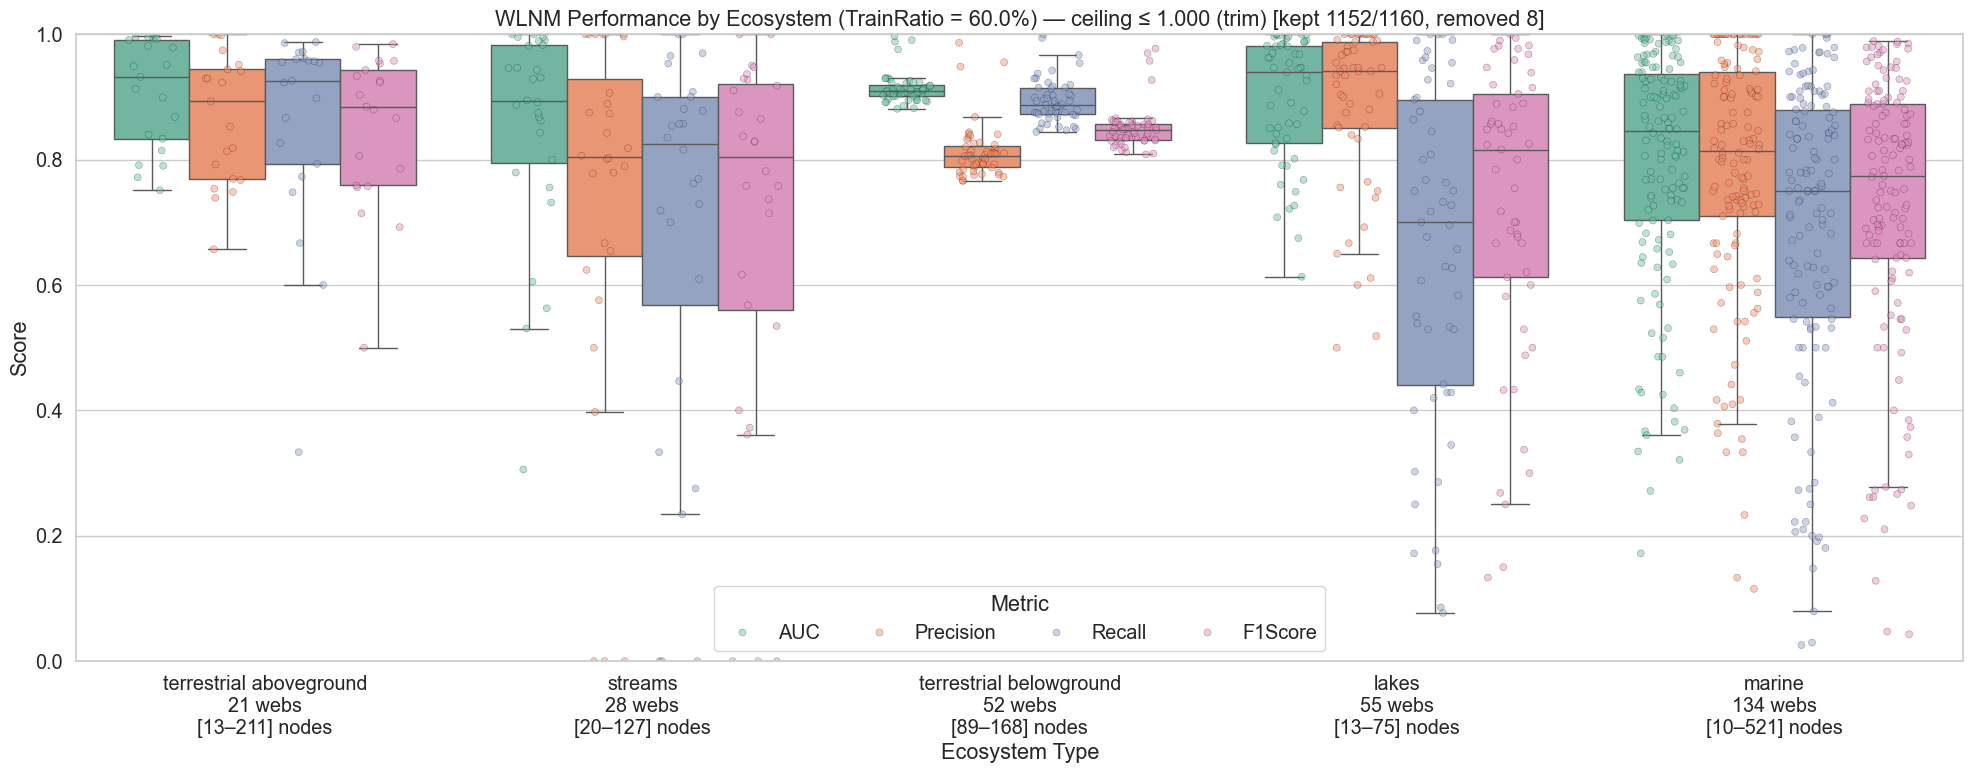

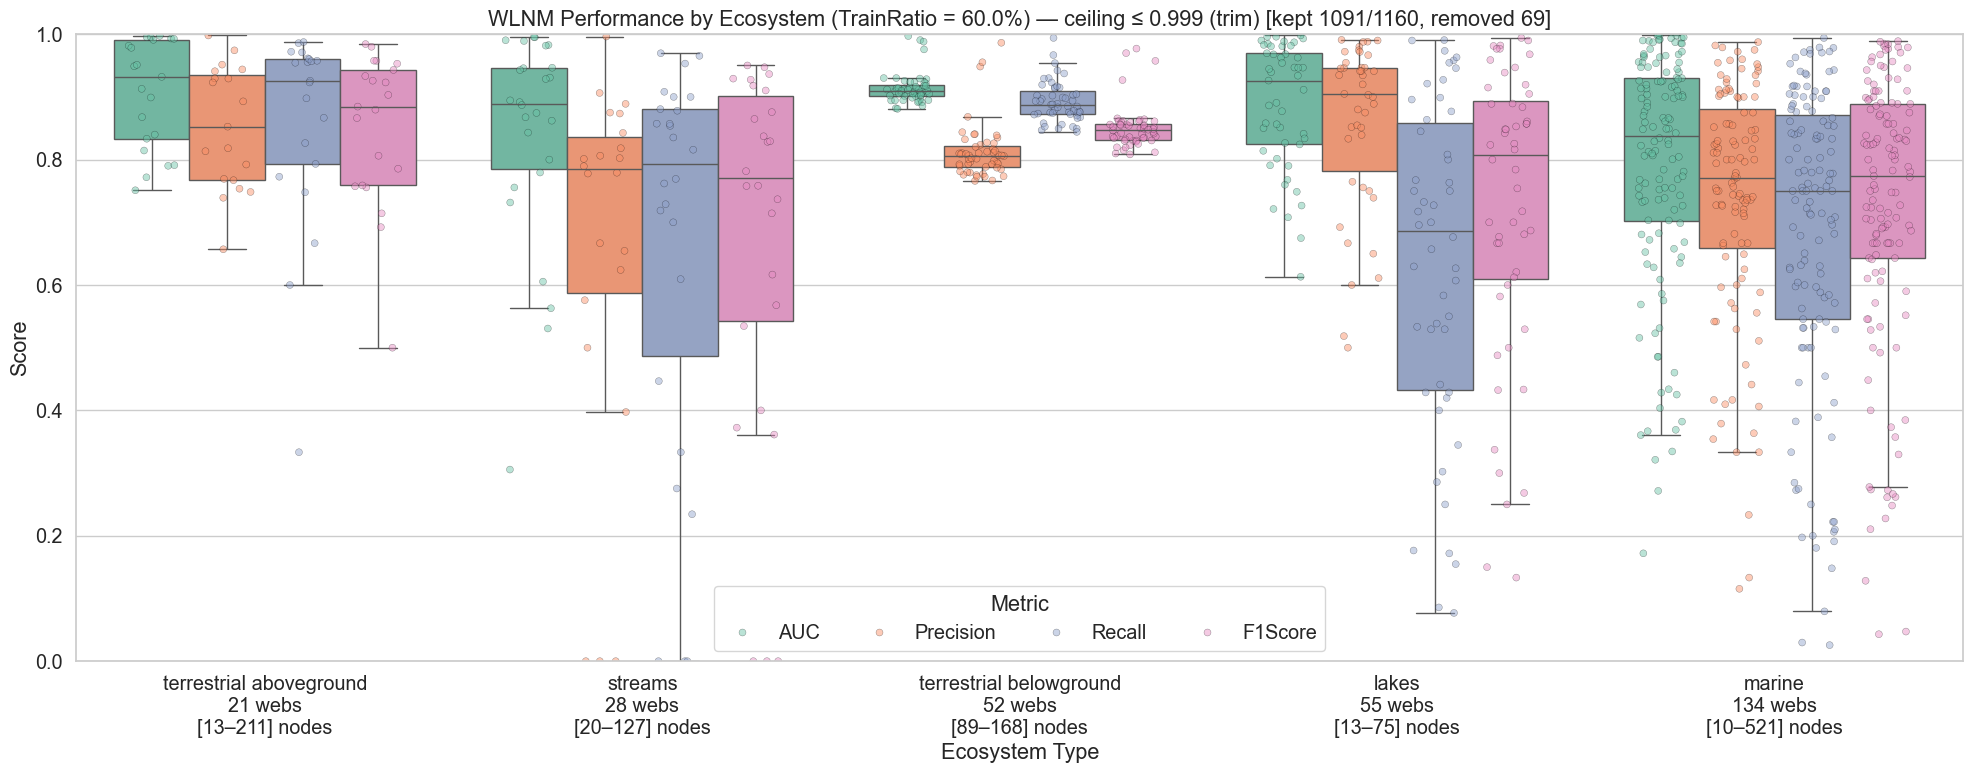

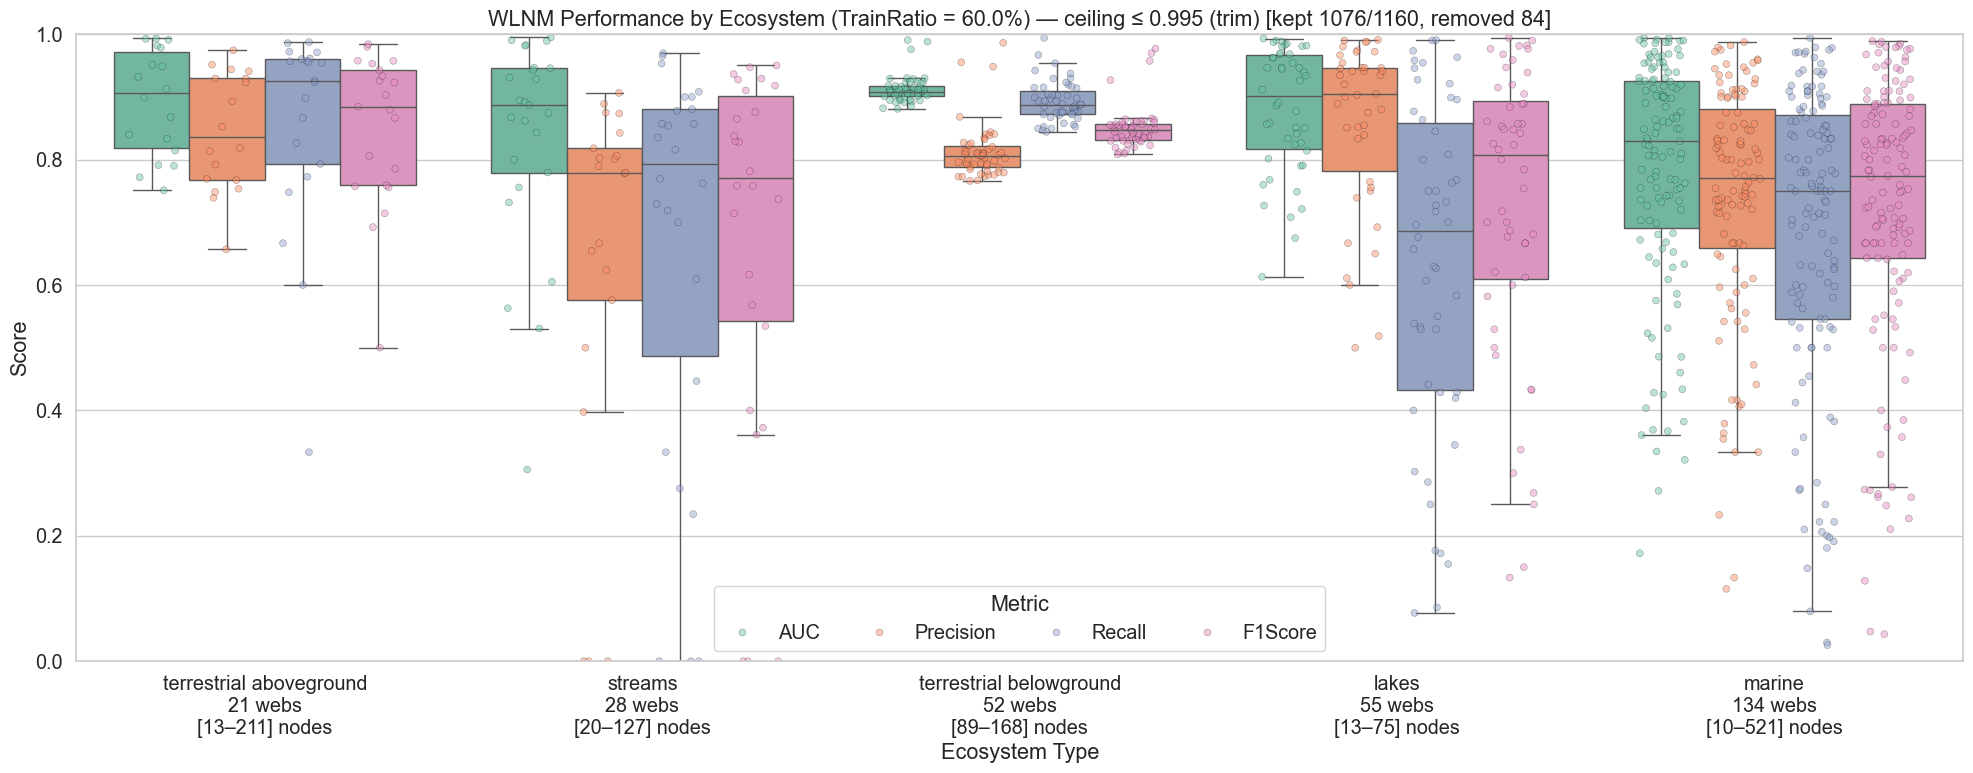

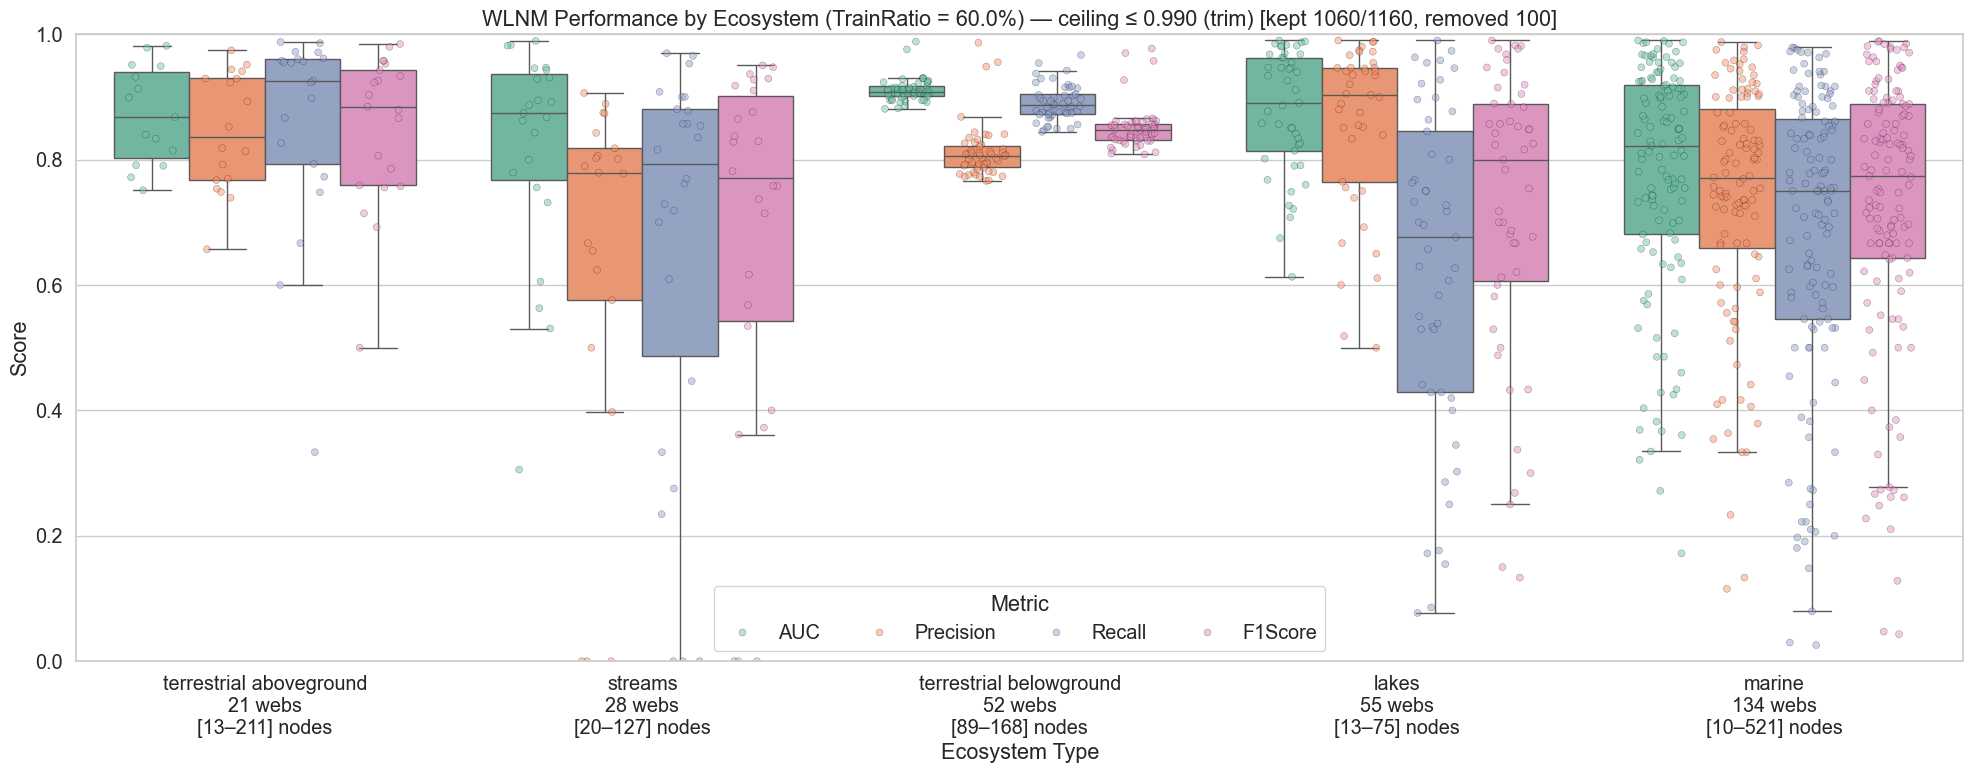

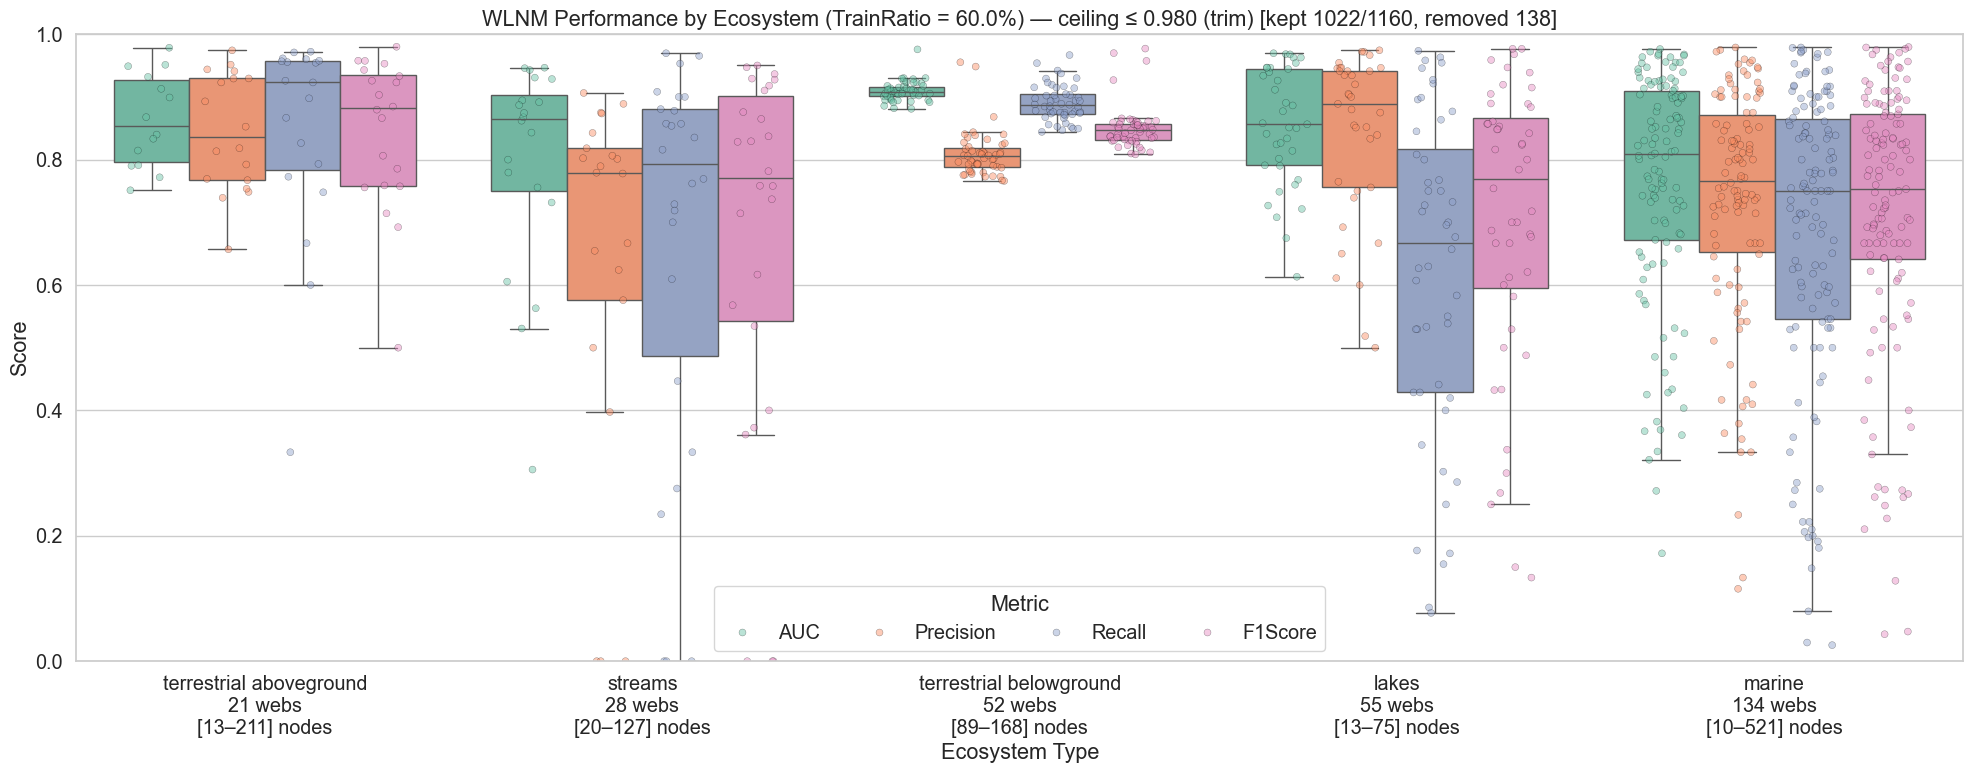

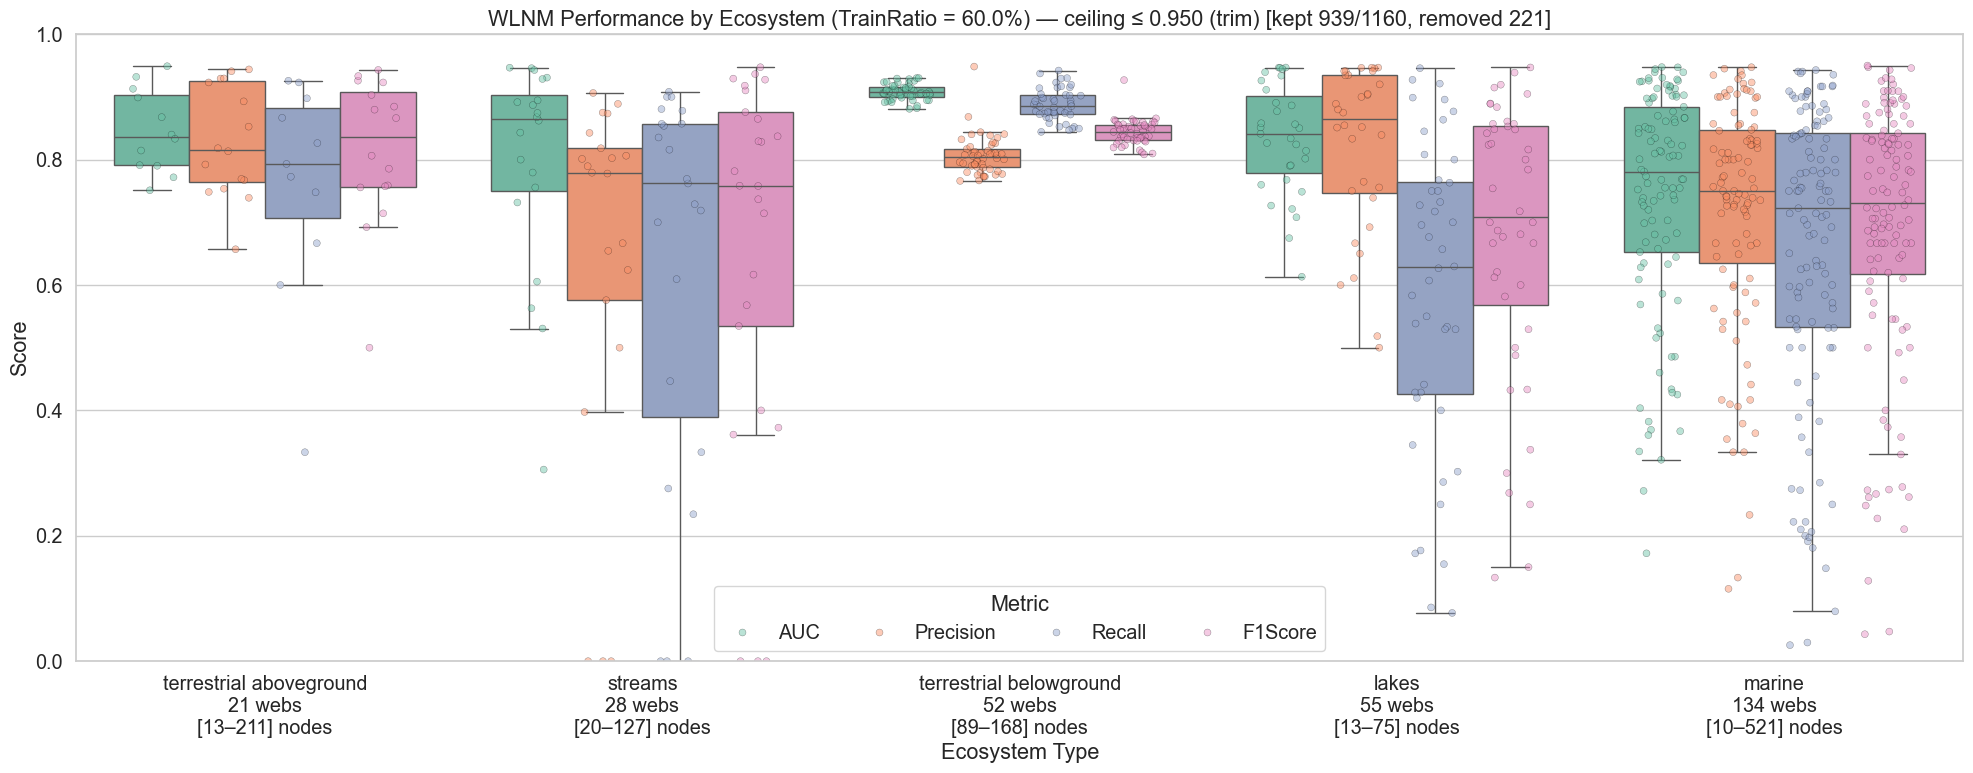

ecosystem.type  Metric   median    n  ceiling  mode  \
100                    lakes     AUC  0.84120   31     0.95  trim   
104                   marine     AUC  0.78090  105     0.95  trim   
108                  streams     AUC  0.86485   20     0.95  trim   
112  terrestrial aboveground     AUC  0.83660   12     0.95  trim   
116  terrestrial belowground     AUC  0.90780   48     0.95  trim   
..                       ...     ...      ...  ...      ...   ...   
3                      lakes  Recall  0.70000   53     1.00  trim   
7                     marine  Recall  0.75000  134     1.00  trim   
11                   streams  Recall  0.82555   28     1.00  trim   
15   terrestrial aboveground  Recall  0.92580   21     1.00  trim   
19   terrestrial belowground  Recall  0.88785   52     1.00  trim   

     median_at_1.0  delta_vs_1.0  
100        0.93950      -0.09830  
104        0.84535      -0.06445  
108        0.89310      -0.02825  
112        0.93200      -0.09540  
116        0.90870      -0.00090  
..             ...           ...  
3          0.70000       0.00000  
7          0.75000       0.00000  
11         0.82555       0.00000  
15         0.92580       0.00000  
19         0.88785       0.00000  

[120 rows x 8 columns]

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Paths ---
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"
train_ratio = 60.0
mode = "trim"       # "trim" drops values > ceil; "winsorize" clips them down to ceil

sns.set_theme(style="whitegrid", font_scale=1.3)

# --- Load ecosystem metadata ---
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace(".", "").replace("-", "").replace("_", "")

candidates = {
    "n_nodes","num_nodes","nodes","nodecount","n","s",
    "species","numspecies","numberofspecies","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = next((norm_map[k] for k in candidates if k in norm_map), None)
if node_col is None:
    raise RuntimeError("Could not find a node-count column in metadata (e.g. 'S', 'nodes').")

# --- Load result CSVs and stack ---
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# --- Merge results with ecosystem metadata once (no filter yet) ---
meta_cols = ["Foodweb", "ecosystem.type", node_col]
base = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# Helper: normalize TrainRatio to 0–100 scale regardless of how stored
def to_percent(s: pd.Series) -> pd.Series:
    sr = pd.to_numeric(s, errors="coerce")
    if sr.dropna().max() <= 1.000001:  # stored as 0.0–1.0
        sr = sr * 100
    return sr

# Prepare long form once, then subset by train ratio
df_plot = base.melt(
    id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
    value_vars=["AUC", "Precision", "Recall", "F1Score"],
    var_name="Metric",
    value_name="Value"
)
df_plot["TrainRatio_pct"] = to_percent(df_plot["TrainRatio"])

subset = df_plot[df_plot["TrainRatio_pct"].round(3) == train_ratio].copy()
if subset.empty:
    raise RuntimeError(f"No rows for TrainRatio={train_ratio}.")

# Order ecosystems and build labels (as in your code)
ecosystem_order = (
    base[["Foodweb", "ecosystem.type"]]
    .drop_duplicates()
    .groupby("ecosystem.type")
    .size()
    .sort_values()
    .index
    .tolist()
)

def make_label(group: pd.DataFrame, node_col=node_col) -> str:
    n_webs_g = group["Foodweb"].nunique()
    node_min = int(group[node_col].min())
    node_max = int(group[node_col].max())
    name = group.name
    return f"{name}\n{n_webs_g} webs\n[{node_min}–{node_max}] nodes"

labels_map = {}
for eco in ecosystem_order:
    grp = base[base["ecosystem.type"] == eco]
    grp.name = eco
    labels_map[eco] = make_label(grp)
custom_labels = [labels_map[e] for e in ecosystem_order]

# ========= Ceiling sweep =========
ceil_grid = [1.000, 0.999, 0.995, 0.990, 0.980, 0.950]
metrics_order = ["AUC", "Precision", "Recall", "F1Score"]

summary_rows = []

for ceil in ceil_grid:
    if mode == "trim":
        data = subset[subset["Value"] <= ceil].copy()
    elif mode == "winsorize":
        data = subset.copy()
        data["Value"] = data["Value"].clip(upper=ceil)
    else:
        raise ValueError("mode must be 'trim' or 'winsorize'.")

    n_before = len(subset)
    n_after  = len(data)
    removed  = n_before - n_after

    if data.empty:
        print(f"[ceil={ceil:.3f}] No data after filtering. Skipping plot.")
        continue

    # --- Plot: boxplot + points per ceiling cutoff ---
    plt.figure(figsize=(20, 8))
    ax = sns.boxplot(
        data=data,
        x="ecosystem.type",
        y="Value",
        hue="Metric",
        hue_order=metrics_order,
        palette="Set2",
        showfliers=False,
        order=ecosystem_order,
        dodge=True
    )
    sns.stripplot(
        data=data,
        x="ecosystem.type",
        y="Value",
        hue="Metric",
        hue_order=metrics_order,
        palette="Set2",
        dodge=True,
        jitter=0.25,
        alpha=0.45,
        linewidth=0.3,
        edgecolor="black",
        order=ecosystem_order,
        zorder=2
    )

    # Deduplicate legend
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), title="Metric", frameon=True, loc="lower center", ncol=4)

    ax.set_title(
        f"WLNM Performance by Ecosystem (TrainRatio = {train_ratio}%) — ceiling ≤ {ceil:.3f} ({mode}) "
        f"[kept {n_after}/{n_before}, removed {removed}]"
    )
    ax.set_ylabel("Score")
    ax.set_xlabel(f"Ecosystem Type")
    ax.set_xticks(range(len(custom_labels)))
    ax.set_xticklabels(custom_labels)
    plt.ylim(0.0, 1.0)  # keep a fixed scale to compare ceilings
    plt.tight_layout()
    plt.show()

    # --- Summary table: median and count per eco/metric at this ceiling ---
    g = (data.groupby(["ecosystem.type", "Metric"])["Value"]
            .agg(median="median", n="count")
            .reset_index())
    g["ceiling"] = ceil
    g["mode"] = mode
    summary_rows.append(g)

# Combine and display a compact summary (optional)
if summary_rows:
    summary = pd.concat(summary_rows, ignore_index=True)
    # You can save or inspect deltas relative to ceil=1.0
    baseline = summary[summary["ceiling"] == 1.0][["ecosystem.type","Metric","median"]]
    baseline = baseline.rename(columns={"median": "median_at_1.0"})
    summary = summary.merge(baseline, on=["ecosystem.type","Metric"], how="left")
    summary["delta_vs_1.0"] = summary["median"] - summary["median_at_1.0"]
    # Tip: filter to AUC if that’s your primary figure
    display(summary.sort_values(["Metric","ceiling","ecosystem.type"]))